### Import libraries

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone
from scipy.stats import beta, linregress
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import ParameterGrid
import torch
import torch.nn as nn
import time
from tqdm import tqdm
import os
import glob
import warnings
import itertools
import gc

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU Name; {torch.cuda.get_device_name(0)}")
    
    warnings.filterwarnings("ignore")

Using Device: cuda
GPU Name; NVIDIA GeForce RTX 3060 Ti


### Data Preparation Function

In [2]:
def download_btc_data(start_year, end_year, timeframe, symbol = 'BTC/USDT'):
    """
    Args:
        start_year (int): 시작 연도
        end_year (int): 종료 연도
        timeframe (str): 데이터 간격 ('1m', '10m' ,'1d')
        symbol (str): 코인 심볼 (기본 BTC/USDT)
    """
    
    save_dir = "data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[INFO] Directory '{save_dir}' created")

    # Create Binance object
    binance = ccxt.binance({
        'enableRateLimit': True,
        'options': {'defaultType': 'future'}
    })

    # Check wheather Binance support timeframe
    if timeframe not in binance.timeframes:
        print(f"[ERROR] '{timeframe} is not a valid timeframe")
        return

    print(f"Target: {symbol} | Timeframe: {timeframe} | Period: {start_year} ~ {end_year}")
    
    safe_symbol = symbol.replace("/", "")

    for year in range(start_year, end_year + 1):
        # Set file path including data folder
        filename = f"{safe_symbol}_{timeframe}_{year}.csv"
        file_path = os.path.join(save_dir, filename)
        
        # Check file existence
        if os.path.exists(file_path):
            print(f"[SKIP] '{filename}' already exists")
            continue
        
        print(f"\n[INFO] Downloading Year: {year}")
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo = timezone.utc)
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo = timezone.utc)

        since = int(start_date.timestamp() * 1000)
        end_timestamp = int(end_date.timestamp() * 1000)

        year_ohlcvs = []

        approx_counts = {
            '1m': 525600, '1d': 365 # 10m Data Not Support in Binance API
        }
        total_candles = approx_counts.get(timeframe, 10000)

        pbar = tqdm(total = total_candles, desc = f"{year} Progress", unit = "candle")

        while since < end_timestamp:
            try:
                ohlcvs = binance.fetch_ohlcv(symbol, timeframe = timeframe, since = since, limit = 1000)

                if not ohlcvs:
                    break

                year_ohlcvs.extend(ohlcvs)

                current_last_time = ohlcvs[-1][0]
                since = current_last_time + 1

                pbar.update(len(ohlcvs))

                if current_last_time >= end_timestamp:
                    break

                time.sleep(0.05)

            except Exception as e:
                print(f"[ERROR] {e}, Retryung")
                time.sleep(3)
                continue

        pbar.close()

        if year_ohlcvs:
            df = pd.DataFrame(year_ohlcvs, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms', utc = True)

            df = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

            df.set_index('datetime', inplace = True)
            df.drop(columns = ['timestamp'], inplace = True)
            
            df.to_csv(file_path)
            print(f"[SUCCESS] Saved {file_path} (Rows: {len(df)})")
        else:
            print(f"[FAIL] No data for {year}")
            
            
def resample_to_10m(start_year, end_year, symbol = 'BTC/USDT'):
    """
    Transform 1m data to 10m data and store to csv file
    """
    save_dir = "data"
    safe_symbol = symbol.replace("/", "")
    
    print(f"Starting Resampling: {symbol} (1m -> 10m) | {start_year} ~ {end_year}")
    
    for year in range(start_year, end_year + 1):
        input_filename = f"{safe_symbol}_1m_{year}.csv"
        input_path = os.path.join(save_dir, input_filename)
        
        output_filename = f"{safe_symbol}_10m_{year}.csv"
        output_path = os.path.join(save_dir, output_filename)
        
        if not os.path.exists(input_path):
            print(f"[SKIP] Source file not found: {input_filename}")
            continue
        
        if os.path.exists(output_path):
            print(f"[SKIP] Target file already exists: {output_filename}")
            continue
        
        print(f"\n[PROCESSING] {input_filename} -> {output_filename}")
        
        try:
            df = pd.read_csv(input_path)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace = True)
            
            ohlcv_dict = {
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            }
            
            df_10m = df.resample('10min').apply(ohlcv_dict)
            
            df_10m.dropna(inplace = True)
            
            df_10m.to_csv(output_path)
            print(f"[DONE] Saved {output_filename} (Rows: {len(df_10m)})")
            
        except Exception as e:
            print(f"[ERROR] Failed to process {year}: {e}")

In [3]:
# Prepare BTC Data for 1m, 1d, 10m
download_btc_data(2020, 2024, timeframe = '1m')
download_btc_data(2020, 2024, timeframe = '1d')
resample_to_10m(2020, 2024)

Target: BTC/USDT | Timeframe: 1m | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1m_2020.csv' already exists
[SKIP] 'BTCUSDT_1m_2021.csv' already exists
[SKIP] 'BTCUSDT_1m_2022.csv' already exists
[SKIP] 'BTCUSDT_1m_2023.csv' already exists
[SKIP] 'BTCUSDT_1m_2024.csv' already exists
Target: BTC/USDT | Timeframe: 1d | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1d_2020.csv' already exists
[SKIP] 'BTCUSDT_1d_2021.csv' already exists
[SKIP] 'BTCUSDT_1d_2022.csv' already exists
[SKIP] 'BTCUSDT_1d_2023.csv' already exists
[SKIP] 'BTCUSDT_1d_2024.csv' already exists
Starting Resampling: BTC/USDT (1m -> 10m) | 2020 ~ 2024
[SKIP] Target file already exists: BTCUSDT_10m_2020.csv
[SKIP] Target file already exists: BTCUSDT_10m_2021.csv
[SKIP] Target file already exists: BTCUSDT_10m_2022.csv
[SKIP] Target file already exists: BTCUSDT_10m_2023.csv
[SKIP] Target file already exists: BTCUSDT_10m_2024.csv


### MF-DFA Function

In [4]:
def mfdfa(data_array, scales, q_list, poly_order = 2):
    """
    Fuction for MFDFA by using Pytorch

    Args:
        batch_data: (Batch_Size, Window_Size) tensor
    """
    if isinstance(data_array, torch.Tensor):
        data_array = data_array.detach().cpu().numpy()
    elif isinstance(data_array, (pd.DataFrame, pd.Series)):
        data_array = data_array.values
    data_array = np.array(data_array)
    
    if data_array.ndim == 1:
        data_array = data_array.reshape(1, -1)
        
    batch_size, N = data_array.shape
    profile = np.cumsum(data_array - np.mean(data_array, axis = 1, keepdims = True), axis = 1)
    
    F_q_s = []
    valid_scales = []
    
    for s in scales:
        if N // s < 4: continue
        valid_scales.append(s)
        N_s = N // s
        
        seg_f = profile[:, :N_s*s].reshape(batch_size, N_s, s)
        seg_b = profile[:, -N_s*s:].reshape(batch_size, N_s, s)
        segments = np.concatenate([seg_f, seg_b], axis = 1)
        
        x_axis = np.linspace(-1, 1, s)
        
        X_design = np.vstack([x_axis**i for i in range(poly_order+1)]).T
        pinv_X = np.linalg.pinv(X_design)
        
        beta = np.matmul(segments, pinv_X.T)
        trend = np.matmul(beta, X_design.T)
        
        resid = segments - trend
        F2 = np.mean(resid**2, axis = 2)
        F2 = np.maximum(F2, 1e-20)
        
        F_vals = []
        for q in q_list:
            if abs(q) < 1e-5:
                f_q = np.exp(0.5 * np.mean(np.log(F2), axis = 1))
            else:
                f_q = np.mean(F2**(q/2), axis = 1)**(1/q)
            F_vals.append(f_q)
            
        F_q_s.append(np.stack(F_vals, axis = 1))
    
    if not F_q_s: return None, None
    
    F_output = np.stack(F_q_s, axis = 2)
    
    return np.array(valid_scales), F_output

def mfdfa_features(price_series, device, window, step):
    print(f"[INFO] Extracting MFDFA Features (Window: {window})")
    
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.iloc[:, 0]
    
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values
    
    windows = []
    indices = []
    
    BATCH_SIZE =   64
    feature_list = []
    
    q_list = np.linspace(-5, 5, 15)
    scales = np.unique(np.logspace(np.log10(10), np.log10(window//4), 10).astype(int))
    
    for t in tqdm(range(window, len(values), step)):
        seg = values[t-window : t]
        windows.append(seg)
        indices.append(log_ret.index[t])
        
        if len(windows) >= BATCH_SIZE:
            batch_tensor = torch.tensor(np.array(windows), dtype = torch.float32).to(device)
            s_vals, F_tensor = mfdfa(batch_tensor, scales, q_list)
            
            if F_tensor is not None:
                F_np = F_tensor
                log_s = np.log(s_vals)
                
                for i in range(len(F_np)):
                    h_q = []
                    for i_q in range(len(q_list)):
                        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i, i_q, :]))
                        h_q.append(slope)
                        
                    h_q = np.array(h_q)
                    delta_H = np.max(h_q) - np.min(h_q)
                    q_arr = np.array(q_list)
                    tau = q_arr * h_q - 1
                    alpha = np.gradient(tau, q_arr)
                    
                    delta_alpha = np.max(alpha) - np.min(alpha)
                    alpha_0 = alpha[len(q_list)//2]
                    
                    feature_list.append([delta_H, delta_alpha, alpha_0])
                    
            windows = []
    if len(feature_list) != len(indices):
        min_len = min(len(feature_list), len(indices))
        feature_list = feature_list[:min_len]
        indices = indices[:min_len]
    
    return pd.DataFrame(feature_list, columns = ['delta_H', 'delta_alpha', 'alpha_0'], index = indices).dropna()


def compute_spectrum(price_series, q_list):
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values

    N = len(values)
    min_scale = 30
    max_scale = N // 10
    scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 30).astype(int))

    s_vals, F_batch = mfdfa(values, scales, q_list, poly_order = 2)

    if F_batch is None: return None

    F_np = F_batch[0]
    log_s = np.log(s_vals)
    h_q = []

    for i_q in range(len(q_list)):
        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i_q, :]))
        h_q.append(slope)

    h_q = np.array(h_q)
    delta_H = np.max(h_q) - np.min(h_q)
    q_arr = np.array(q_list)
    tau = q_arr * h_q - 1
    alpha = np.gradient(tau, q_arr)
    delta_alpha = np.max(alpha) - np.min(alpha)
    f_alpha = q_arr * alpha - tau
    alpha_0 = alpha[len(q_list)//2]

    return{
        'scales': s_vals, 'F_q_s': F_np, 'H_q': h_q,
        'tau_q': tau, 'alpha': alpha, 'f_alpha': f_alpha,
        'delta_H': delta_H, 'delta_alpha': delta_alpha,
        'alpha_0': alpha_0
    }

### AI Model

In [5]:
class FlattenLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        
        return self.fc(out[:, -1, :])
    
class FlattenBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenBiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first = True,
            bidirectional = True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        
        return self.fc(out[:, -1, :])

class FlattenGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenGRU, self).__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers,
            batch_first = True, bidirectional = False
        )

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class FlattenBiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenBiGRU, self).__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers,
            batch_first = True, bidirectional = True
        )

        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

def prepare_flatten_features(df_base, mfdfa_df, lags=144):
    print(f"Data Preprocessing: Creating Lags={lags} (Safe & Optimized)")
    
    # ---------------------------------------------------------
    # 1. MF-DFA 전처리
    # ---------------------------------------------------------
    # 타임존 제거
    if df_base.index.tz is not None: df_base.index = df_base.index.tz_localize(None)
    
    mfdfa_cols = ['delta_H', 'delta_alpha', 'alpha_0']
    mfdfa_subset = mfdfa_df[mfdfa_cols].copy()
    
    if mfdfa_subset.index.tz is not None: mfdfa_subset.index = mfdfa_subset.index.tz_localize(None)
    
    # 10분 단위 데이터를 '일별(Daily)'로 강제 압축
    # resample('1D').last()를 사용하여 하루 중 마지막 값을 그날의 대표값으로 사용
    # 이렇게 하면 하루에 데이터가 딱 1개만 남으므로 600만 개로 폭발하는 것을 막습니다.
    mfdfa_daily = mfdfa_subset.resample('1D').last()
    
    # 시간을 00:00:00으로 통일
    mfdfa_daily.index = pd.to_datetime(mfdfa_daily.index).normalize()
    
    # Data Leakage 방지를 위한 Shift (어제 데이터를 오늘 사용)
    mfdfa_shifted = mfdfa_daily.shift(1)
    
    # ---------------------------------------------------------
    # 2. 데이터 병합
    # ---------------------------------------------------------
    # df_base에 임시 날짜 키 생성
    df_base['date_key'] = df_base.index.normalize()
    
    # Left Join: (44,000행) x (1행/일) -> 44,000행 유지 
    merged_data = pd.merge(df_base, mfdfa_shifted, 
                           left_on='date_key', right_index=True, 
                           how='left')
    
    merged_data.drop(columns=['date_key'], inplace=True)
    
    # 결측치 채우기 (앞의 값으로 채움)
    merged_data[mfdfa_cols] = merged_data[mfdfa_cols].fillna(method='ffill')
    
    # ---------------------------------------------------------
    # 3. 변수 생성 및 메모리 최적화
    # ---------------------------------------------------------
    merged_data['Future_RV_24h'] = (merged_data['return']**2).rolling(window=144).sum().shift(-144)
    merged_data['Future_Vol_24h'] = np.sqrt(merged_data['Future_RV_24h'])
    merged_data['Past_RV'] = (merged_data['return']**2).rolling(window=144).sum()
    
    merged_data['Base_Vol'] = merged_data['gm_vol'].fillna(method='ffill')
    merged_data['Target_Residual'] = merged_data['Future_Vol_24h'] - merged_data['Base_Vol']
    
    cols_needed = ['Target_Residual', 'Base_Vol', 'Future_Vol_24h'] + ['Past_RV', 'return'] + mfdfa_cols
    data = merged_data[cols_needed].copy()
    
    # float32 변환 (메모리 절약)
    for col in data.select_dtypes(include=['float64']).columns:
        data[col] = data[col].astype('float32')
        
    data.dropna(inplace=True)
    
    # ---------------------------------------------------------
    # 4. Lag Feature 생성
    # ---------------------------------------------------------
    base_features = ['Past_RV', 'return'] + mfdfa_cols
    feature_dfs = [data]
    all_feature_cols = []
    
    for lag in tqdm(range(1, lags + 1), desc="Generating Lags"):
        shifted = data[base_features].shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in base_features]
        feature_dfs.append(shifted)
        all_feature_cols.extend(shifted.columns)

    # 메모리 청소
    del merged_data, mfdfa_shifted, mfdfa_daily
    gc.collect()

    # 병합
    data_final = pd.concat(feature_dfs, axis=1)
    data_final.dropna(inplace=True)
    
    print(f"Final Data shape: {data_final.shape}")
    
    return data_final, all_feature_cols

def run_rolling_simulation(full_data, feature_cols, model_type = 'LSTM', train_window = 4320):
    print(f"\n[INFO] {model_type} Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values

    full_data['GARCH_Daily'] = full_data['Base_Vol'] * 12
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['GARCH_Daily']
    y_full = full_data[['Residual']].values
    
    start_idx = train_window
    total_len = len(full_data)
    
    scaler_X = MinMaxScaler((-1, 1))
    scaler_X.fit(X_full[:start_idx])
    X_scaled = scaler_X.transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    scaler_y.fit(y_full[:start_idx])
    y_scaled = scaler_y.transform(y_full)
    
    model_type = model_type.upper()
    
    is_deep_learning = model_type in ['LSTM', 'BI-LSTM', 'GRU', 'BI-GRU']
    if is_deep_learning:
        X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
        y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
        
        X_tensor = X_tensor.unsqueeze(1)
        
        input_dim =len(feature_cols)
        hidden_dim = 64
        num_layers = 2
        
        if model_type == 'LSTM':
            model = FlattenLSTM(input_dim, hidden_dim, num_layers).to(DEVICE)
        elif model_type == 'BI-LSTM':
            model = FlattenBiLSTM(input_dim, hidden_dim, num_layers).to(DEVICE)
        elif model_type == 'GRU':
            model = FlattenGRU(input_dim, hidden_dim, num_layers).to(DEVICE)
        elif model_type == 'BI-GRU':
            model = FlattenBiGRU(input_dim, hidden_dim, num_layers).to(DEVICE)
        else:
            raise ValueError(f"Not supported model type: {model_type}")
    
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
        loss_fn = nn.HuberLoss(delta = 1.0).to(DEVICE)
    else:
        pass

    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    
    predictions = []
    indices = []
    loss_history = []
    
    end_idx = len(full_data)
    
    sim_start = start_idx
    
    pbar = tqdm(range(sim_start, end_idx), desc = f"{model_type} Rolling Update")
    
    for t in pbar:
        if is_deep_learning:
            model.train()
            
            X_batch = X_tensor[t - train_window : t]
            y_batch = y_tensor[t - train_window : t]
            
            optimizer.zero_grad()
            pred_train = model(X_batch)
            loss = loss_fn(pred_train, y_batch)
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.item())
            
            model.eval()
            with torch.no_grad():
                X_input = X_tensor[t].unsqueeze(0)
                pred_val = model(X_input).item()
        else:
            ridge_model = Ridge(alpha = 1.0)
            X_train = X_scaled[t - train_window : t]
            y_train = y_scaled[t - train_window : t]
            ridge_model.fit(X_train, y_train)
            
            X_curr = X_scaled[t].reshape(1, -1)
            pred_val = ridge_model.predict(X_curr).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h', 'GARCH_Daily']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['GARCH_Daily'] + final_df['Predicted_Residual']
    
    return final_df, loss_history
    

    print("\n[INFO] GRU Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values

    full_data['GARCH_Daily'] = full_data['Base_Vol'] * 12
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['GARCH_Daily']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    
    input_dim = len(feature_cols)
    
    model = FlattenGRU(input_dim, hidden_dim = 128, num_layers = 2).to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144)
    total_len = len(full_data)
    
    if total_len < train_window + test_len:
        print("Perform Minimum Length because of Lack of Data")
        start_idx = train_window
    else:
        start_idx = total_len - test_len
        
    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    sim_start = start_idx
    end_idx = len(full_data)
    
    pbar = tqdm(range(sim_start, end_idx), desc = "GRU Rolling Update")
    
    for t in pbar:
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model

        predictions.append(pred_val)
        indices.append(full_data.index[t])

    pred_array = np.array((predictions).reshape(-1, 1))
    pred_rescaled = scaler_y.inverse_transform((pred_array)).flatten()

    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled

    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h', 'GARCH_Daily']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['GARCH_Daily'] + final_df['Predicted_Residual']

    return final_df

def run_rolling_flatten_lstm_tuned(full_data, feature_cols, hidden_dim = 128, num_layers = 2, train_window = 4320, test_days = 30):
    print(f"\n[INFO] Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    
    input_dim =len(feature_cols)
    model = FlattenLSTM(input_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144) 
    total_len = len(full_data)
    
    if total_len < train_window + test_len:
        print("데이터 부족으로 가능한 최대 기간만 수행합니다.")
        start_idx = train_window
    else:
        # 정확히 테스트 기간만큼만 뒤에서부터 실행
        start_idx = total_len - test_len

    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    start_idx = train_window
    
    for t in range(start_idx, total_len):
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df, []

### GARCH-MIDAS Model

In [6]:
def get_beta_weights(K, w1, w2):
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, K)
    weights = beta.pdf(k_vals, w1, w2)
    return weights / weights.sum()

def garch_midas(train_df, test_df, daily_rv, df_x, midas_k = 30):
    print("[INFO] Running GARCH-MIDAS")
    
    full_df = pd.concat([train_df, test_df])
    
    train_end_idx = train_df.index[-1]
    
    daily_rv_scaled = daily_rv.copy()
    if daily_rv_scaled['rv'].mean() < 0.1:
        daily_rv_scaled['rv'] = daily_rv_scaled['rv'] * 10000

    combined_daily = pd.merge(daily_rv_scaled[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['exog_x'] = combined_daily[x_col_name].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    combined_daily.dropna(inplace = True)

    merged = full_df.join(combined_daily[['midas_rv', 'exog_x']], how = 'left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)
    
    if merged['return'].abs().mean() < 0.1:
        merged['return_scaled'] = merged['return'] * 100
    else:
        merged['return_scaled'] = merged['return']
        
    mask_train = merged.index <= train_end_idx
    
    train_ret = merged.loc[mask_train, 'return_scaled'].values
    train_midas = merged.loc[mask_train, 'midas_rv'].values
    train_exog = merged.loc[mask_train, 'exog_x'].values
    T_train = len(train_ret)

    
    def objective(params):
        alpha, beta, m, theta, beta_x = params
        
        if alpha + beta >= 0.999 or alpha < 0 or beta < 0:
            return 1e10

        tau = (m**2) + (theta**2 * train_midas) + (beta_x**2 * train_exog)
        tau = np.maximum(tau, 1e-12)
        
        g = np.ones(T_train)
        e2_over_tau = (train_ret**2) / tau
        omega = (1 - alpha - beta)
        
        g[0] = 1.0
        for t in range(1, T_train):
            g[t] = omega + alpha * e2_over_tau[t-1] + beta * g[t-1]
            
        h = tau * g
        llh = 0.5 * (np.log(2 * np.pi) + np.log(h) + (train_ret**2) / h)
        return np.sum(llh)
        
    initial_guess = [0.05, 0.90, 0.1, 0.3, 0.1]
    bounds = [(0, 1), (0, 1), (None, None), (None, None), (None, None)]
    
    try:
        res = minimize(objective, initial_guess, method = 'L-BFGS-B', bounds = bounds)
        best_params = res.x
        success = res.success
        msg = res.message
    except:
        best_params = initial_guess
        success = False
        msg = "Optimization Crash"
        
    alpha, beta, m ,theta, beta_x = best_params
    
    full_ret = merged['return_scaled'].values
    full_midas = merged['midas_rv'].values
    full_exog = merged['exog_x'].values
    T_full = len(full_ret)
    
    tau_full = (m**2) + (theta**2 * full_midas) + (beta_x**2 * full_exog)
    tau_full = np.maximum(tau_full, 1e-12)
    
    g_full = np.ones(T_full)
    e2_over_tau_full = (full_ret**2) / tau_full
    omega = (1 - alpha - beta)
    
    for t in range(1, T_full):
        g_full[t] = omega + alpha * e2_over_tau_full[t-1] + beta * g_full[t-1]
        
    merged['gm_vol'] = np.sqrt(tau_full * g_full)
    
    mask_test = merged.index > train_end_idx
    test_result = merged.loc[mask_test].copy()

    print("-" * 40)
    print(f"[DEBUG] Optimization Result: {msg} (Success: {success})")
    print(f"[DEBUG] Best Parameters:")
    print(f"   - Alpha (GARCH) : {alpha:.6f}")
    print(f"   - Beta  (GARCH) : {beta:.6f}")
    print(f"   - m     (Const) : {m:.6f}  -> (m^2 used: {m**2:.8f})")
    print(f"   - Theta (RV_Wgt): {theta:.6f}  -> (theta^2 used: {theta**2:.8f})")
    print(f"   - W_Exog({x_col_name}): {beta_x:.6f}  -> (w^2 used: {beta_x**2:.8f})")
    
    print(f"[DEBUG] Predicted RV (gm_vol) Stats (Test Period):")
    if len(test_result) > 0:
        print(f"   - Mean: {test_result['gm_vol'].mean():.6f}")
        print(f"   - Min : {test_result['gm_vol'].min():.6f}")
        print(f"   - Max : {test_result['gm_vol'].max():.6f}")
        print(f"   - First 5 values: {test_result['gm_vol'].values[:5]}")
    else:
        print("   - [Warning] Test result is empty.")
    print("-" * 60)
    
    return test_result
    
def monthly_garch_midas(df_target, mfdfa_df, exog_col = None, midas_k = 30):
    """
    Predict Realized Volatility by using Base Model (GARCH_MIDAS)
    Don't use future data, use past data to estimate parameters
    """
    print(f"[INFO] Base Model Running (Exog: {exog_col if exog_col else 'None'})")
    
    monthly_results = []
    
    month_starts = df_target.resample('MS').first().index
    
    min_train_month = 2
    
    daily_rv_all = (df_target['return']**2).resample('1D').sum().to_frame('rv')
    
    mfdfa_df.index = pd.to_datetime(mfdfa_df.index).normalize()
    
    if exog_col is None:
        df_x_full = pd.DataFrame(0, index = mfdfa_df.index, columns = ['exog_x'])
    else:
        if exog_col not in mfdfa_df.columns:
            raise KeyError(f"Not Exist '{exog_col}' column in MF-DFA data")
        df_x_full = mfdfa_df[[exog_col]].copy()
        df_x_full.columns = ['exog_x']
        
    df_x_full = df_x_full.resample('1D').mean()
    
    print(f"   -> RV 데이터 기간: {daily_rv_all.index.min()} ~ {daily_rv_all.index.max()}")
    print(f"   -> MF-DFA 데이터 기간: {df_x_full.index.min()} ~ {df_x_full.index.max()}")
    
    # 교집합 확인
    common_idx = daily_rv_all.index.intersection(df_x_full.index)
    print(f"   -> 겹치는 날짜 수: {len(common_idx)}일")
    
    if len(common_idx) < 100:
        raise ValueError(f"데이터 날짜가 서로 안 맞습니다! 겹치는 날짜가 {len(common_idx)}개 뿐입니다.")
    
    df_x_full = df_x_full.reindex(daily_rv_all.index).fillna(method = 'ffill').fillna(0)

    pbar = tqdm(range(min_train_month, len(month_starts)), desc = "Monthly Re-fitting")
    
    for i in pbar:
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        train_slice = df_target[:current_month]
        
        if next_month:
            test_slice = df_target[current_month:next_month]
        else:
            test_slice = df_target[current_month:]
            
        try:
            pred_df = garch_midas(
                train_slice, test_slice, daily_rv_all, df_x_full, midas_k
            )
            monthly_results.append(pred_df)
        except Exception as e:
            print(f"\n Error at {current_month.strftime('%Y-%m')}: {e}")
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        print(f"Complete {len(final_gm_df)} Created")
        return final_gm_df
    else:
        raise ValueError("No result by Failing GARCH0-MDIAS Model Training")

Found 5 files
  -> Loaded 2020
  -> Loaded 2021
  -> Loaded 2022
  -> Loaded 2023
  -> Loaded 2024

 Running MFDFA
   -> Analyzed Merged (5 Years)
   -> Analyzed 2020
   -> Analyzed 2021
   -> Analyzed 2022
   -> Analyzed 2023
   -> Analyzed 2024


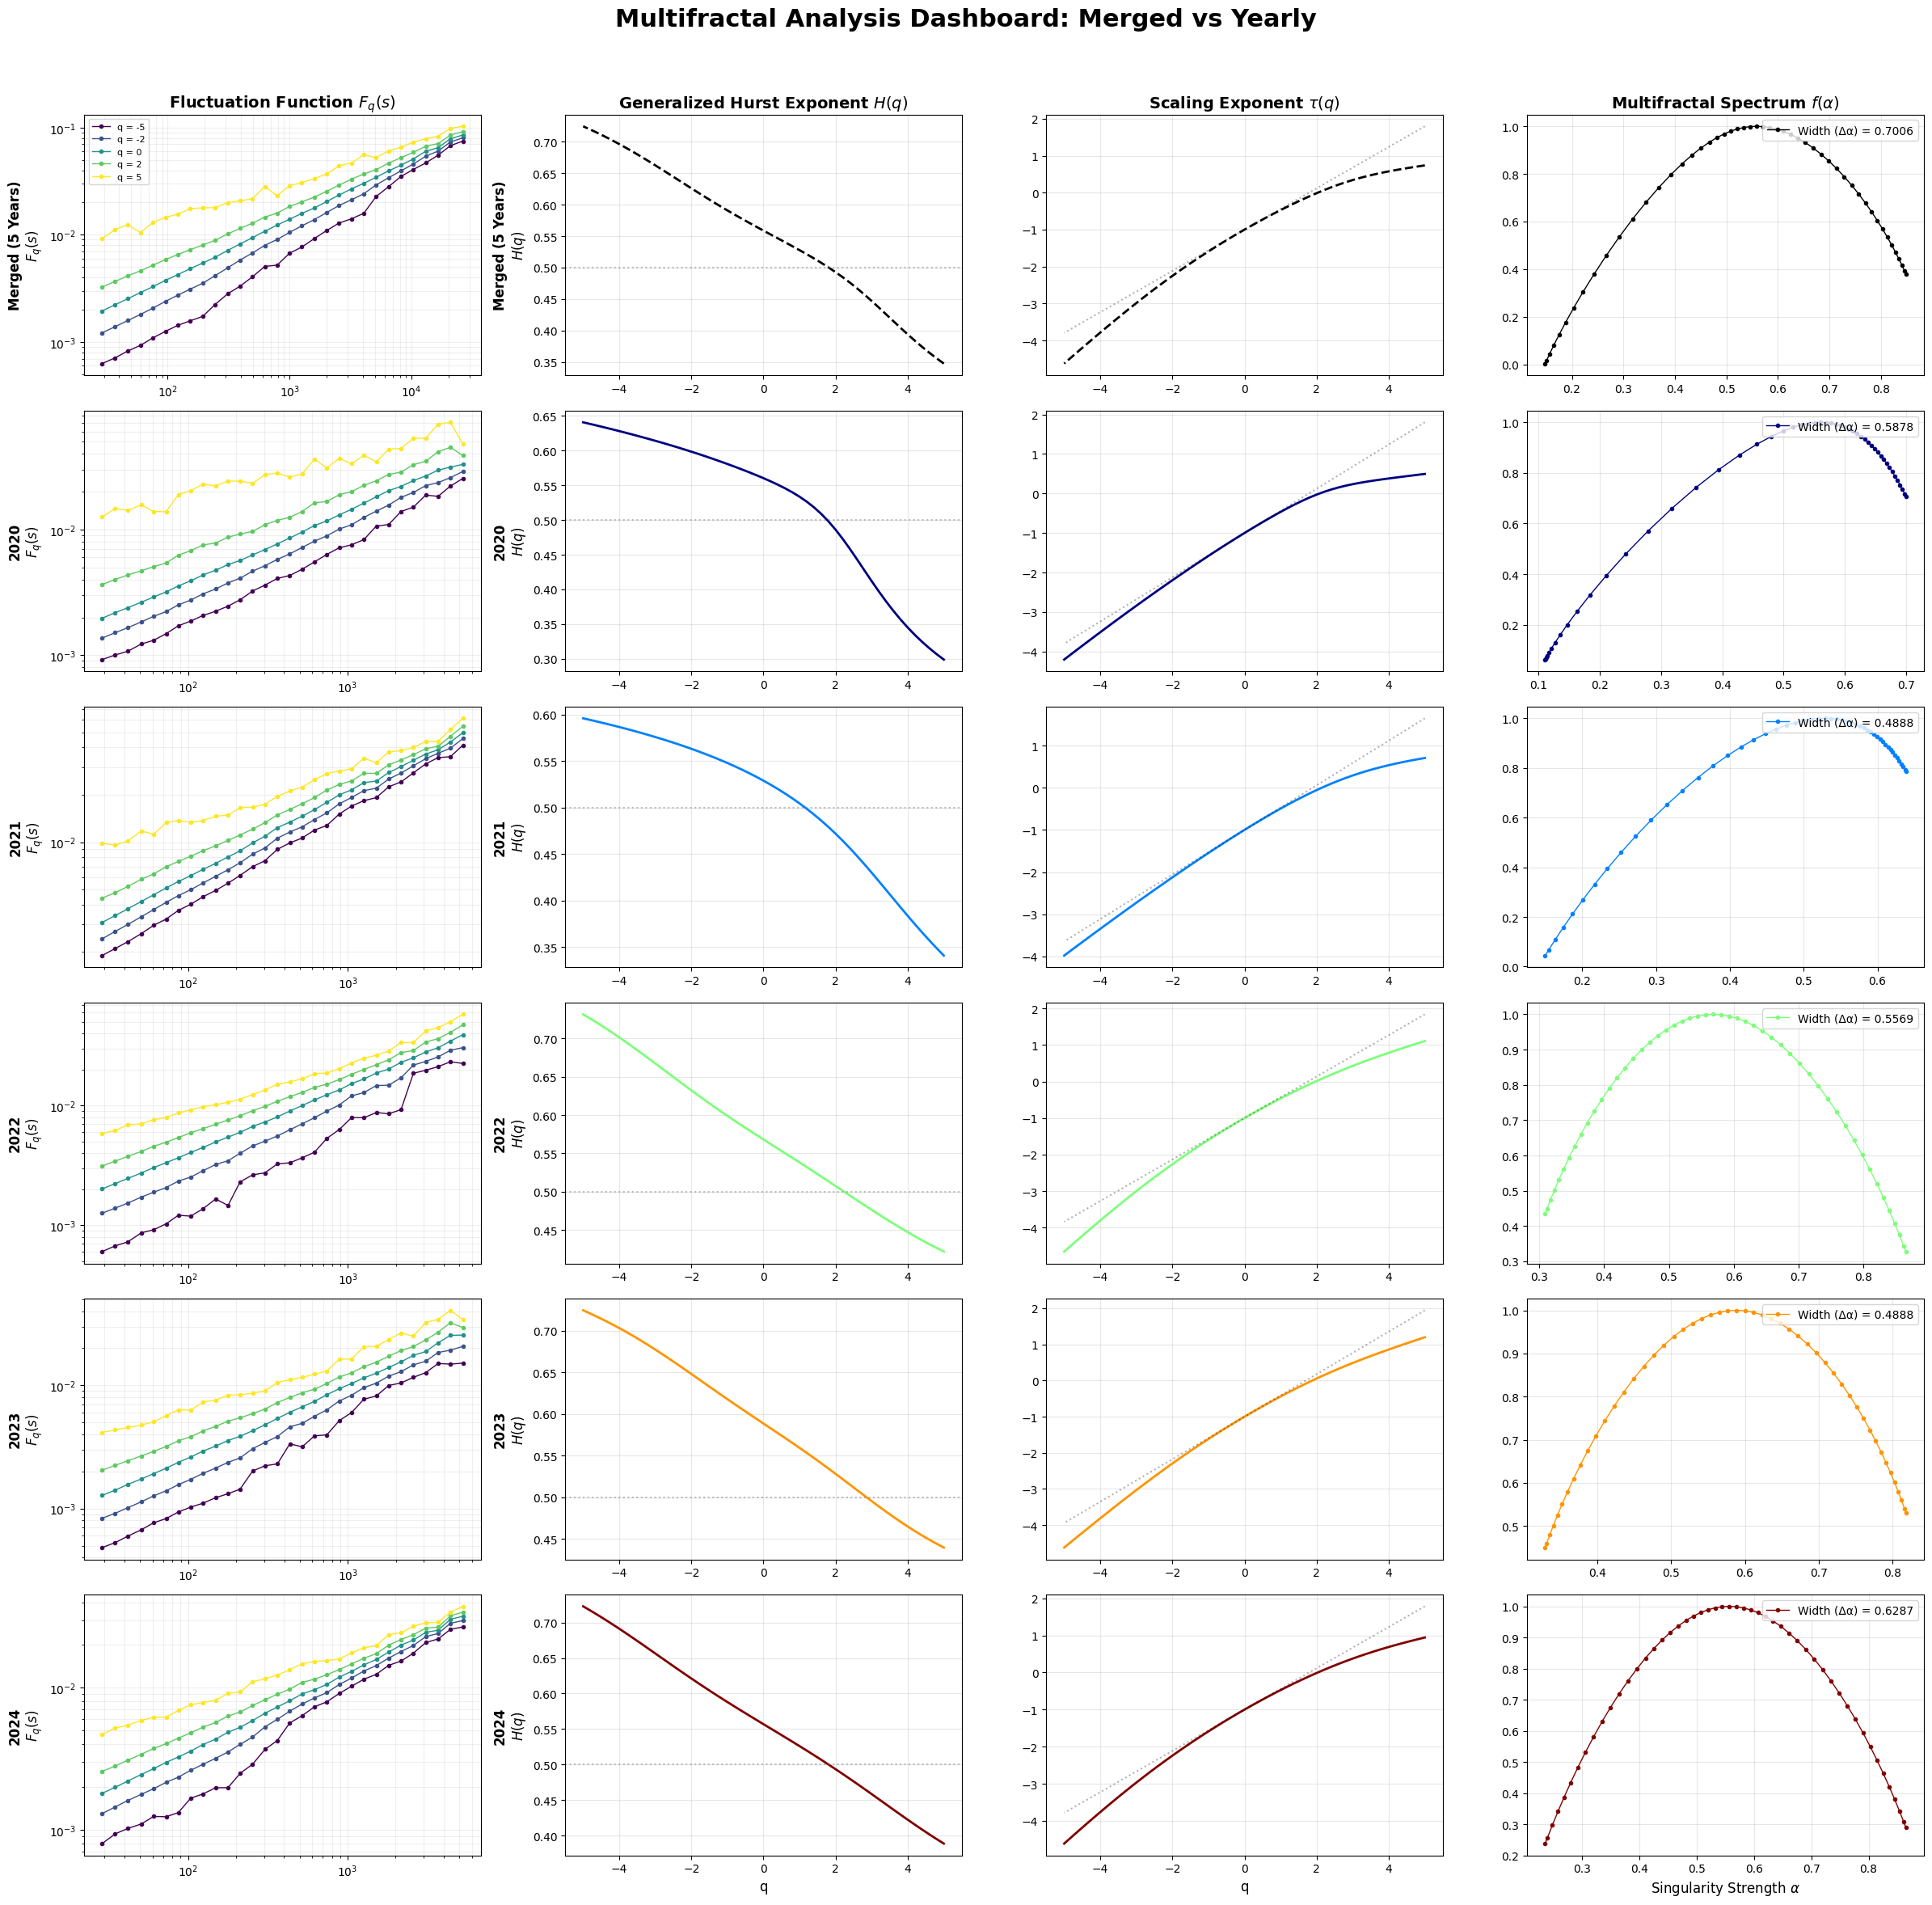

In [7]:
data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("No data")
else:
    print(f"Found {len(files)} files")

datasets = {}

for f in files:
    df = pd.read_csv(f, index_col = 'datetime', parse_dates = True)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close']).diff()
    df.dropna(inplace = True)

    year = str(df.index.year[0])
    datasets[year] = df['close']
    print(f"  -> Loaded {year}")

df_all = pd.concat([pd.read_csv(f, index_col = 'datetime', parse_dates = True) for f in files]).sort_index()
if 'return' not in df_all.columns: df_all['return'] = np.log(df_all['close']).diff()
df_all.dropna(inplace = True)
datasets['Merged (5 Years)'] = df_all['close']

keys = sorted([k for k in datasets.keys() if 'Merged' not in k])
keys.insert(0, 'Merged (5 Years)')

q_list = np.linspace(5, -5, 51)
results = {}

print("\n Running MFDFA")
for name in keys:
    res = compute_spectrum(datasets[name], q_list)
    if res: results[name] = res
    print(f"   -> Analyzed {name}")
fig, axes = plt.subplots(len(keys), 4, figsize=(24, 24))
    
    # 전체 제목
plt.subplots_adjust(top=0.95, wspace = 0.3, hspace = 0.4)
fig.suptitle('Multifractal Analysis Dashboard: Merged vs Yearly', fontsize=22, fontweight='bold')
    
    # 색상 맵 (Merged는 검정, 연도는 다채롭게)
cmap = plt.cm.jet(np.linspace(0, 1, len(keys)-1))
q_plots = [-5, -2, 0, 2, 5]
colors_q = plt.cm.viridis(np.linspace(0, 1, len(q_plots)))
    
for i, name in enumerate(keys):
    res = results[name]
        
        # 색상 설정
    if 'Merged' in name:
        color = 'black'
        style = '--'
    else:
        color = cmap[i-1]
        style = '-'
        
    ax0 = axes[i, 0]
    for j, qv in enumerate(q_plots):
        idx = np.argmin(np.abs(q_list - qv))
        ax0.loglog(res['scales'], res['F_q_s'][idx, :], 'o-',
                   color = colors_q[j], markersize = 3, linewidth = 1, label = f'q = {qv}')
        
    ax0.grid(True, which = 'both', alpha = 0.2)
    ax0.set_ylabel(f"{name}\n$F_q(s)$", fontsize = 12, fontweight = 'bold')
    
    if i == 0:
        ax0.set_title("Fluctuation Function $F_q(s)$", fontsize = 14, fontweight = 'bold')
        ax0.legend(fontsize = 8, loc = 'upper left')
            
        # --- (Col 1) H(q) ---
    ax1 = axes[i, 1]
    ax1.plot(q_list, res['H_q'], linestyle=style, color=color, linewidth=2)
    ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel(f"{name}\n$H(q)$", fontsize=12, fontweight='bold')
    if i == 0: ax1.set_title("Generalized Hurst Exponent $H(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 2) tau(q) ---
    ax2 = axes[i, 2]
    ax2.plot(q_list, res['tau_q'], linestyle=style, color=color, linewidth=2)
        
        # Monofractal Reference Line (비교용 점선)
    h2 = res['H_q'][len(q_list)//2] # q=0 근처의 H값 사용
    ax2.plot(q_list, q_list * h2 - 1, 'k:', alpha=0.3, label='Linear Fit')
        
    ax2.grid(True, alpha=0.3)
    if i == 0: ax2.set_title("Scaling Exponent $\\tau(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 3) f(alpha) ---
    ax3 = axes[i, 3]
        # 스펙트럼 너비(Width) 표시
    label_txt = f"Width (Δα) = {res['delta_alpha']:.4f}"
    ax3.plot(res['alpha'], res['f_alpha'], 'o-', markersize=3, color=color, linewidth=1, label=label_txt)
        
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right', fontsize=10, frameon=True)
    if i == 0: ax3.set_title("Multifractal Spectrum $f(\\alpha)$", fontsize=14, fontweight='bold')
        
        # X축 라벨은 맨 마지막 행에만 표시
    if i == len(keys) - 1:
        ax1.set_xlabel('q', fontsize=12)
        ax2.set_xlabel('q', fontsize=12)
        ax3.set_xlabel('Singularity Strength $\\alpha$', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
def plot_results_by_year(eval_df):
    # 스타일 설정
    sns.set_style("whitegrid")
    plt.rcParams['axes.unicode_minus'] = False
    
    # 인덱스 확인
    if not isinstance(eval_df.index, pd.DatetimeIndex):
        eval_df.index = pd.to_datetime(eval_df.index)

    # 컬럼 이름 안전장치 (Hybrid_Vol로 계산됐을 경우 Hybrid_Pred로 복사)
    if 'Hybrid_Pred' not in eval_df.columns and 'Hybrid_Vol' in eval_df.columns:
        eval_df['Hybrid_Pred'] = eval_df['Hybrid_Vol']

    years = eval_df.index.year.unique()
    print(f"\n총 {len(years)}개 연도에 대해 그래프 생성을 시작합니다...")

    for year in years:
        year_df = eval_df[eval_df.index.year == year]
        if len(year_df) == 0: continue
            
        print(f"   -> {year}년도 그래프 생성 중... ({len(year_df)} rows)")

        # 캔버스 생성 (4행 1열)
        fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
        
        # (1) Actual
        axes[0].plot(year_df.index, year_df['Future_Vol_24h'], color='black', linewidth=1, label='Actual')
        axes[0].set_title(f'[{year}] 1. Actual Volatility', fontsize=14, fontweight='bold')
        axes[0].legend(loc='upper right')
        
        # (2) Base Model
        axes[1].plot(year_df.index, year_df['Base_Vol'], color='blue', linestyle='--', linewidth=1, label='GARCH-MIDAS')
        axes[1].set_title(f'[{year}] 2. Base Model Prediction', fontsize=14, fontweight='bold')
        axes[1].legend(loc='upper right')
        
        # (3) Hybrid Model
        axes[2].plot(year_df.index, year_df['Hybrid_Pred'], color='red', linewidth=1, label='Hybrid LSTM')
        axes[2].set_title(f'[{year}] 3. Hybrid Model Prediction', fontsize=14, fontweight='bold')
        axes[2].legend(loc='upper right')
        
        # (4) Residual Analysis
        target_res = year_df['Future_Vol_24h'] - year_df['Base_Vol']
        pred_res = year_df['Hybrid_Pred'] - year_df['Base_Vol']
        
        axes[3].plot(year_df.index, target_res, color='gray', alpha=0.5, label='Actual Error')
        axes[3].plot(year_df.index, pred_res, color='red', alpha=0.8, linewidth=1, label='Predicted Error')
        axes[3].axhline(0, color='black', linestyle=':', linewidth=1)
        axes[3].set_title(f'[{year}] 4. Residual Analysis', fontsize=14, fontweight='bold')
        axes[3].legend(loc='upper right')
        
        plt.tight_layout()
        
        # 파일 저장
        save_path = f"result_graph_{year}.png"
        plt.savefig(save_path, dpi=100) # 속도를 위해 dpi 100 권장
        plt.close(fig) # 메모리 해제 (필수!)
        
        print(f"저장 완료: {save_path}")

    print("\n모든 연도 그래프 저장이 완료되었습니다!")

In [9]:
# 2021년 데이터 로드
path_10m = "data/BTCUSDT_10m_2021.csv"

df_10m = pd.read_csv(path_10m)

df_10m.columns = [c.lower().strip() for c in df_10m.columns]

date_cols = None
for col in ['timestamp', 'date', 'datetime', 'open_time']:
    if col in df_10m.columns:
        date_col = col
        break
    
if date_col:
    df_10m[date_col] = pd.to_datetime(df_10m[date_col])
    df_10m.set_index(date_col, inplace = True)
else:
    raise KeyError("Can't find date columns")

if 'return' not in df_10m.columns:
    df_10m['return'] = np.log(df_10m['close']).diff() * 100
    
df_10m.dropna(inplace = True)

print(f"데이터 준비 완료. Shape: {df_10m.shape}")
print(f"기간: {df_10m.index.min()} ~ {df_10m.index.max()}")

# MF-DFA 지표 계산
WINDOW_SIZE = 30 * 144

mfdfa_2021 = mfdfa_features(df_10m['close'], DEVICE, window = WINDOW_SIZE, step = 1)

print(f"Complete Calculation of MF-DFA: {mfdfa_2021.shape}")
print("    -> Included index:", mfdfa_2021.columns.tolist())

데이터 준비 완료. Shape: (52559, 6)
기간: 2021-01-01 00:10:00+00:00 ~ 2021-12-31 23:50:00+00:00
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 48238/48238 [01:25<00:00, 566.33it/s]

Complete Calculation of MF-DFA: (48192, 3)
    -> Included index: ['delta_H', 'delta_alpha', 'alpha_0']


Compare 3 GARCH-MIDAS Model

Running Scenario: 1. Benchmark (No Exog)
------------------------------------------------------------
[INFO] Base Model Running (Exog: None)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:02,  3.53it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070357
   - Beta  (GARCH) : 0.874935
   - m     (Const) : 0.336203  -> (m^2 used: 0.11303257)
   - Theta (RV_Wgt): 0.051714  -> (theta^2 used: 0.00267433)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376082
   - Min : 0.261503
   - Max : 0.848029
   - First 5 values: [0.47415546 0.69017008 0.65569359 0.64247627 0.62816439]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:00<00:03,  2.40it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.062103
   - Beta  (GARCH) : 0.892231
   - m     (Const) : 0.205532  -> (m^2 used: 0.04224327)
   - Theta (RV_Wgt): 0.064726  -> (theta^2 used: 0.00418941)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.306613
   - Min : 0.190824
   - Max : 1.606568
   - First 5 values: [0.30354634 0.299813   0.29090255 0.28378687 0.2831238 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:03,  1.92it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861684
   - m     (Const) : 0.123979  -> (m^2 used: 0.01537083)
   - Theta (RV_Wgt): 0.074426  -> (theta^2 used: 0.00553919)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543995
   - Min : 0.204963
   - Max : 6.421263
   - First 5 values: [0.30991579 0.31544883 0.30378401 0.2970965  0.28743502]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:02<00:03,  1.52it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096769
   - Beta  (GARCH) : 0.860045
   - m     (Const) : 0.185564  -> (m^2 used: 0.03443395)
   - Theta (RV_Wgt): 0.072410  -> (theta^2 used: 0.00524315)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.408303
   - Min : 0.236699
   - Max : 1.186660
   - First 5 values: [0.52610019 0.50789152 0.52992298 0.5081615  0.49579848]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:03<00:04,  1.22it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.091946
   - Beta  (GARCH) : 0.868026
   - m     (Const) : 0.202385  -> (m^2 used: 0.04095977)
   - Theta (RV_Wgt): 0.070854  -> (theta^2 used: 0.00502036)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.287259
   - Min : 0.171566
   - Max : 1.443002
   - First 5 values: [0.3766217  0.36068586 0.34677221 0.33366462 0.32210066]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:04<00:03,  1.04it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096552
   - Beta  (GARCH) : 0.856998
   - m     (Const) : 0.206718  -> (m^2 used: 0.04273230)
   - Theta (RV_Wgt): 0.068571  -> (theta^2 used: 0.00470200)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281450
   - Min : 0.178202
   - Max : 0.735336
   - First 5 values: [0.30824274 0.30020671 0.29190028 0.28064754 0.28564983]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:06<00:03,  1.14s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102260
   - Beta  (GARCH) : 0.839423
   - m     (Const) : 0.191167  -> (m^2 used: 0.03654491)
   - Theta (RV_Wgt): 0.068644  -> (theta^2 used: 0.00471201)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.315242
   - Min : 0.166204
   - Max : 4.021009
   - First 5 values: [0.23984376 0.25339244 0.2411167  0.24786732 0.24966366]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:07<00:02,  1.30s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115619
   - Beta  (GARCH) : 0.824650
   - m     (Const) : 0.200990  -> (m^2 used: 0.04039709)
   - Theta (RV_Wgt): 0.067519  -> (theta^2 used: 0.00455888)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.276555
   - Min : 0.185705
   - Max : 2.138450
   - First 5 values: [0.24055312 0.23378143 0.23521443 0.22974374 0.2455124 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:09<00:01,  1.44s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128878
   - Beta  (GARCH) : 0.784344
   - m     (Const) : 0.216142  -> (m^2 used: 0.04671723)
   - Theta (RV_Wgt): 0.063984  -> (theta^2 used: 0.00409389)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.270550
   - Min : 0.183098
   - Max : 1.174743
   - First 5 values: [0.2431086  0.28121842 0.28172224 0.26733717 0.26086417]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136249
   - Beta  (GARCH) : 0.772030
   - m     (Const) : 0.205650  -> (m^2 used: 0.04229174)
   - Theta (RV_Wgt): 0.065344  -> (theta^2 used: 0.00426990)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296673
   - Min : 0.183403
   - Max : 2.781356
   - First 5 values: [0.29088784 0.32569665 0.30845376 0.30897073 0.30594731]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1182.07it/s]


Final Data shape: (43632, 728)

 >> Running AI Model: LSTM

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:50<00:00, 230.95it/s]


RMSE Base: 2.3627 -> Hybrid: 1.7469 (26.06% Improved)


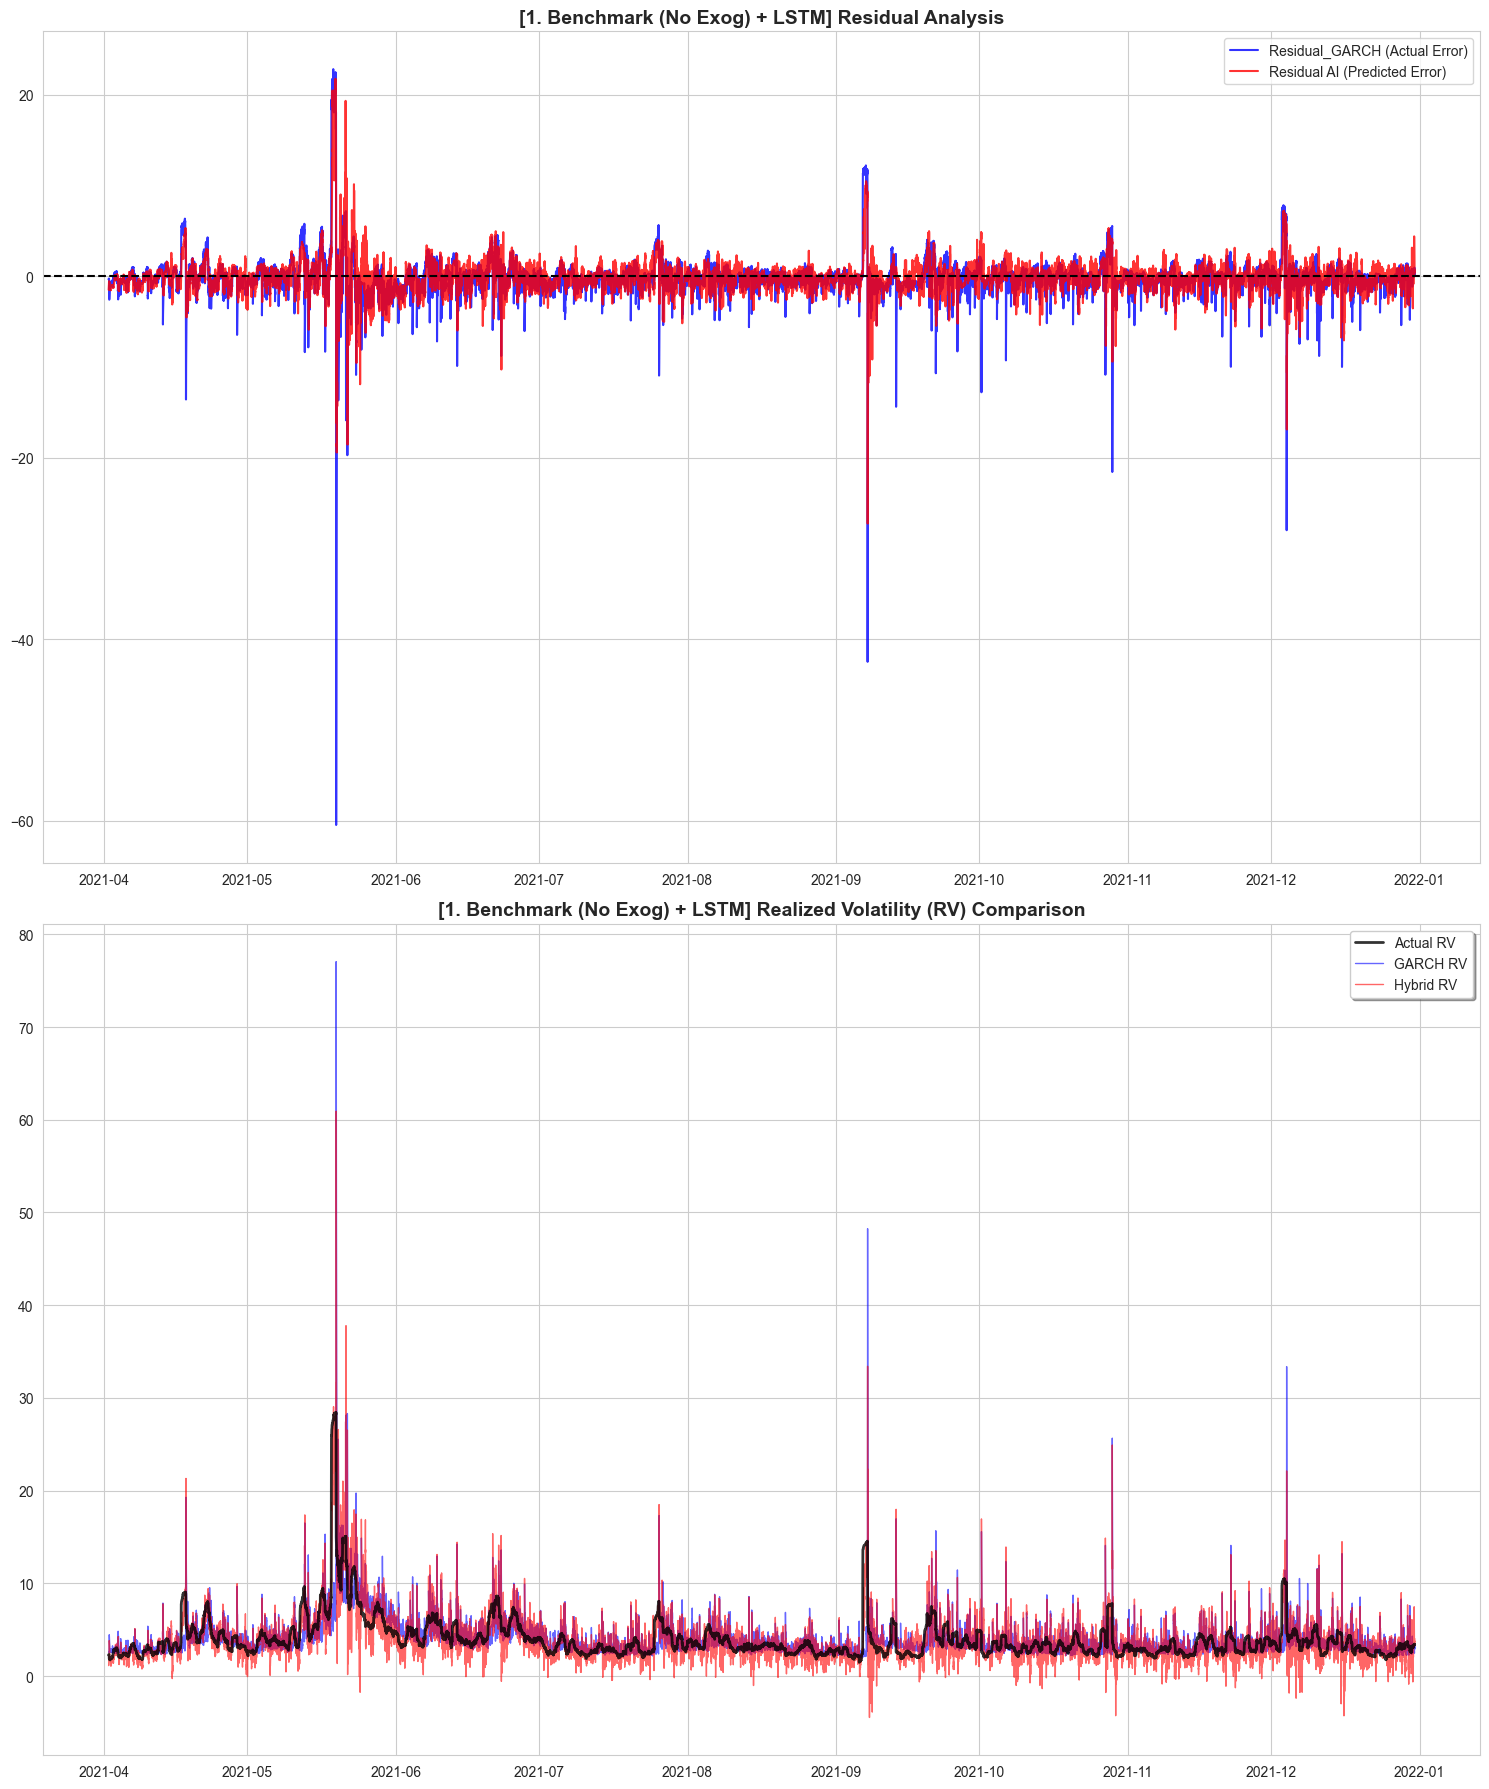


 >> Running AI Model: Bi-LSTM

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [05:00<00:00, 130.97it/s]


RMSE Base: 2.3627 -> Hybrid: 1.6470 (30.29% Improved)


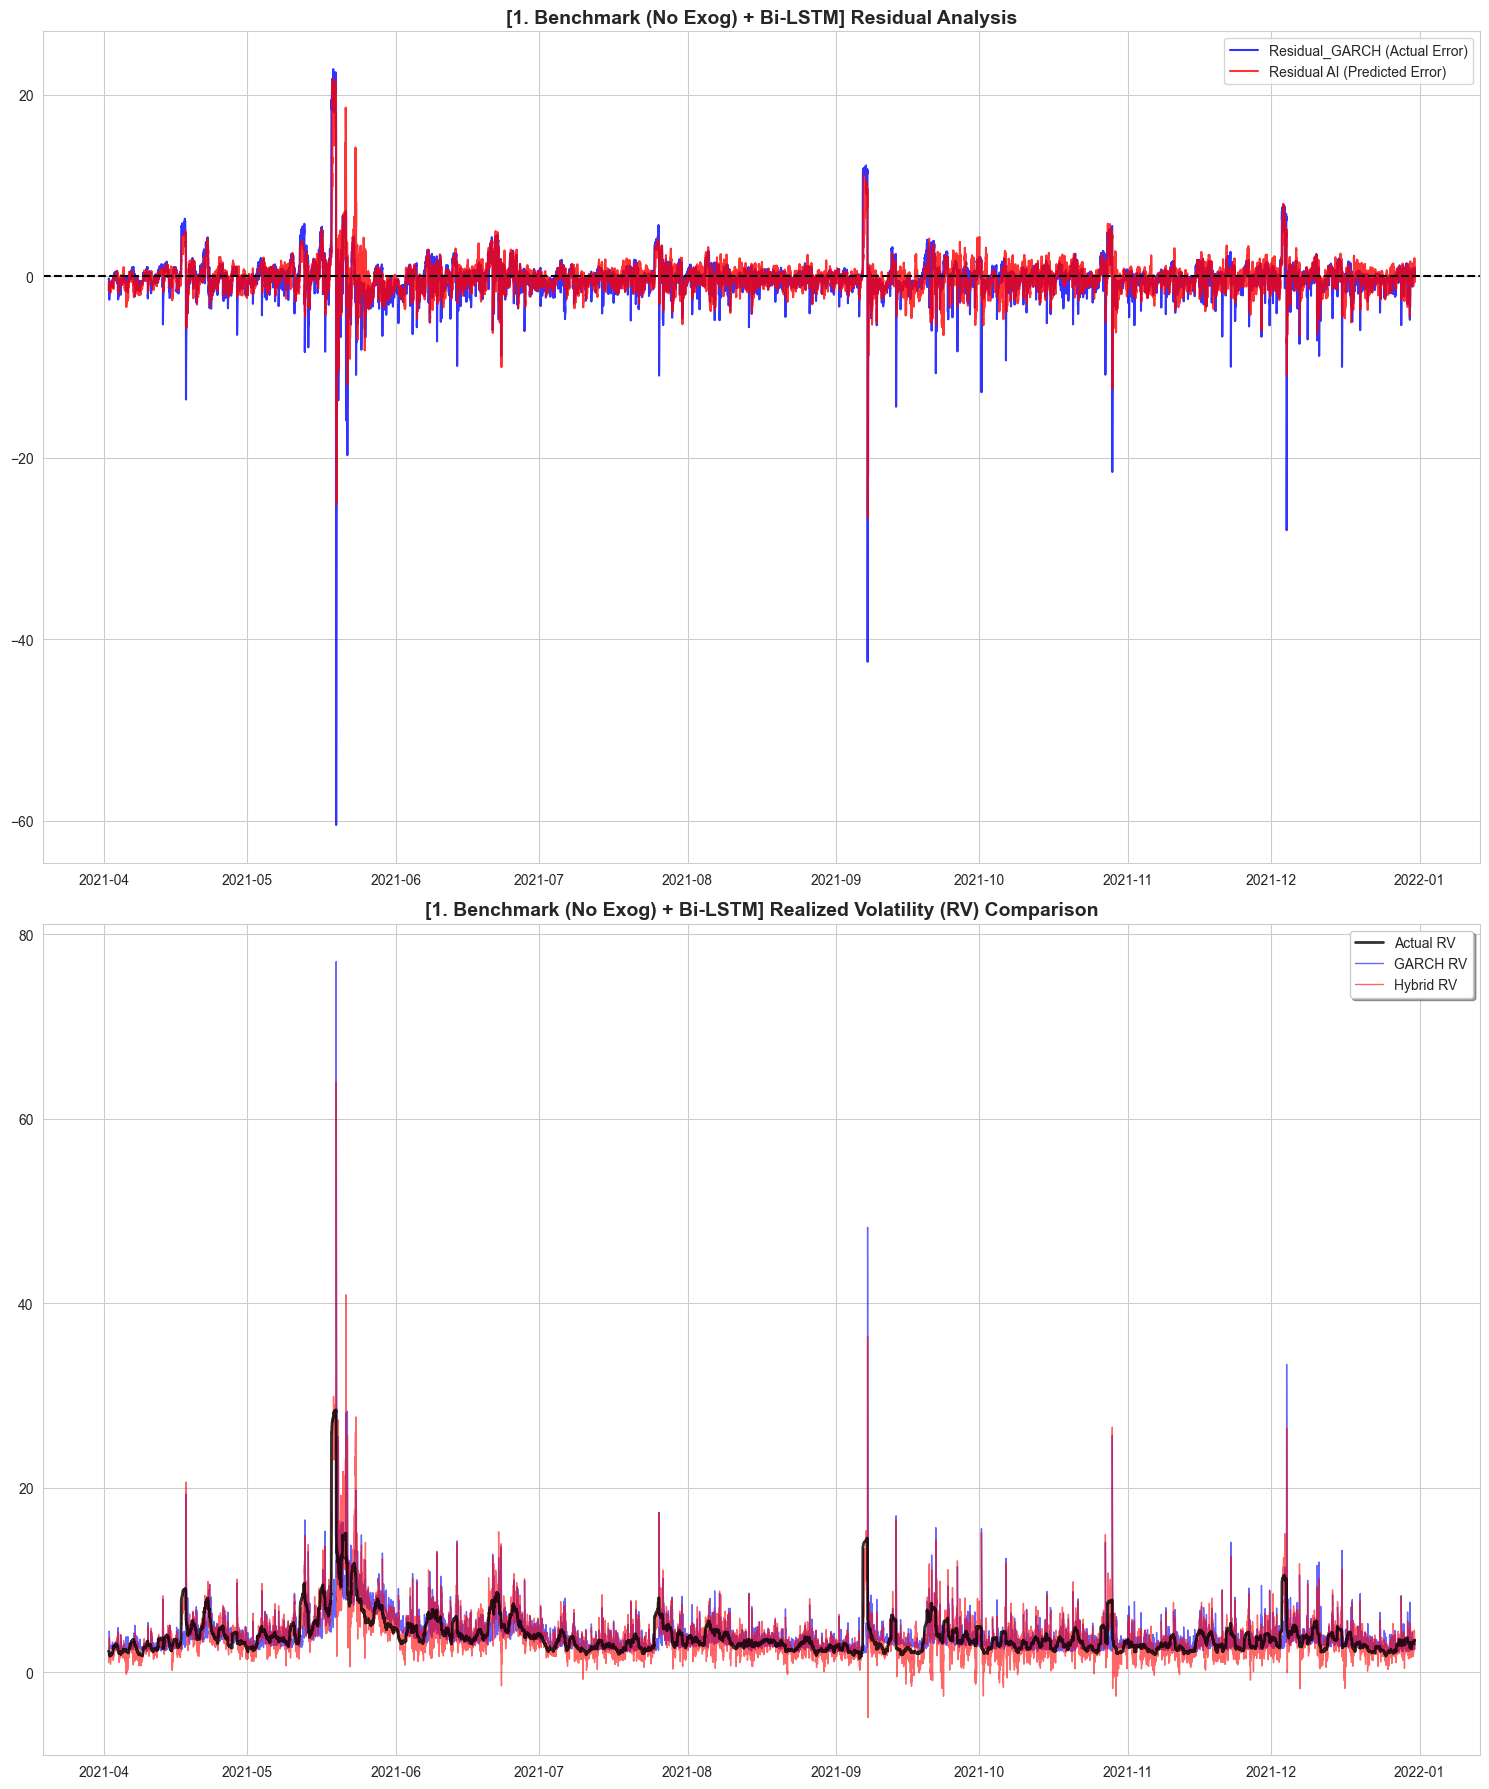


 >> Running AI Model: GRU

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:24<00:00, 272.22it/s]


RMSE Base: 2.3627 -> Hybrid: 1.7561 (25.67% Improved)


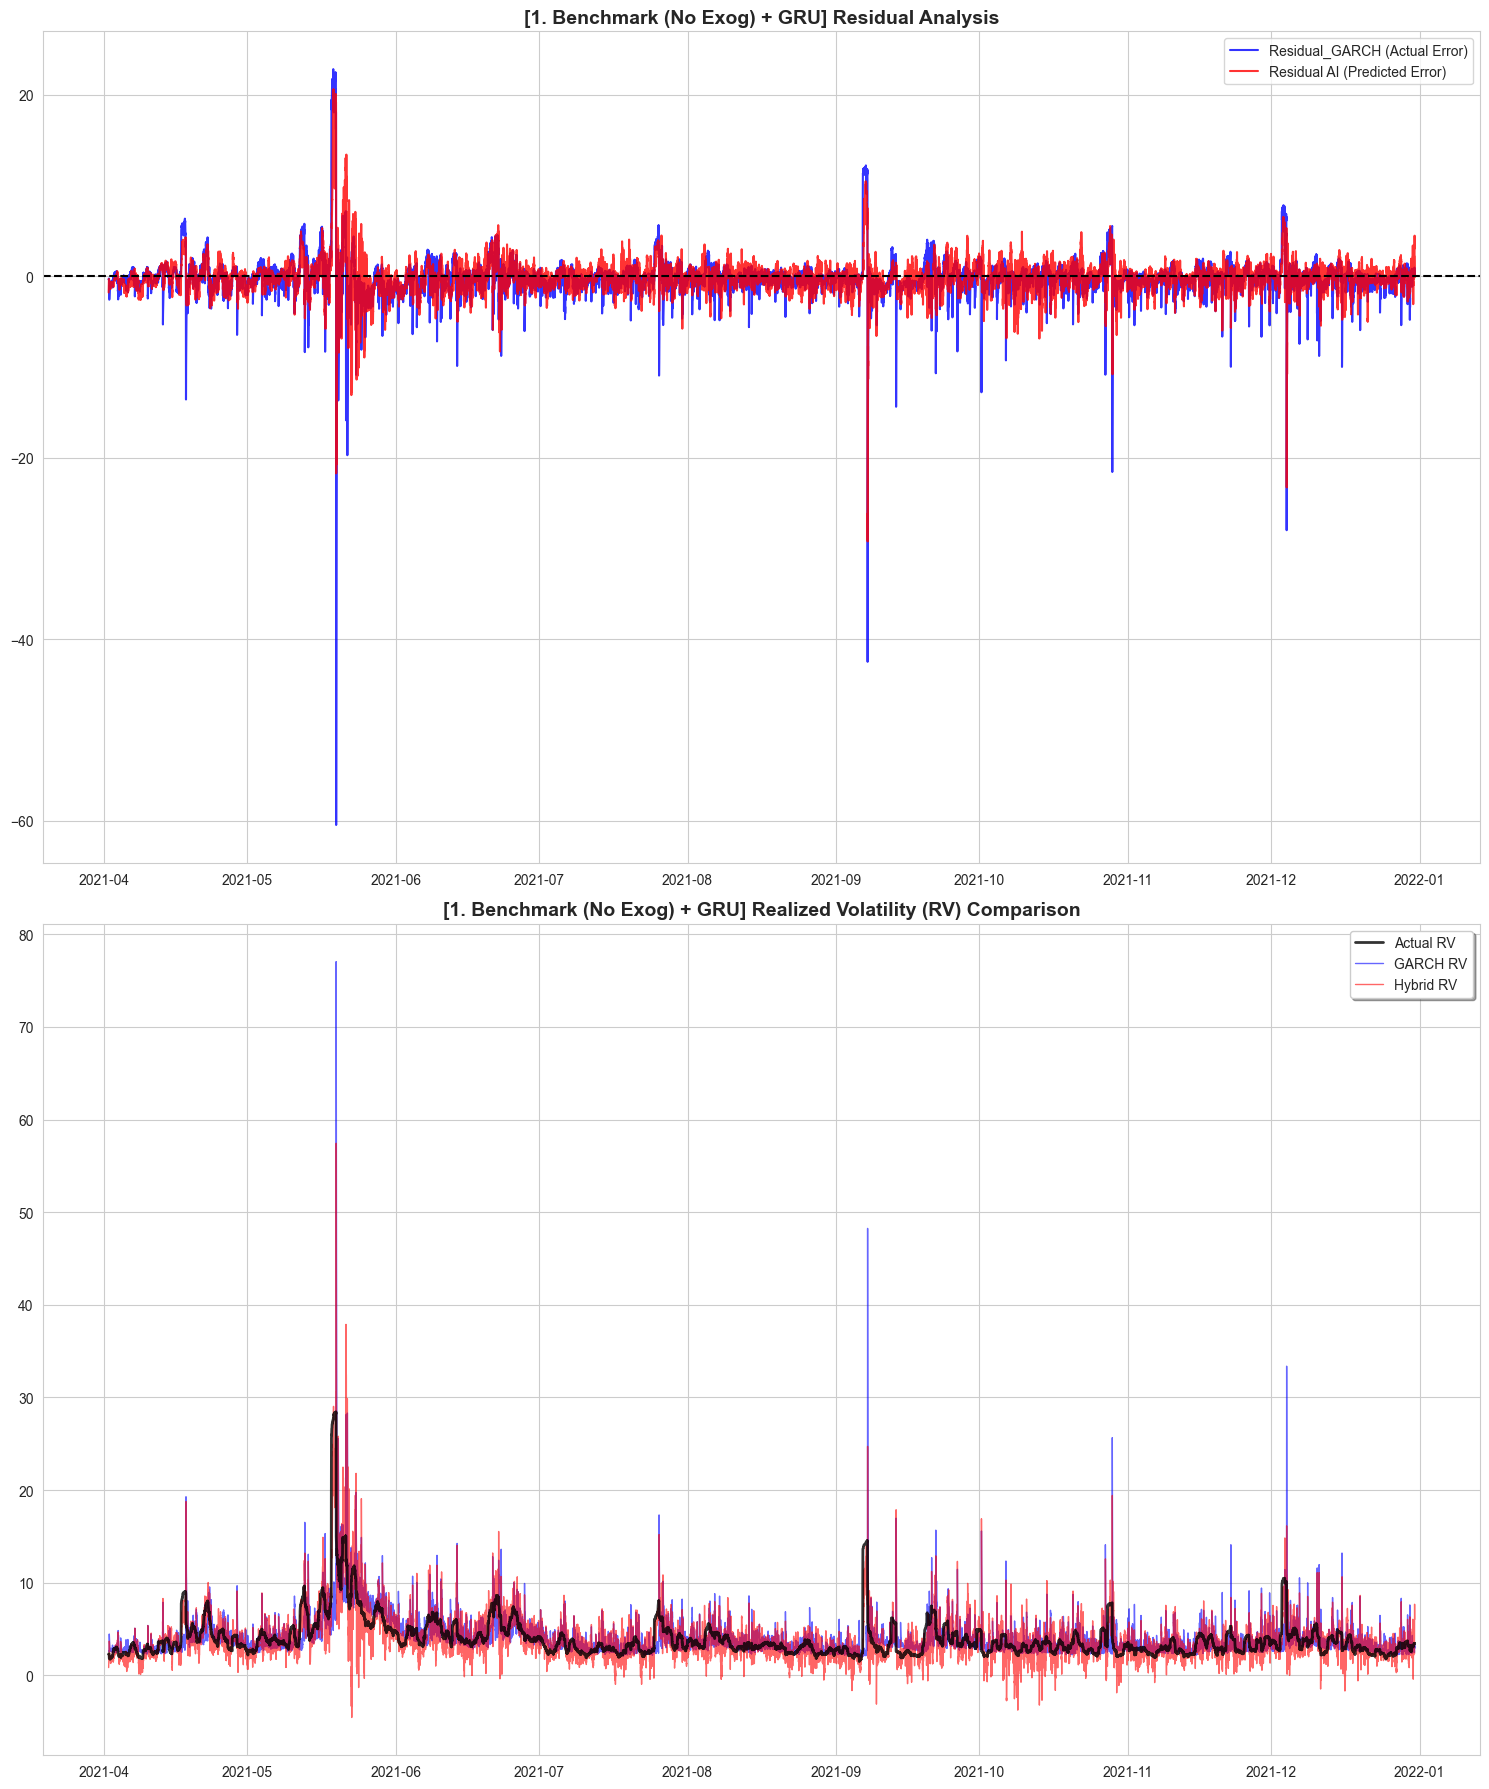


 >> Running AI Model: Bi-GRU

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [04:09<00:00, 157.72it/s]


RMSE Base: 2.3627 -> Hybrid: 1.5146 (35.90% Improved)


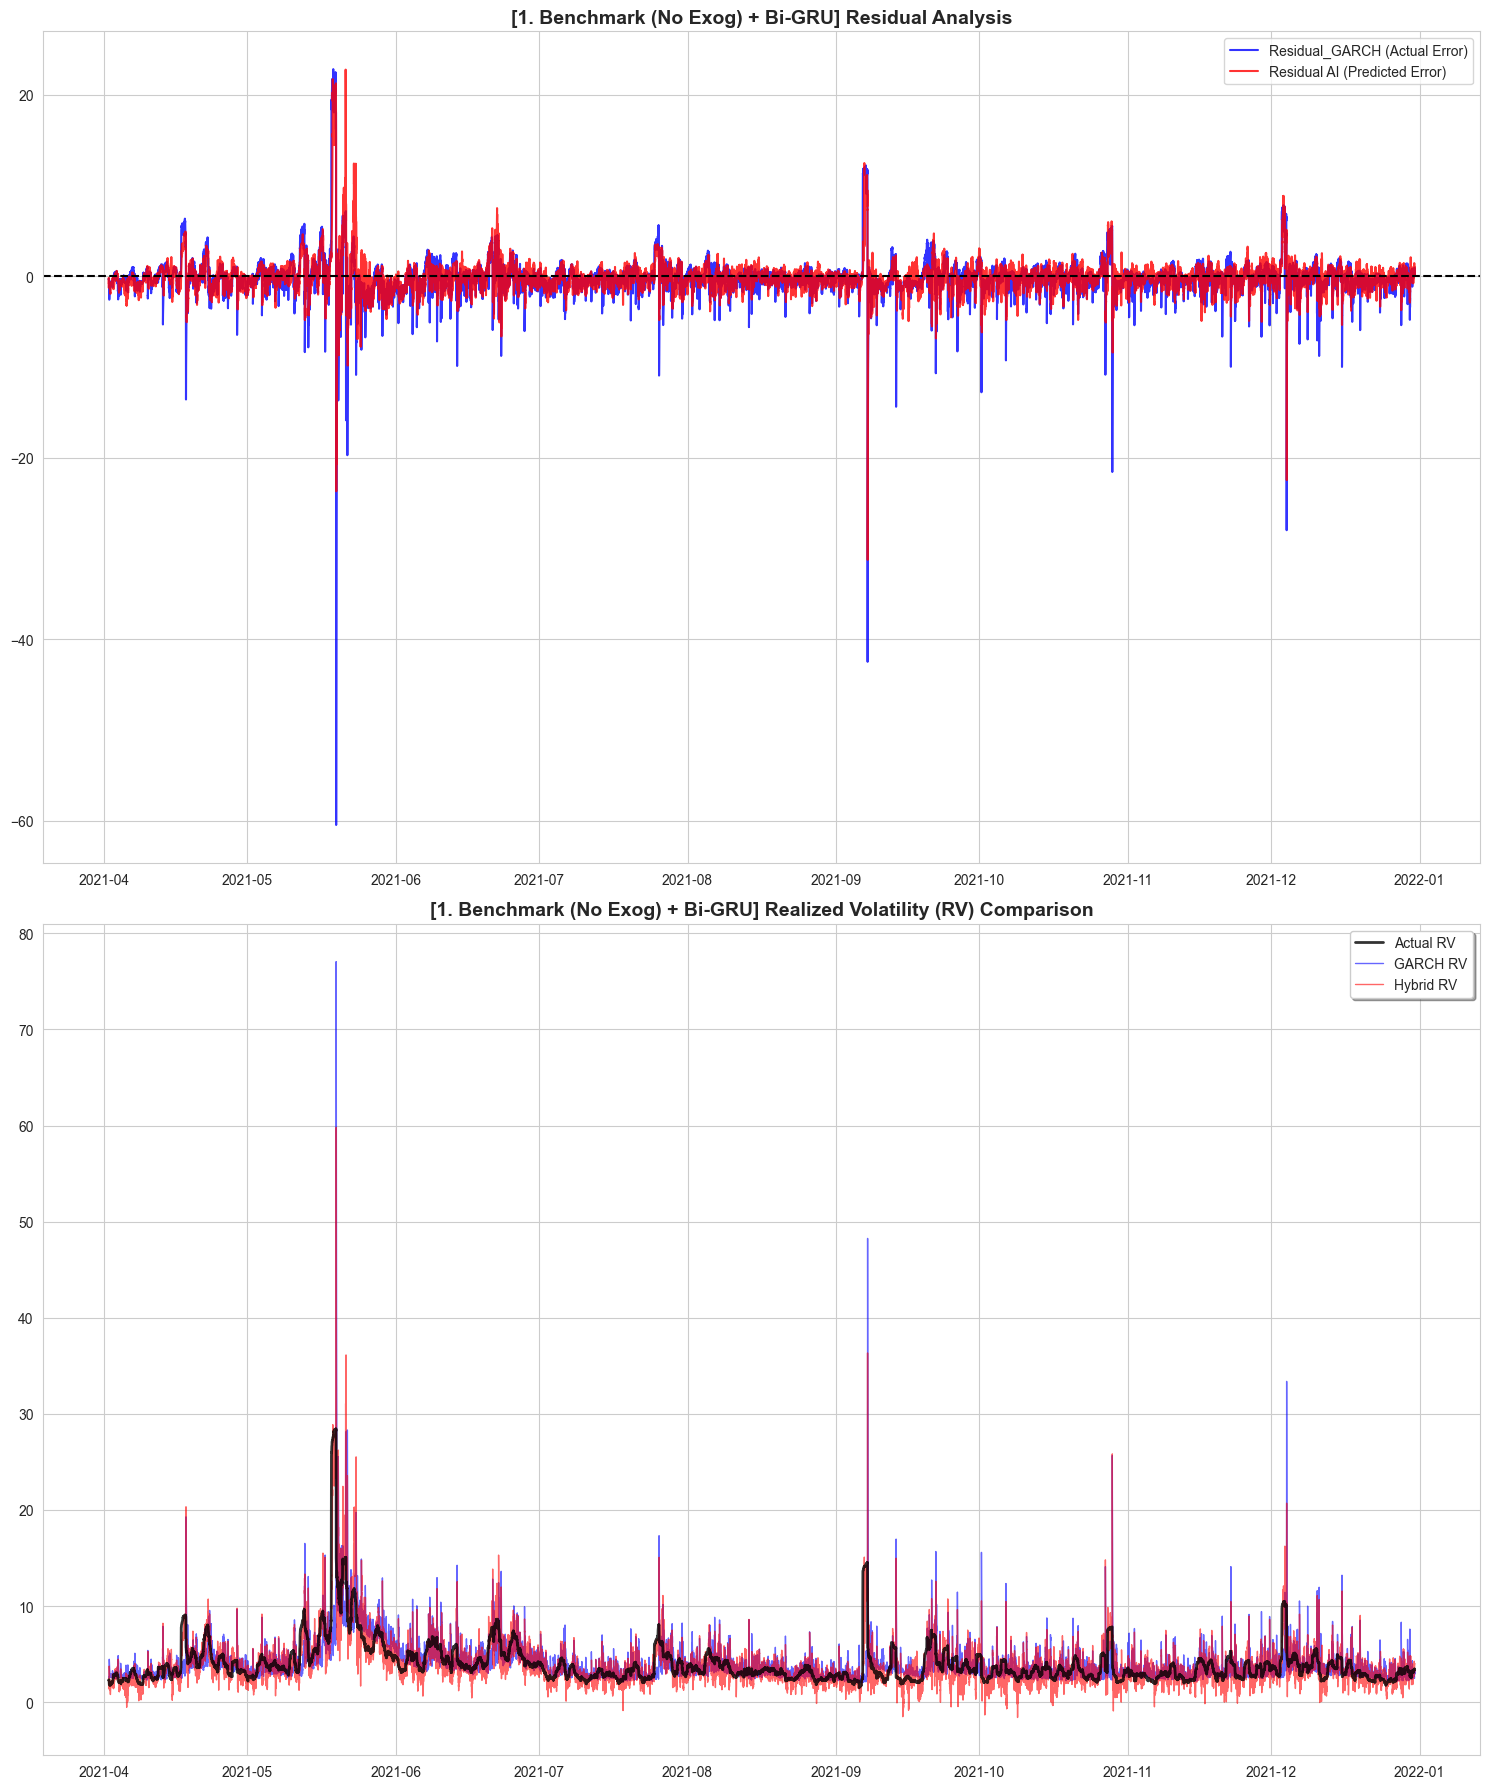


 >> Running AI Model: Ridge

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [09:27<00:00, 69.21it/s]


RMSE Base: 2.3627 -> Hybrid: 3.4888 (-47.67% Improved)


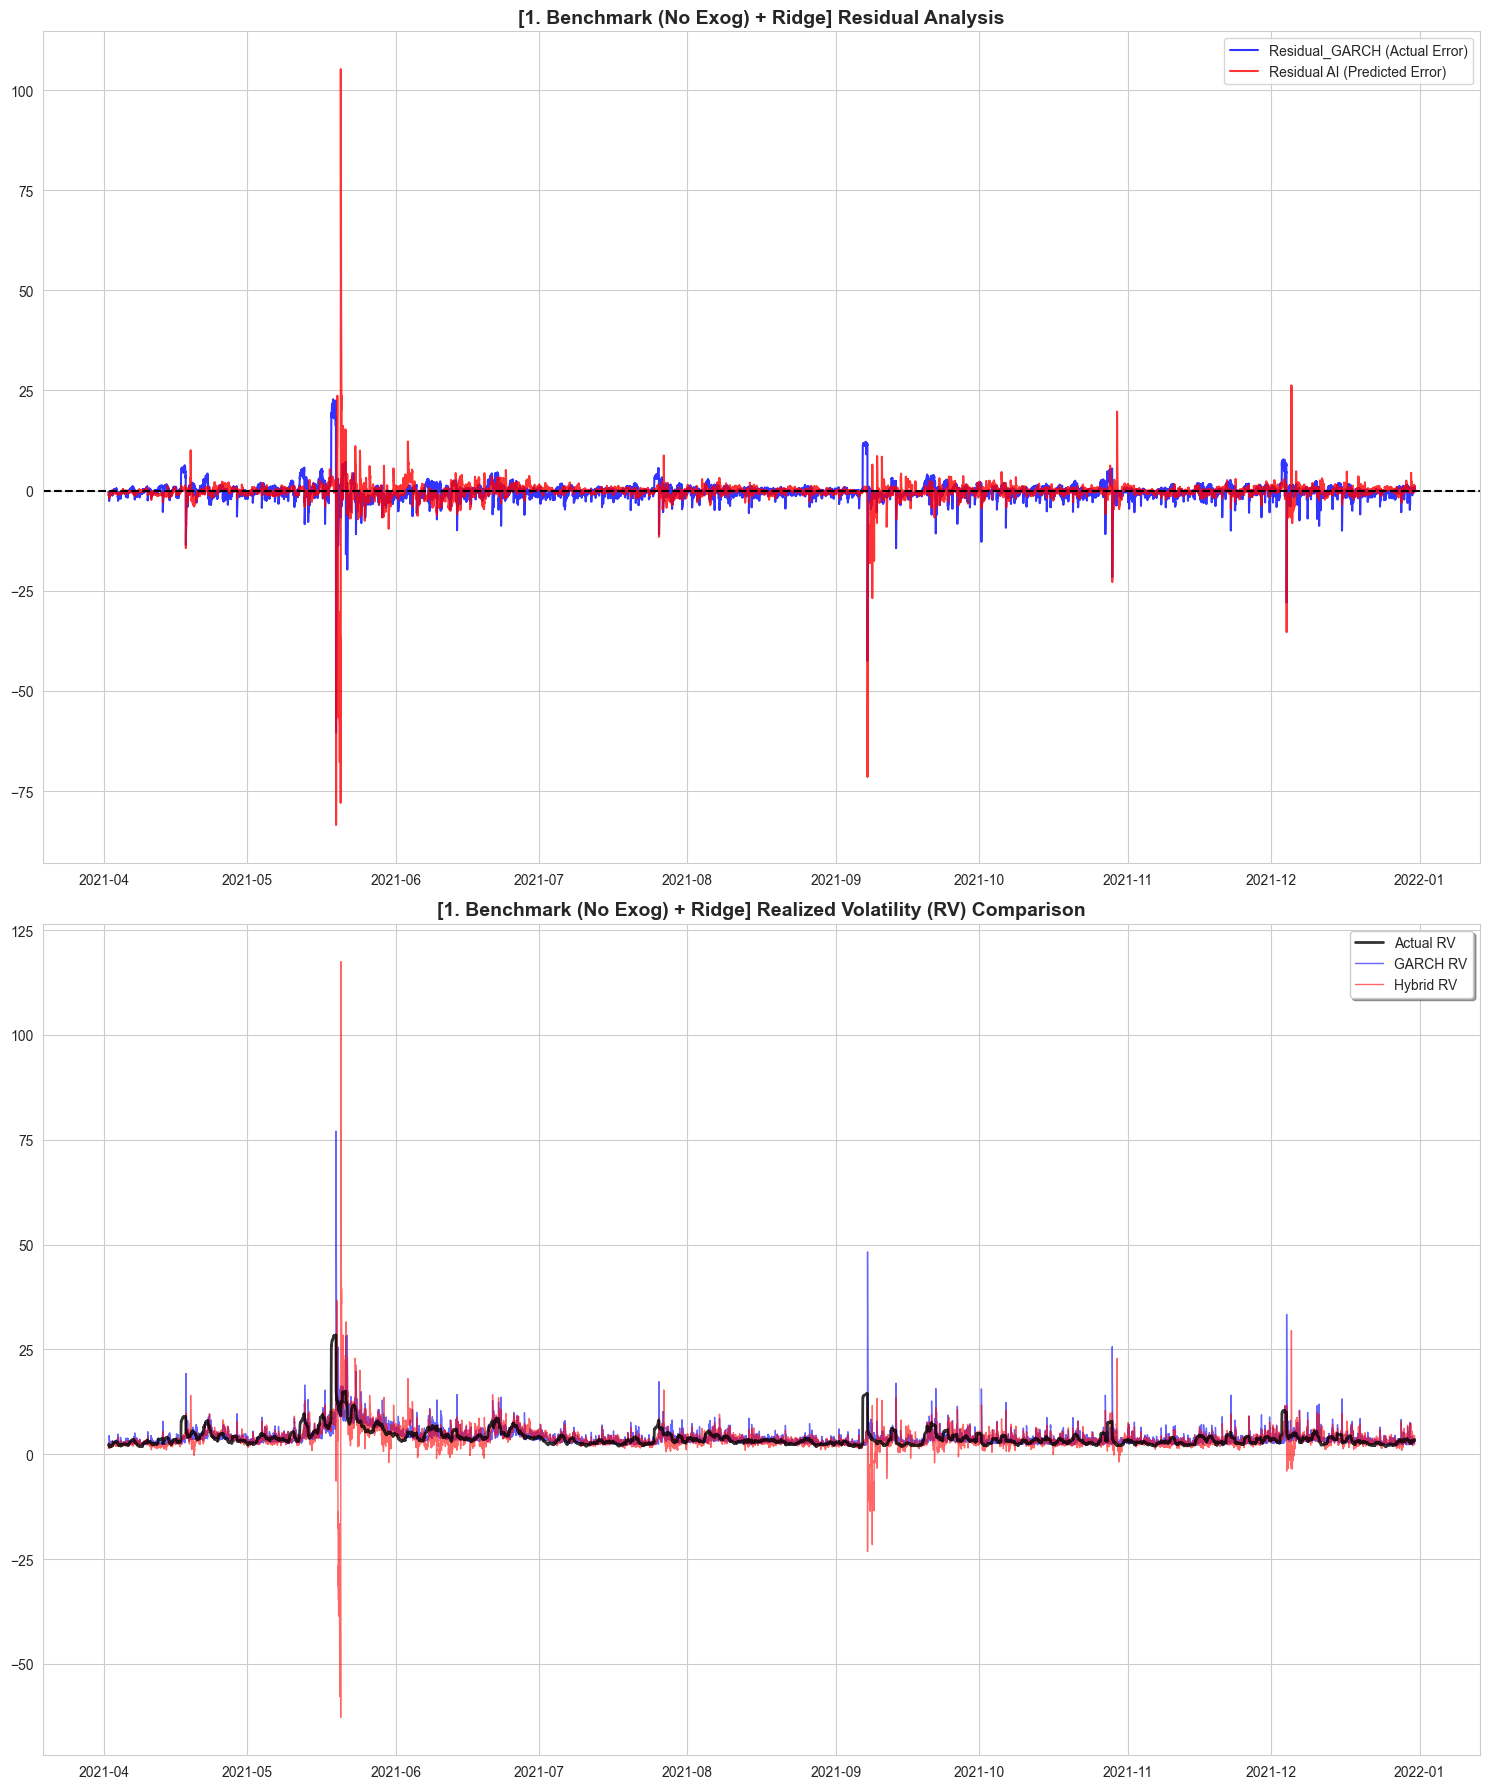


Running Scenario: 2. Hybrid (with Delta H)
------------------------------------------------------------
[INFO] Base Model Running (Exog: delta_H)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:04,  2.15it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070091
   - Beta  (GARCH) : 0.871729
   - m     (Const) : 0.198577  -> (m^2 used: 0.03943296)
   - Theta (RV_Wgt): 0.056993  -> (theta^2 used: 0.00324821)
   - W_Exog(exog_x): 0.523074  -> (w^2 used: 0.27360602)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.377737
   - Min : 0.251858
   - Max : 0.846031
   - First 5 values: [0.48179433 0.69485575 0.66023916 0.64681892 0.63239454]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061719
   - Beta  (GARCH) : 0.891641
   - m     (Const) : 0.108098  -> (m^2 used: 0.01168509)
   - Theta (RV_Wgt): 0.065459  -> (theta^2 used: 0.00428488)
   - W_Exog(exog_x): 0.362040  -> (w^2 used: 0.13107311)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.302600
   - Min : 0.180107
   - Max : 1.599681
   - First 5 values: [0.29957186 0.29581788 0.28684786 0.27968688 0.27903383]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087343
   - Beta  (GARCH) : 0.861706
   - m     (Const) : 0.117793  -> (m^2 used: 0.01387510)
   - Theta (RV_Wgt): 0.074237  -> (theta^2 used: 0.00551107)
   - W_Exog(exog_x): 0.102133  -> (w^2 used: 0.01043110)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.544174
   - Min : 0.205845
   - Max : 6.419716
   - First 5 values: [0.31044161 0.31595478 0.30430841 0.29762971 0.28798523]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.05s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096845
   - Beta  (GARCH) : 0.858459
   - m     (Const) : 0.060421  -> (m^2 used: 0.00365069)
   - Theta (RV_Wgt): 0.069765  -> (theta^2 used: 0.00486716)
   - W_Exog(exog_x): 0.423497  -> (w^2 used: 0.17934956)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.417339
   - Min : 0.259765
   - Max : 1.191374
   - First 5 values: [0.53372062 0.51553709 0.53711044 0.51545559 0.50313979]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:07,  1.49s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092217
   - Beta  (GARCH) : 0.866041
   - m     (Const) : 0.103102  -> (m^2 used: 0.01063001)
   - Theta (RV_Wgt): 0.067214  -> (theta^2 used: 0.00451769)
   - W_Exog(exog_x): 0.416101  -> (w^2 used: 0.17313994)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285561
   - Min : 0.172185
   - Max : 1.444273
   - First 5 values: [0.37353792 0.35734488 0.34322337 0.32993746 0.31823309]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:08<00:07,  1.85s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097124
   - Beta  (GARCH) : 0.854127
   - m     (Const) : 0.101030  -> (m^2 used: 0.01020712)
   - Theta (RV_Wgt): 0.064773  -> (theta^2 used: 0.00419559)
   - W_Exog(exog_x): 0.431719  -> (w^2 used: 0.18638135)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.280920
   - Min : 0.181070
   - Max : 0.734934
   - First 5 values: [0.30638544 0.2981975  0.28976073 0.27835851 0.28346826]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:11<00:06,  2.11s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102867
   - Beta  (GARCH) : 0.836327
   - m     (Const) : 0.088582  -> (m^2 used: 0.00784679)
   - Theta (RV_Wgt): 0.065308  -> (theta^2 used: 0.00426513)
   - W_Exog(exog_x): 0.407222  -> (w^2 used: 0.16583001)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.326508
   - Min : 0.167515
   - Max : 4.028238
   - First 5 values: [0.24043493 0.25403885 0.24168602 0.24846983 0.25025957]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:12<00:03,  1.96s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115628
   - Beta  (GARCH) : 0.824545
   - m     (Const) : 0.195121  -> (m^2 used: 0.03807217)
   - Theta (RV_Wgt): 0.067223  -> (theta^2 used: 0.00451888)
   - W_Exog(exog_x): 0.113910  -> (w^2 used: 0.01297558)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277386
   - Min : 0.186576
   - Max : 2.138481
   - First 5 values: [0.2422734  0.23554952 0.23697176 0.23154184 0.24719739]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.32s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128903
   - Beta  (GARCH) : 0.784297
   - m     (Const) : 0.200278  -> (m^2 used: 0.04011116)
   - Theta (RV_Wgt): 0.063423  -> (theta^2 used: 0.00402242)
   - W_Exog(exog_x): 0.179014  -> (w^2 used: 0.03204607)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.271919
   - Min : 0.185358
   - Max : 1.175185
   - First 5 values: [0.24376167 0.28177332 0.28226136 0.26788998 0.26142017]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136233
   - Beta  (GARCH) : 0.772050
   - m     (Const) : 0.203528  -> (m^2 used: 0.04142379)
   - Theta (RV_Wgt): 0.065279  -> (theta^2 used: 0.00426132)
   - W_Exog(exog_x): 0.063402  -> (w^2 used: 0.00401984)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296755
   - Min : 0.183598
   - Max : 2.781206
   - First 5 values: [0.29089162 0.32570109 0.30846527 0.30898545 0.30596511]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1461.41it/s]


Final Data shape: (43632, 728)

 >> Running AI Model: LSTM

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:50<00:00, 229.98it/s]


RMSE Base: 2.3600 -> Hybrid: 1.9015 (19.43% Improved)


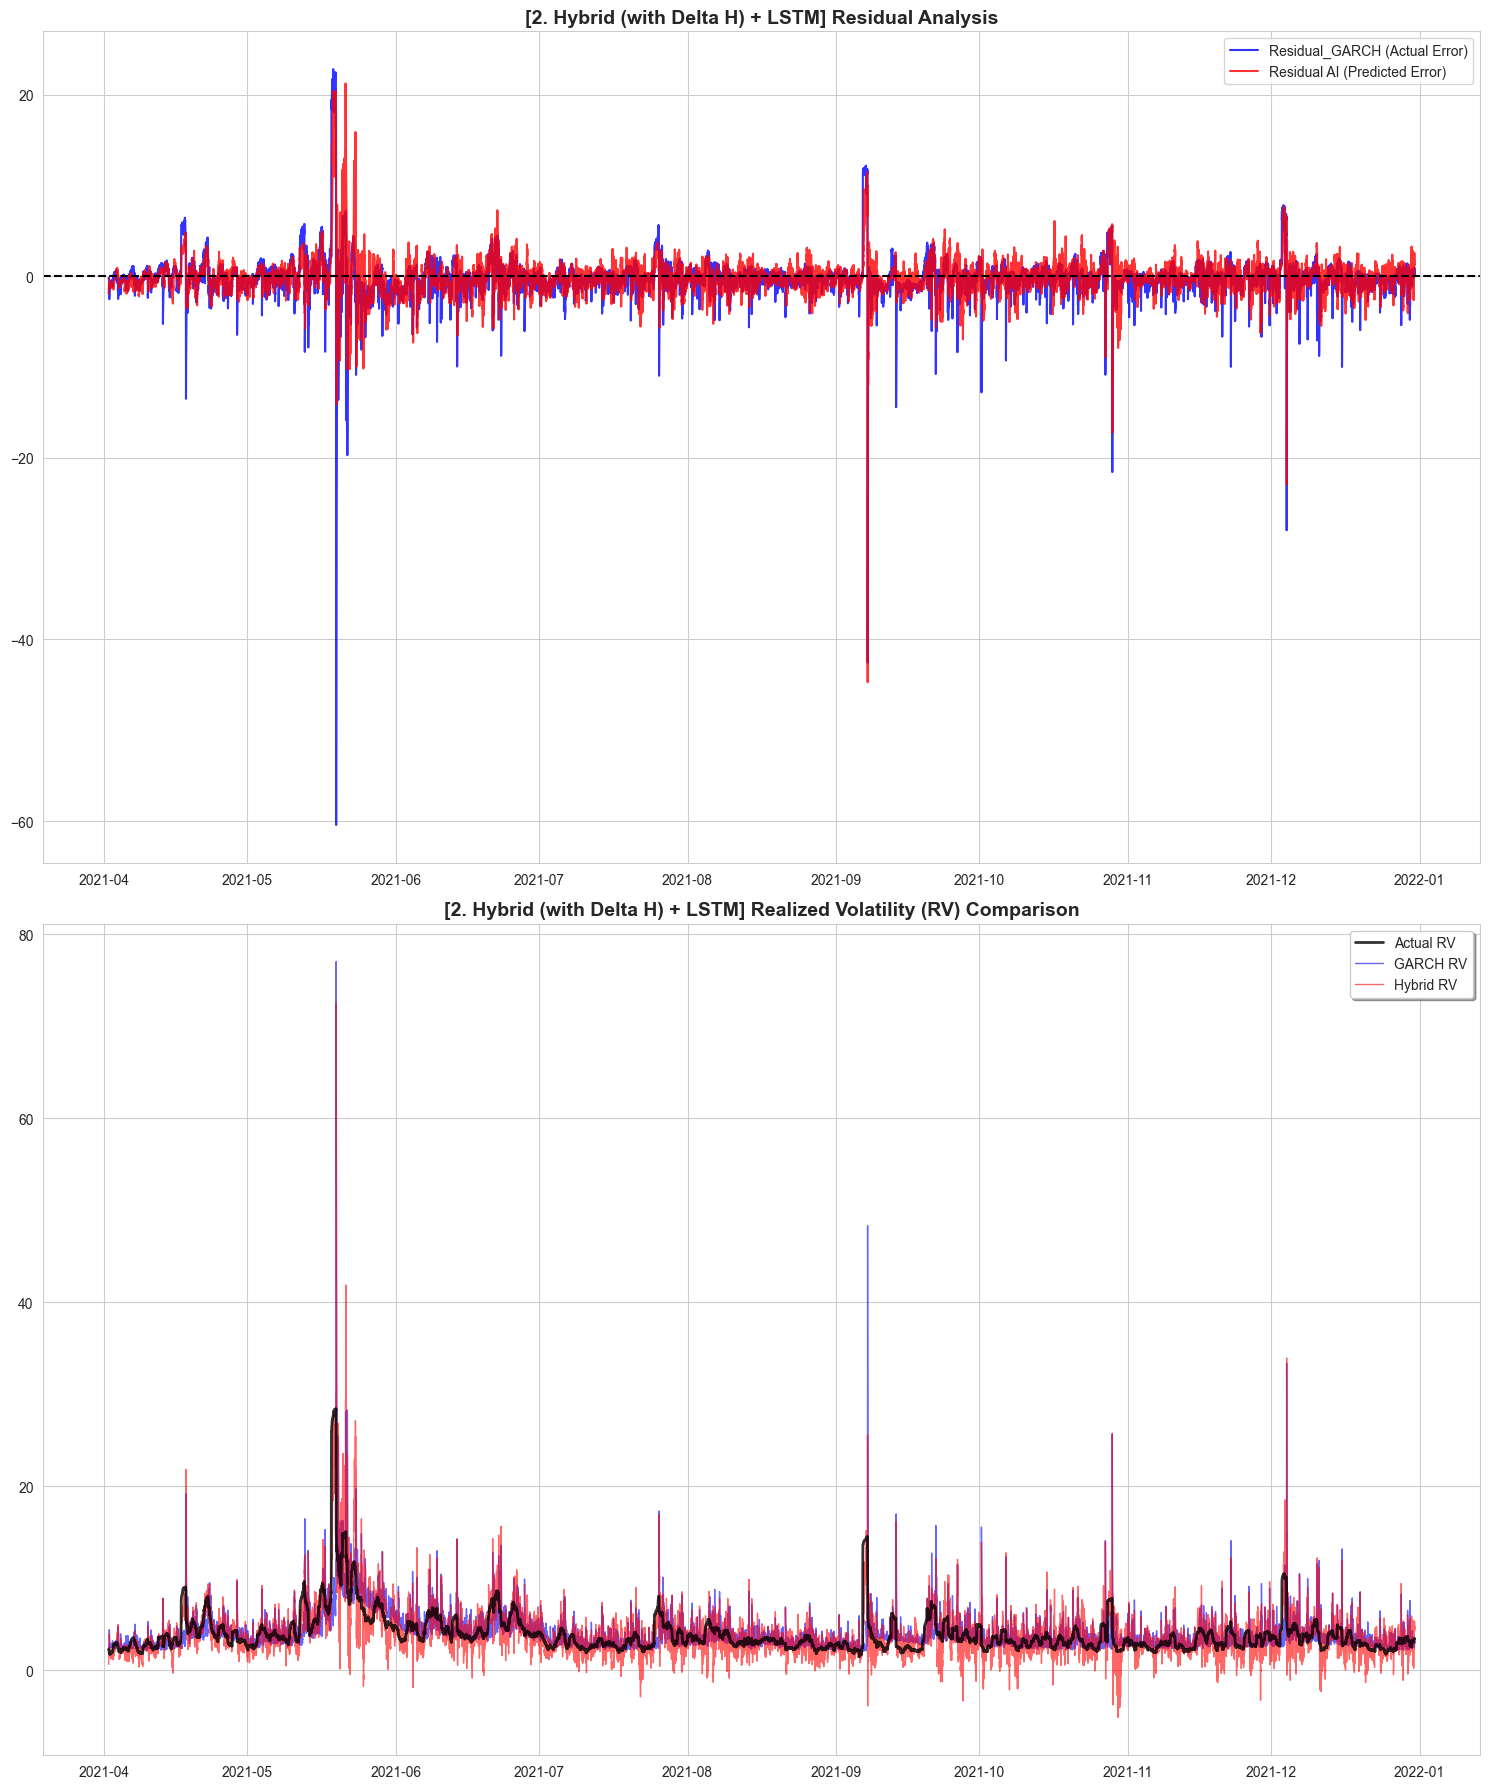


 >> Running AI Model: Bi-LSTM

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [05:05<00:00, 128.84it/s]


RMSE Base: 2.3600 -> Hybrid: 1.6363 (30.66% Improved)


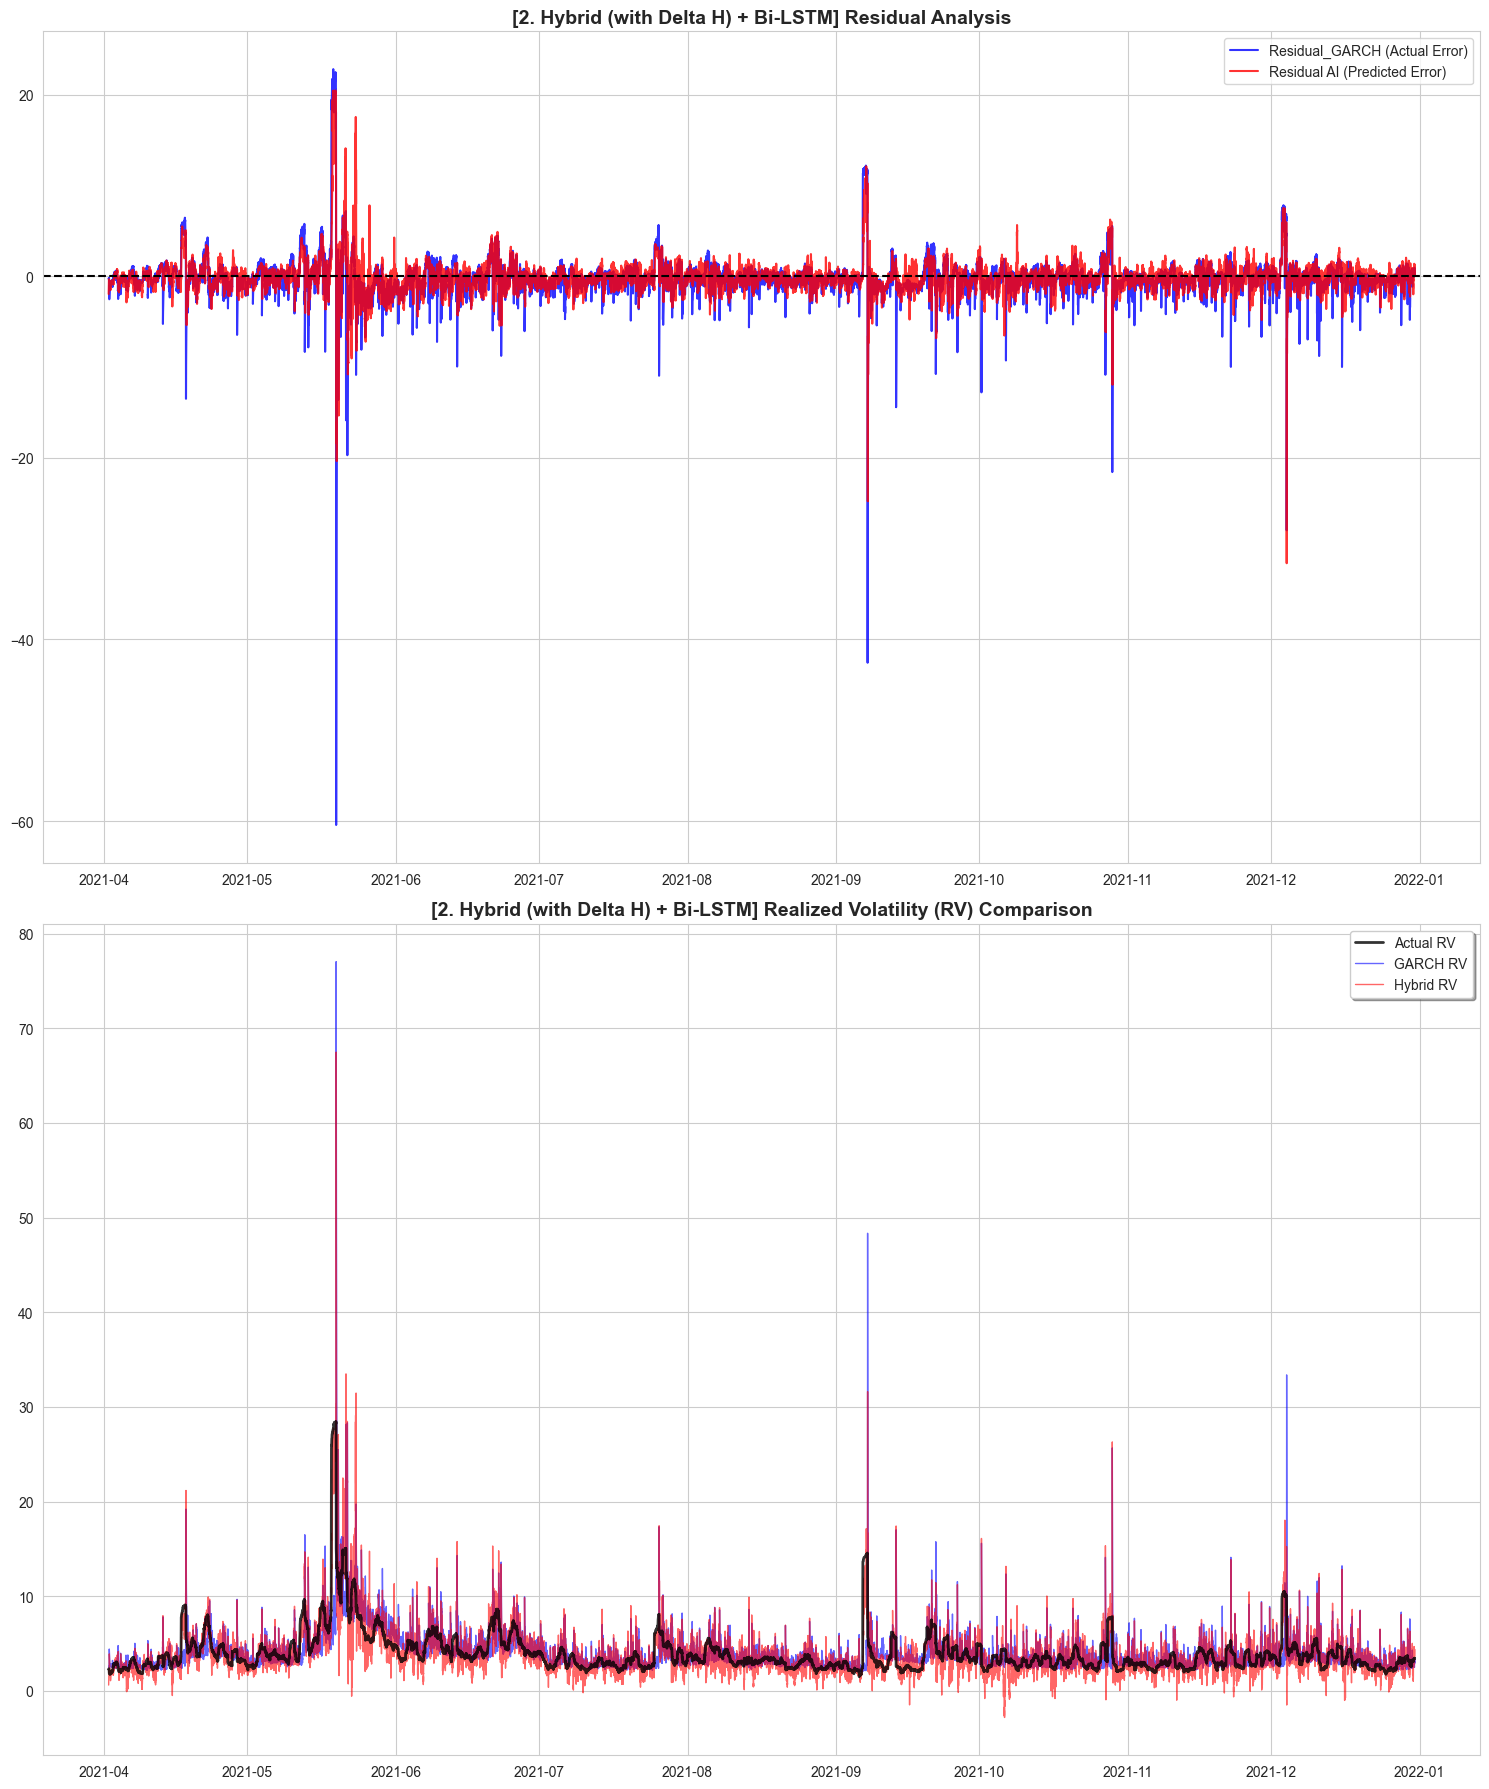


 >> Running AI Model: GRU

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:25<00:00, 270.00it/s]


RMSE Base: 2.3600 -> Hybrid: 1.8299 (22.46% Improved)


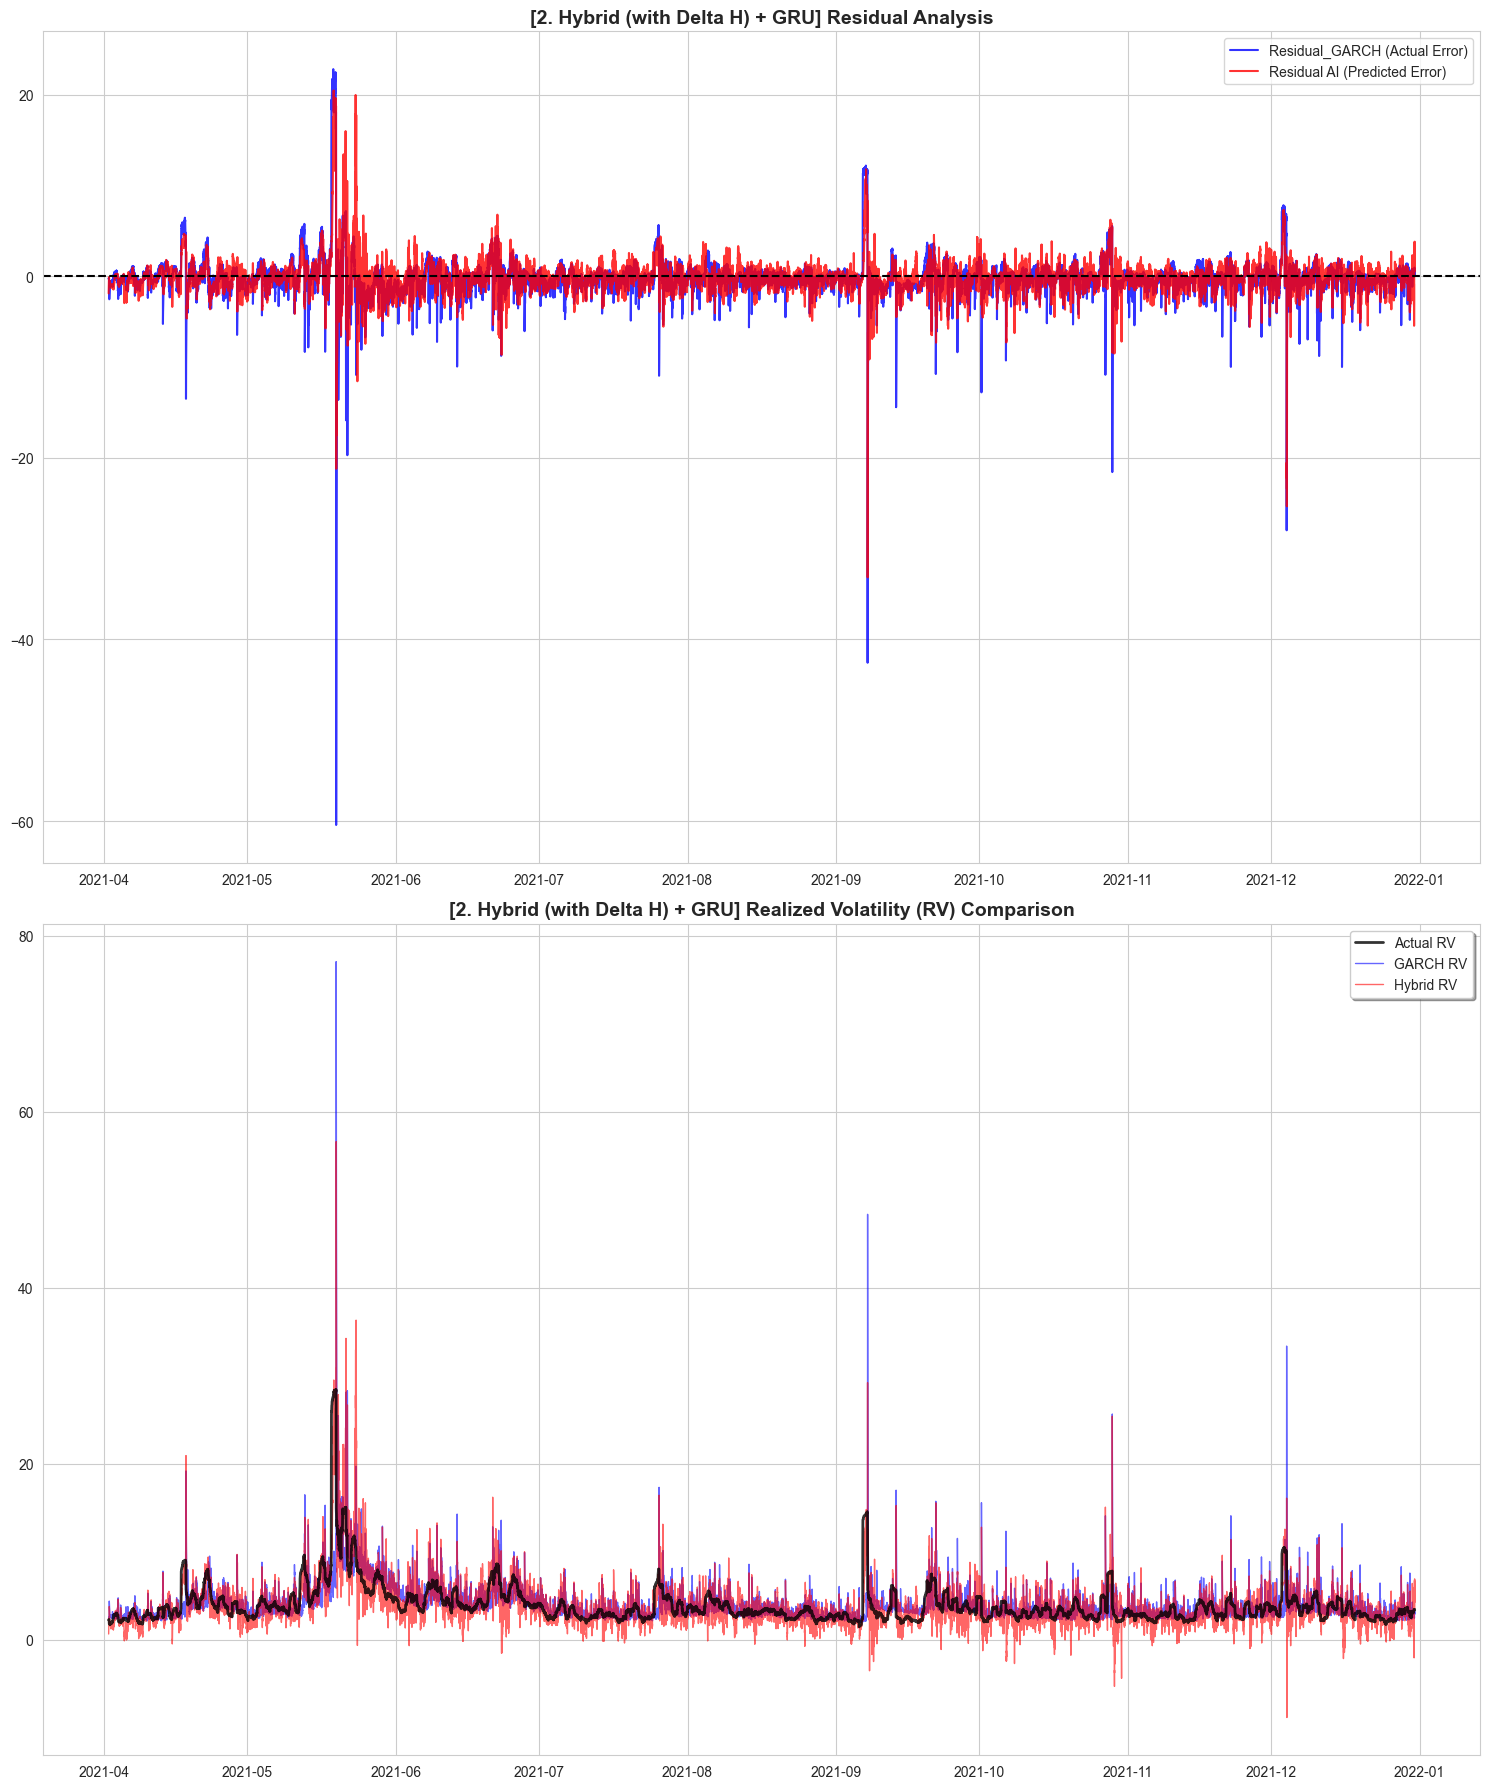


 >> Running AI Model: Bi-GRU

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [04:14<00:00, 154.25it/s]


RMSE Base: 2.3600 -> Hybrid: 1.4799 (37.29% Improved)


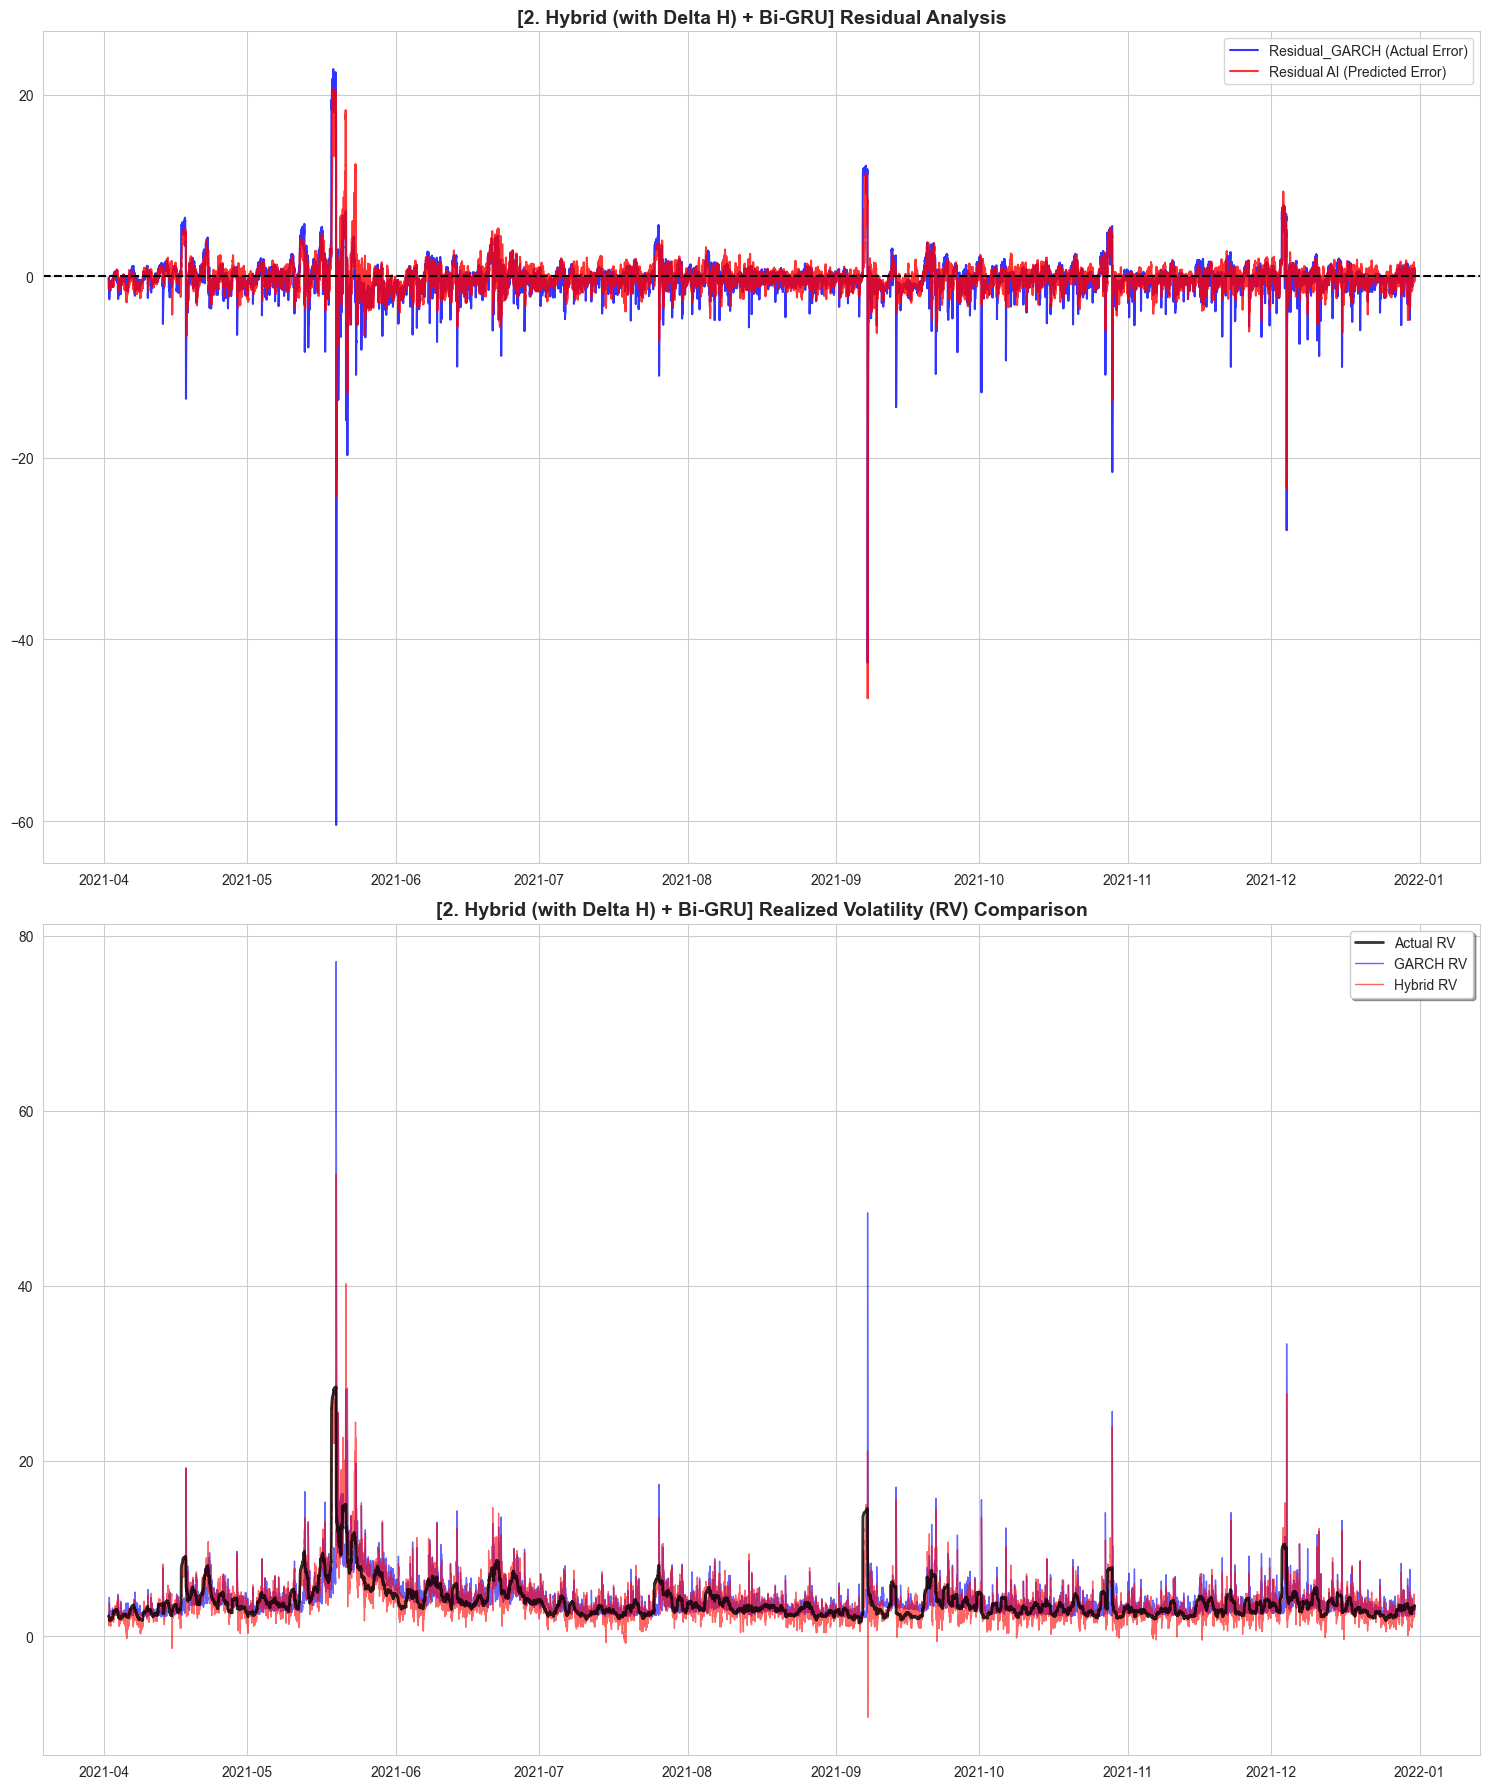


 >> Running AI Model: Ridge

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [09:46<00:00, 66.97it/s]


RMSE Base: 2.3600 -> Hybrid: 3.4832 (-47.59% Improved)


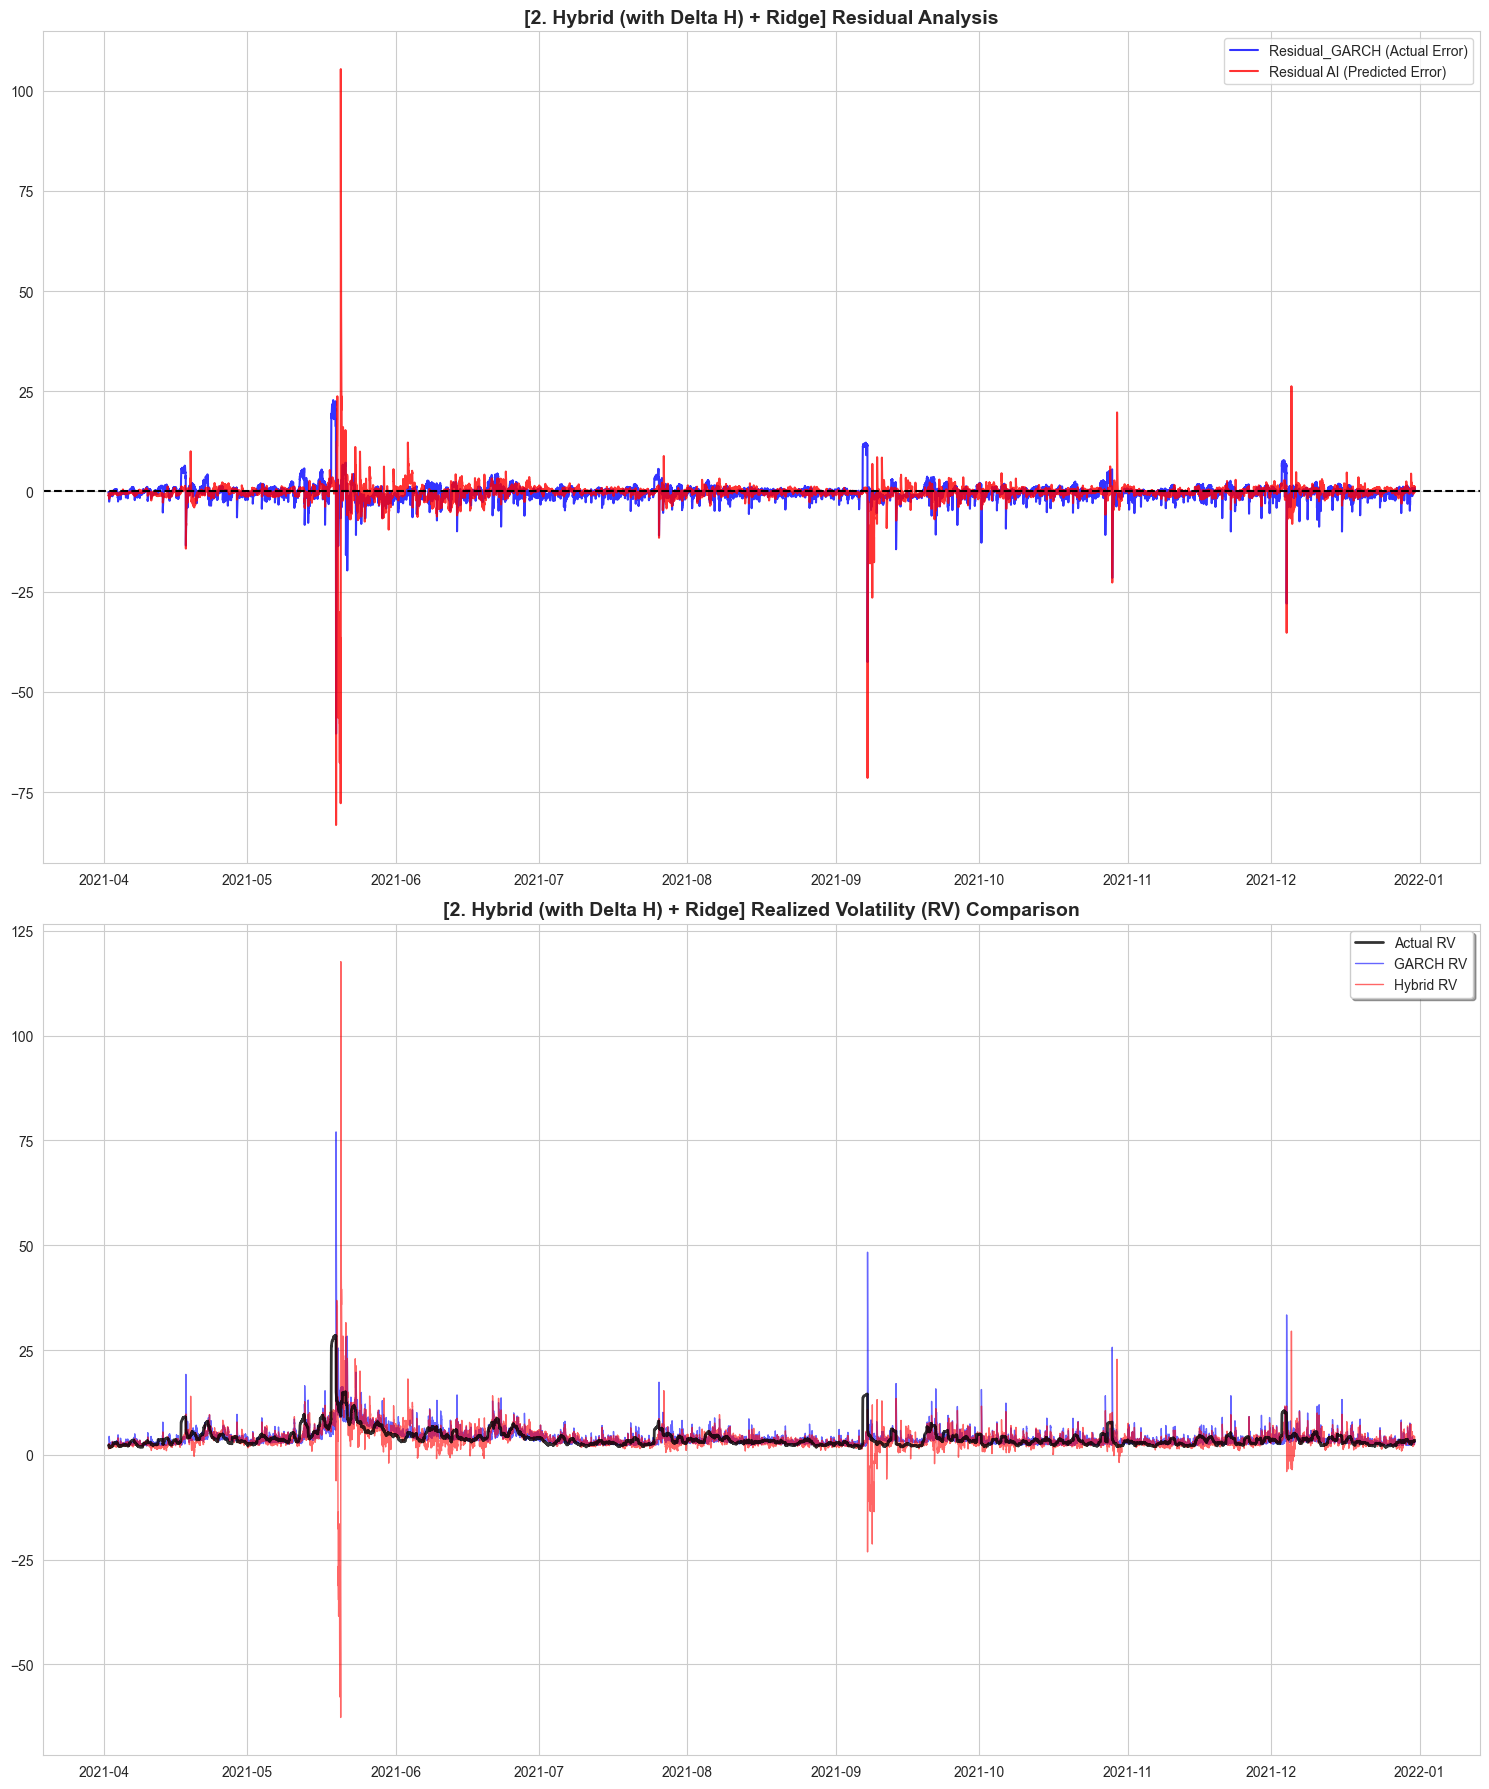


Running Scenario: 3. Hybrid (with Delta Alpha)
------------------------------------------------------------
[INFO] Base Model Running (Exog: delta_alpha)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.37it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070106
   - Beta  (GARCH) : 0.872798
   - m     (Const) : 0.256855  -> (m^2 used: 0.06597432)
   - Theta (RV_Wgt): 0.055086  -> (theta^2 used: 0.00303450)
   - W_Exog(exog_x): 0.304598  -> (w^2 used: 0.09277996)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376625
   - Min : 0.254813
   - Max : 0.846042
   - First 5 values: [0.47877908 0.69277914 0.65822367 0.64487822 0.63049825]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:04,  1.66it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061782
   - Beta  (GARCH) : 0.891771
   - m     (Const) : 0.140976  -> (m^2 used: 0.01987426)
   - Theta (RV_Wgt): 0.065164  -> (theta^2 used: 0.00424640)
   - W_Exog(exog_x): 0.228748  -> (w^2 used: 0.05232571)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.303501
   - Min : 0.182793
   - Max : 1.600903
   - First 5 values: [0.3004635  0.29671594 0.28776322 0.28061569 0.27996095]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:02<00:05,  1.22it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861689
   - m     (Const) : 0.123958  -> (m^2 used: 0.01536569)
   - Theta (RV_Wgt): 0.074428  -> (theta^2 used: 0.00553952)
   - W_Exog(exog_x): 0.000382  -> (w^2 used: 0.00000015)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543999
   - Min : 0.204958
   - Max : 6.421263
   - First 5 values: [0.30991454 0.31544766 0.30378296 0.29709548 0.287434  ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.05s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096893
   - Beta  (GARCH) : 0.858214
   - m     (Const) : 0.053827  -> (m^2 used: 0.00289736)
   - Theta (RV_Wgt): 0.069581  -> (theta^2 used: 0.00484153)
   - W_Exog(exog_x): 0.317074  -> (w^2 used: 0.10053579)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.416163
   - Min : 0.258064
   - Max : 1.191219
   - First 5 values: [0.53234143 0.51408126 0.53571251 0.51397258 0.50160634]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:06,  1.36s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092249
   - Beta  (GARCH) : 0.865775
   - m     (Const) : 0.087821  -> (m^2 used: 0.00771255)
   - Theta (RV_Wgt): 0.066967  -> (theta^2 used: 0.00448457)
   - W_Exog(exog_x): 0.321880  -> (w^2 used: 0.10360661)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285382
   - Min : 0.172174
   - Max : 1.444256
   - First 5 values: [0.37323709 0.3570137  0.34286826 0.32956255 0.31784327]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:07<00:06,  1.68s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097177
   - Beta  (GARCH) : 0.853864
   - m     (Const) : 0.089420  -> (m^2 used: 0.00799591)
   - Theta (RV_Wgt): 0.064573  -> (theta^2 used: 0.00416969)
   - W_Exog(exog_x): 0.330372  -> (w^2 used: 0.10914555)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281654
   - Min : 0.182009
   - Max : 0.735256
   - First 5 values: [0.30689694 0.29868622 0.29023287 0.27882272 0.28391236]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:06,  2.02s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102813
   - Beta  (GARCH) : 0.836312
   - m     (Const) : 0.075260  -> (m^2 used: 0.00566407)
   - Theta (RV_Wgt): 0.065191  -> (theta^2 used: 0.00424990)
   - W_Exog(exog_x): 0.311166  -> (w^2 used: 0.09682454)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.325669
   - Min : 0.167784
   - Max : 4.027171
   - First 5 values: [0.24054598 0.25414151 0.24180437 0.24858469 0.25037527]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:13<00:04,  2.27s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115626
   - Beta  (GARCH) : 0.824493
   - m     (Const) : 0.193525  -> (m^2 used: 0.03745199)
   - Theta (RV_Wgt): 0.067158  -> (theta^2 used: 0.00451013)
   - W_Exog(exog_x): 0.094579  -> (w^2 used: 0.00894513)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277453
   - Min : 0.186656
   - Max : 2.138425
   - First 5 values: [0.24239673 0.23567779 0.23710063 0.23167495 0.24732286]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:16<00:02,  2.41s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128875
   - Beta  (GARCH) : 0.784329
   - m     (Const) : 0.192757  -> (m^2 used: 0.03715529)
   - Theta (RV_Wgt): 0.063186  -> (theta^2 used: 0.00399242)
   - W_Exog(exog_x): 0.160381  -> (w^2 used: 0.02572197)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.272954
   - Min : 0.187048
   - Max : 1.175324
   - First 5 values: [0.2443579  0.28227177 0.28275228 0.26840495 0.26194445]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136228
   - Beta  (GARCH) : 0.772053
   - m     (Const) : 0.203473  -> (m^2 used: 0.04140123)
   - Theta (RV_Wgt): 0.065286  -> (theta^2 used: 0.00426221)
   - W_Exog(exog_x): 0.047281  -> (w^2 used: 0.00223545)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296772
   - Min : 0.183630
   - Max : 2.781154
   - First 5 values: [0.29089949 0.32570717 0.30847283 0.30899325 0.30597332]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1511.77it/s]


Final Data shape: (43632, 728)

 >> Running AI Model: LSTM

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:57<00:00, 221.55it/s]


RMSE Base: 2.3600 -> Hybrid: 1.9949 (15.47% Improved)


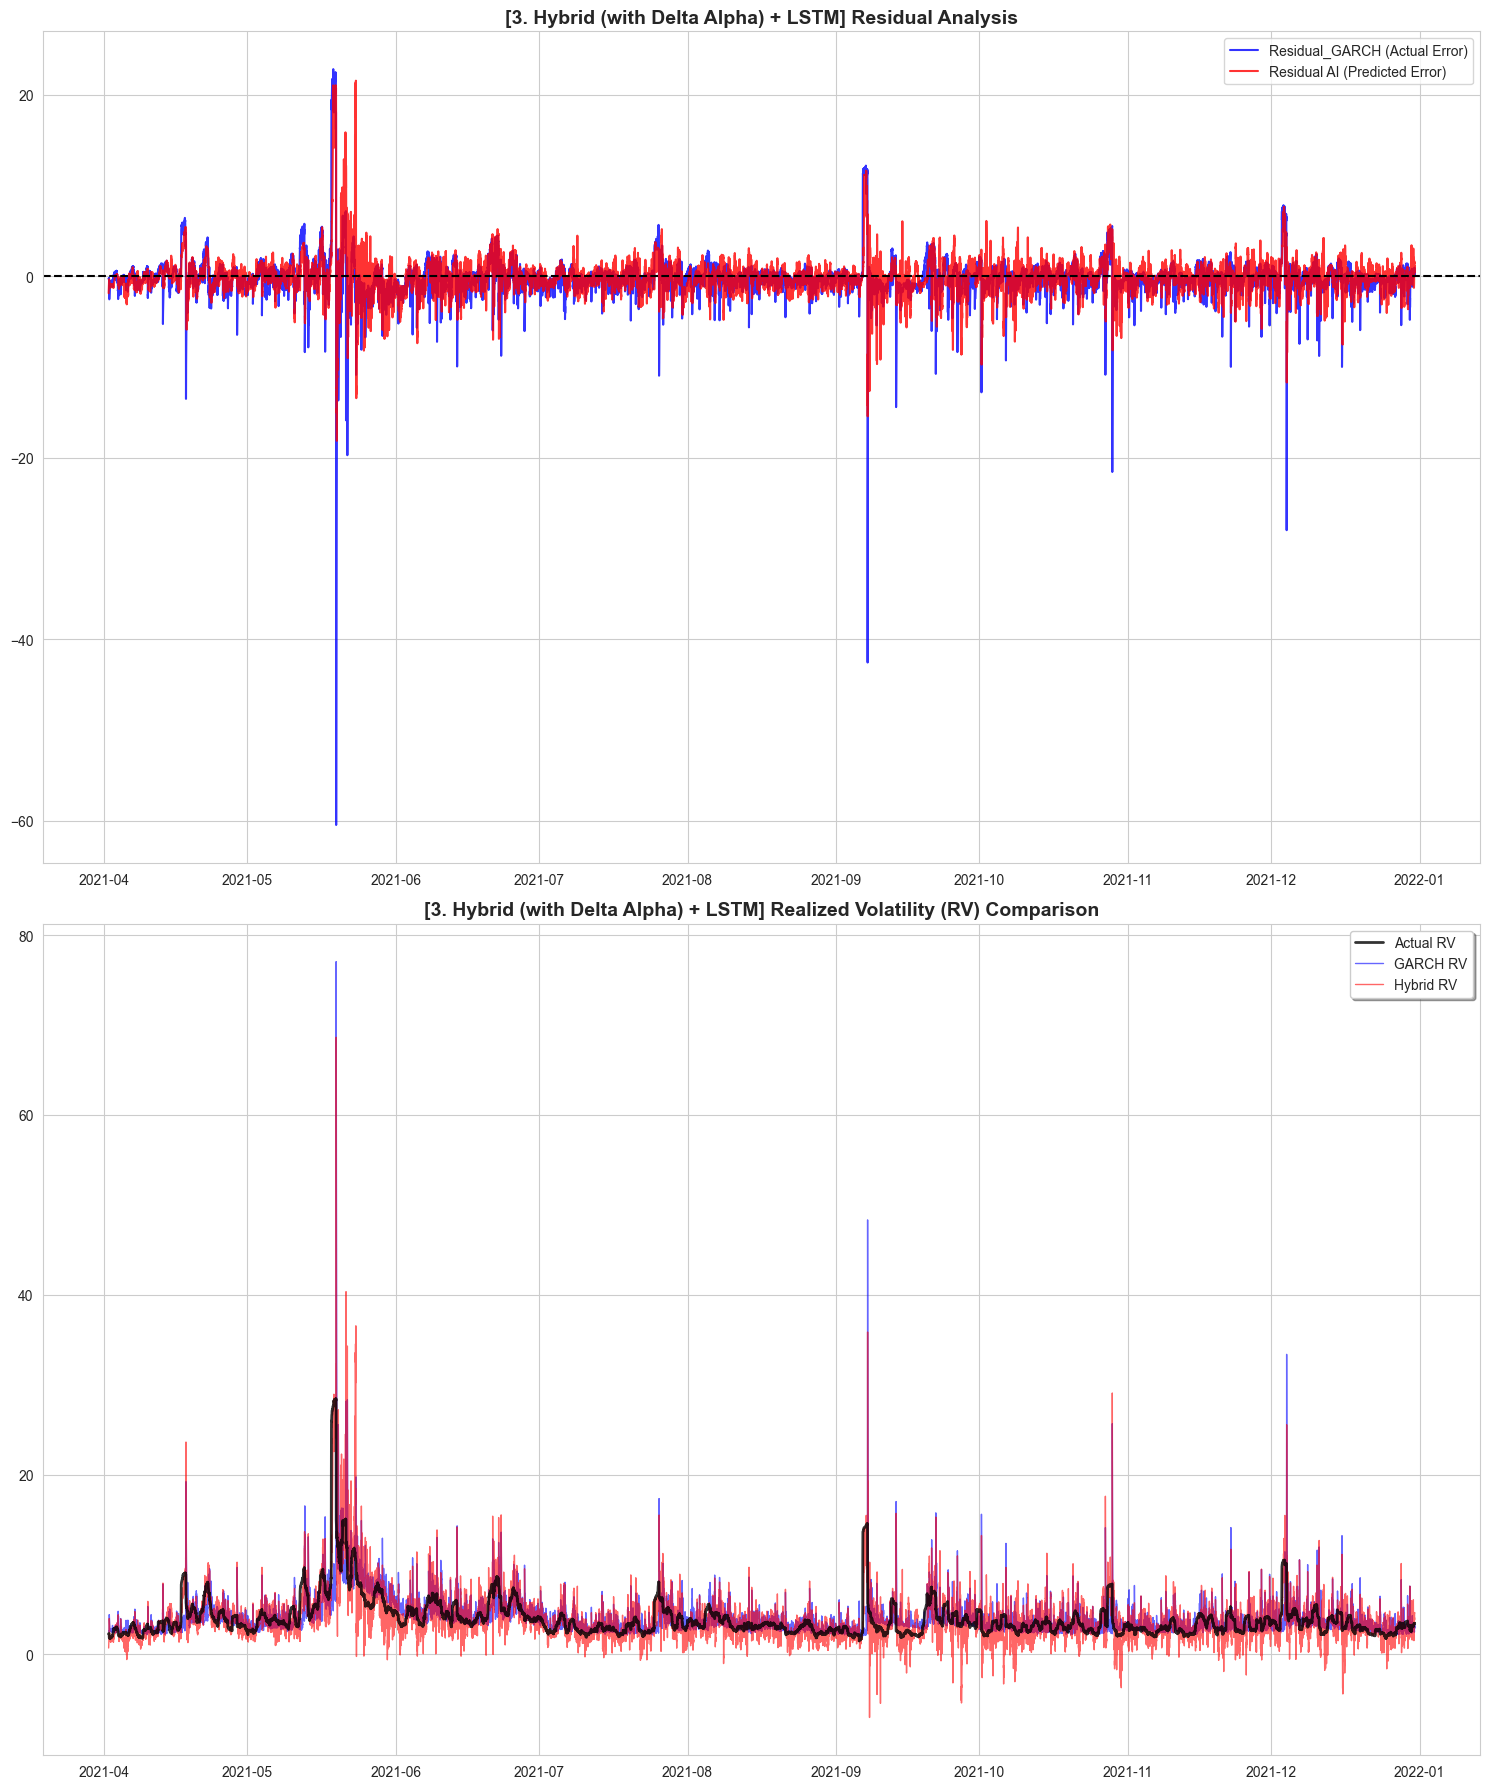


 >> Running AI Model: Bi-LSTM

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [05:13<00:00, 125.54it/s]


RMSE Base: 2.3600 -> Hybrid: 1.6392 (30.54% Improved)


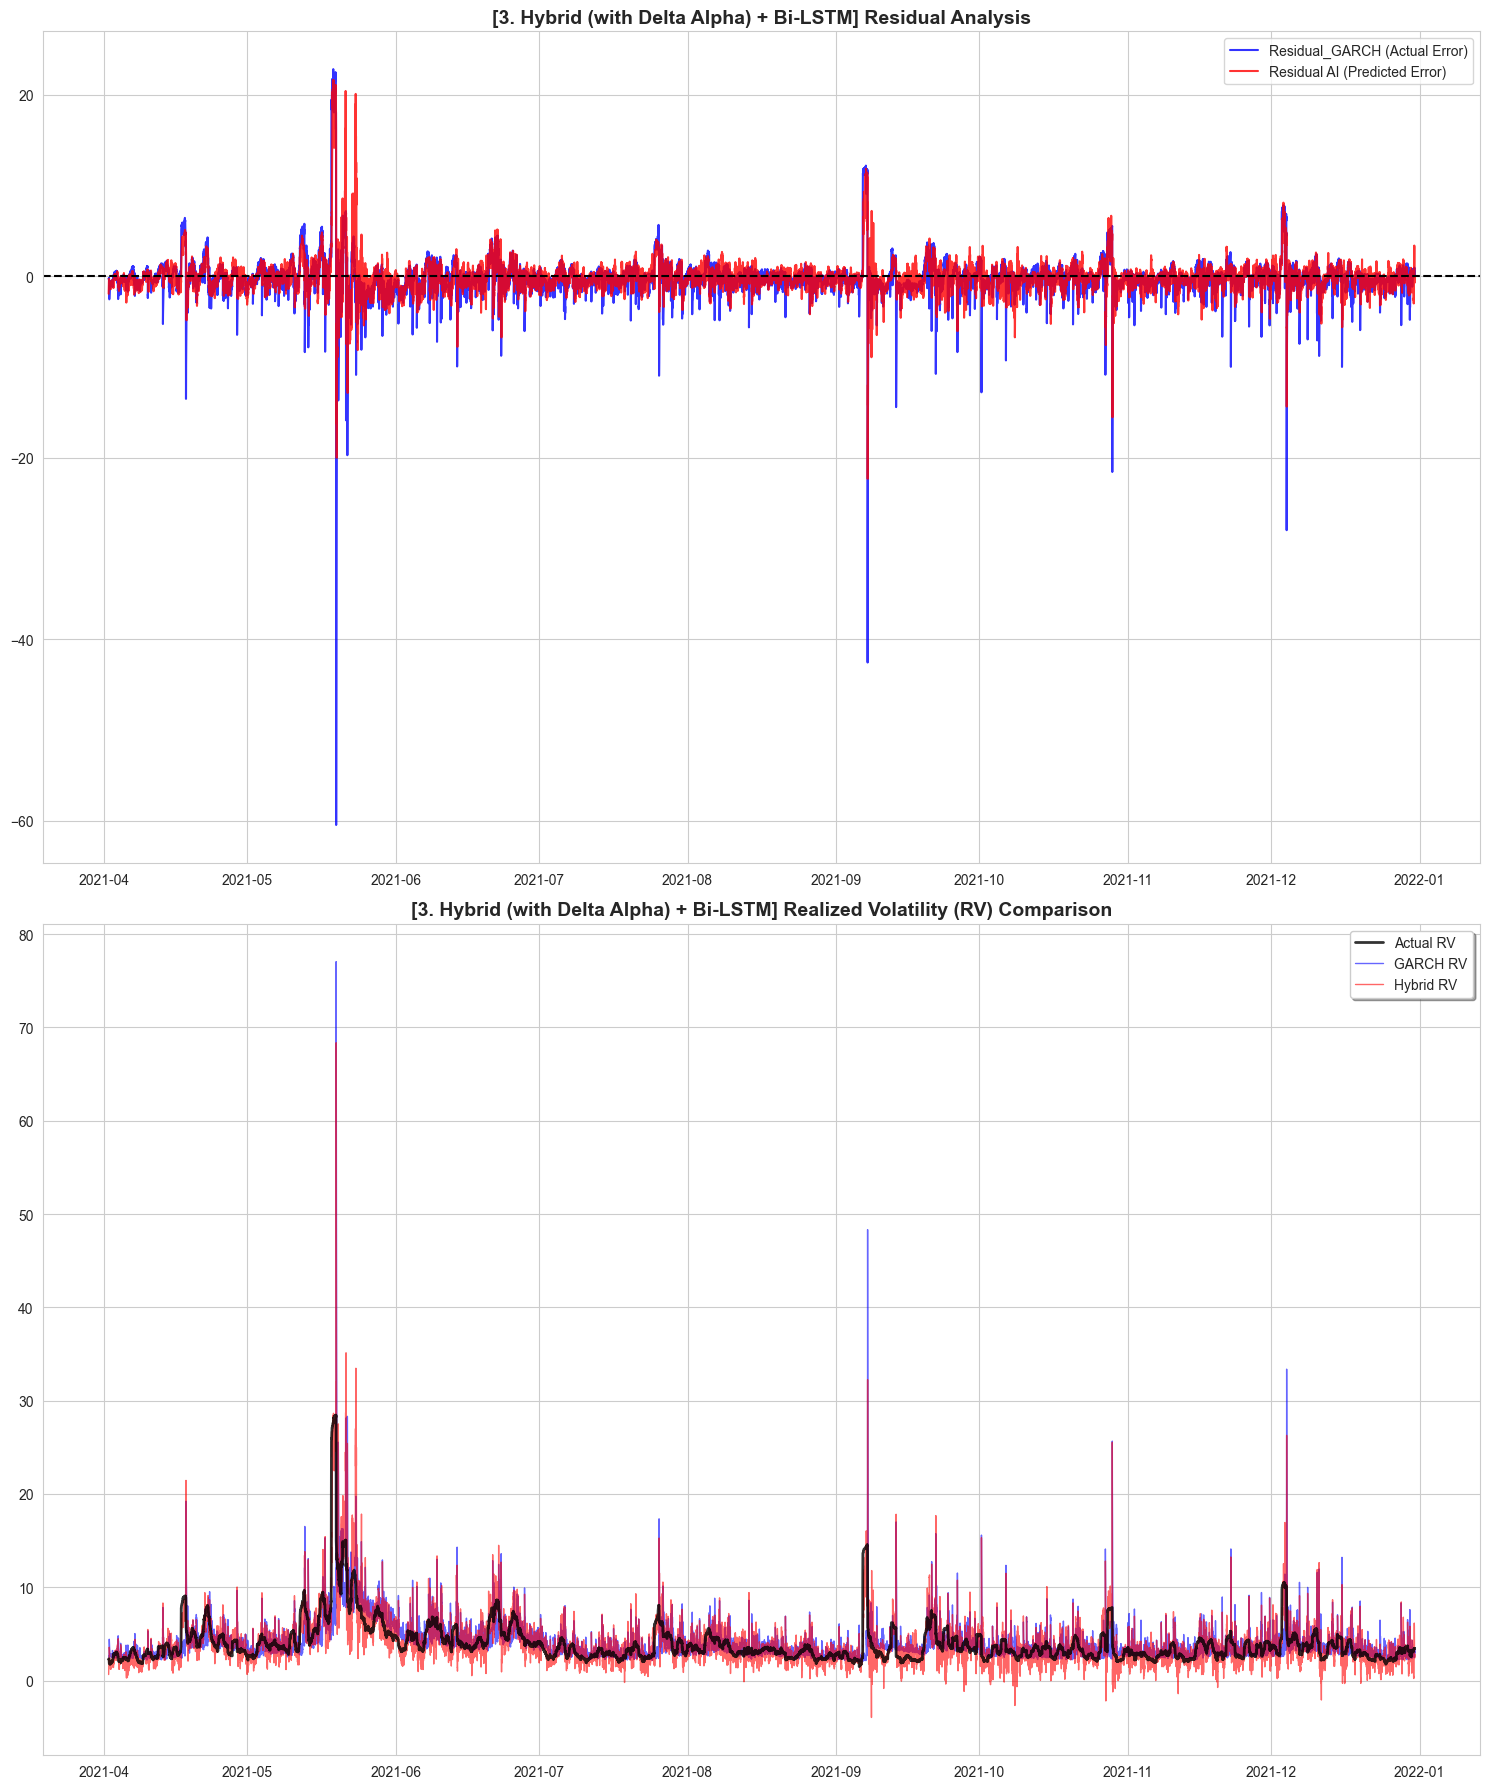


 >> Running AI Model: GRU

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:30<00:00, 261.81it/s]


RMSE Base: 2.3600 -> Hybrid: 1.7885 (24.22% Improved)


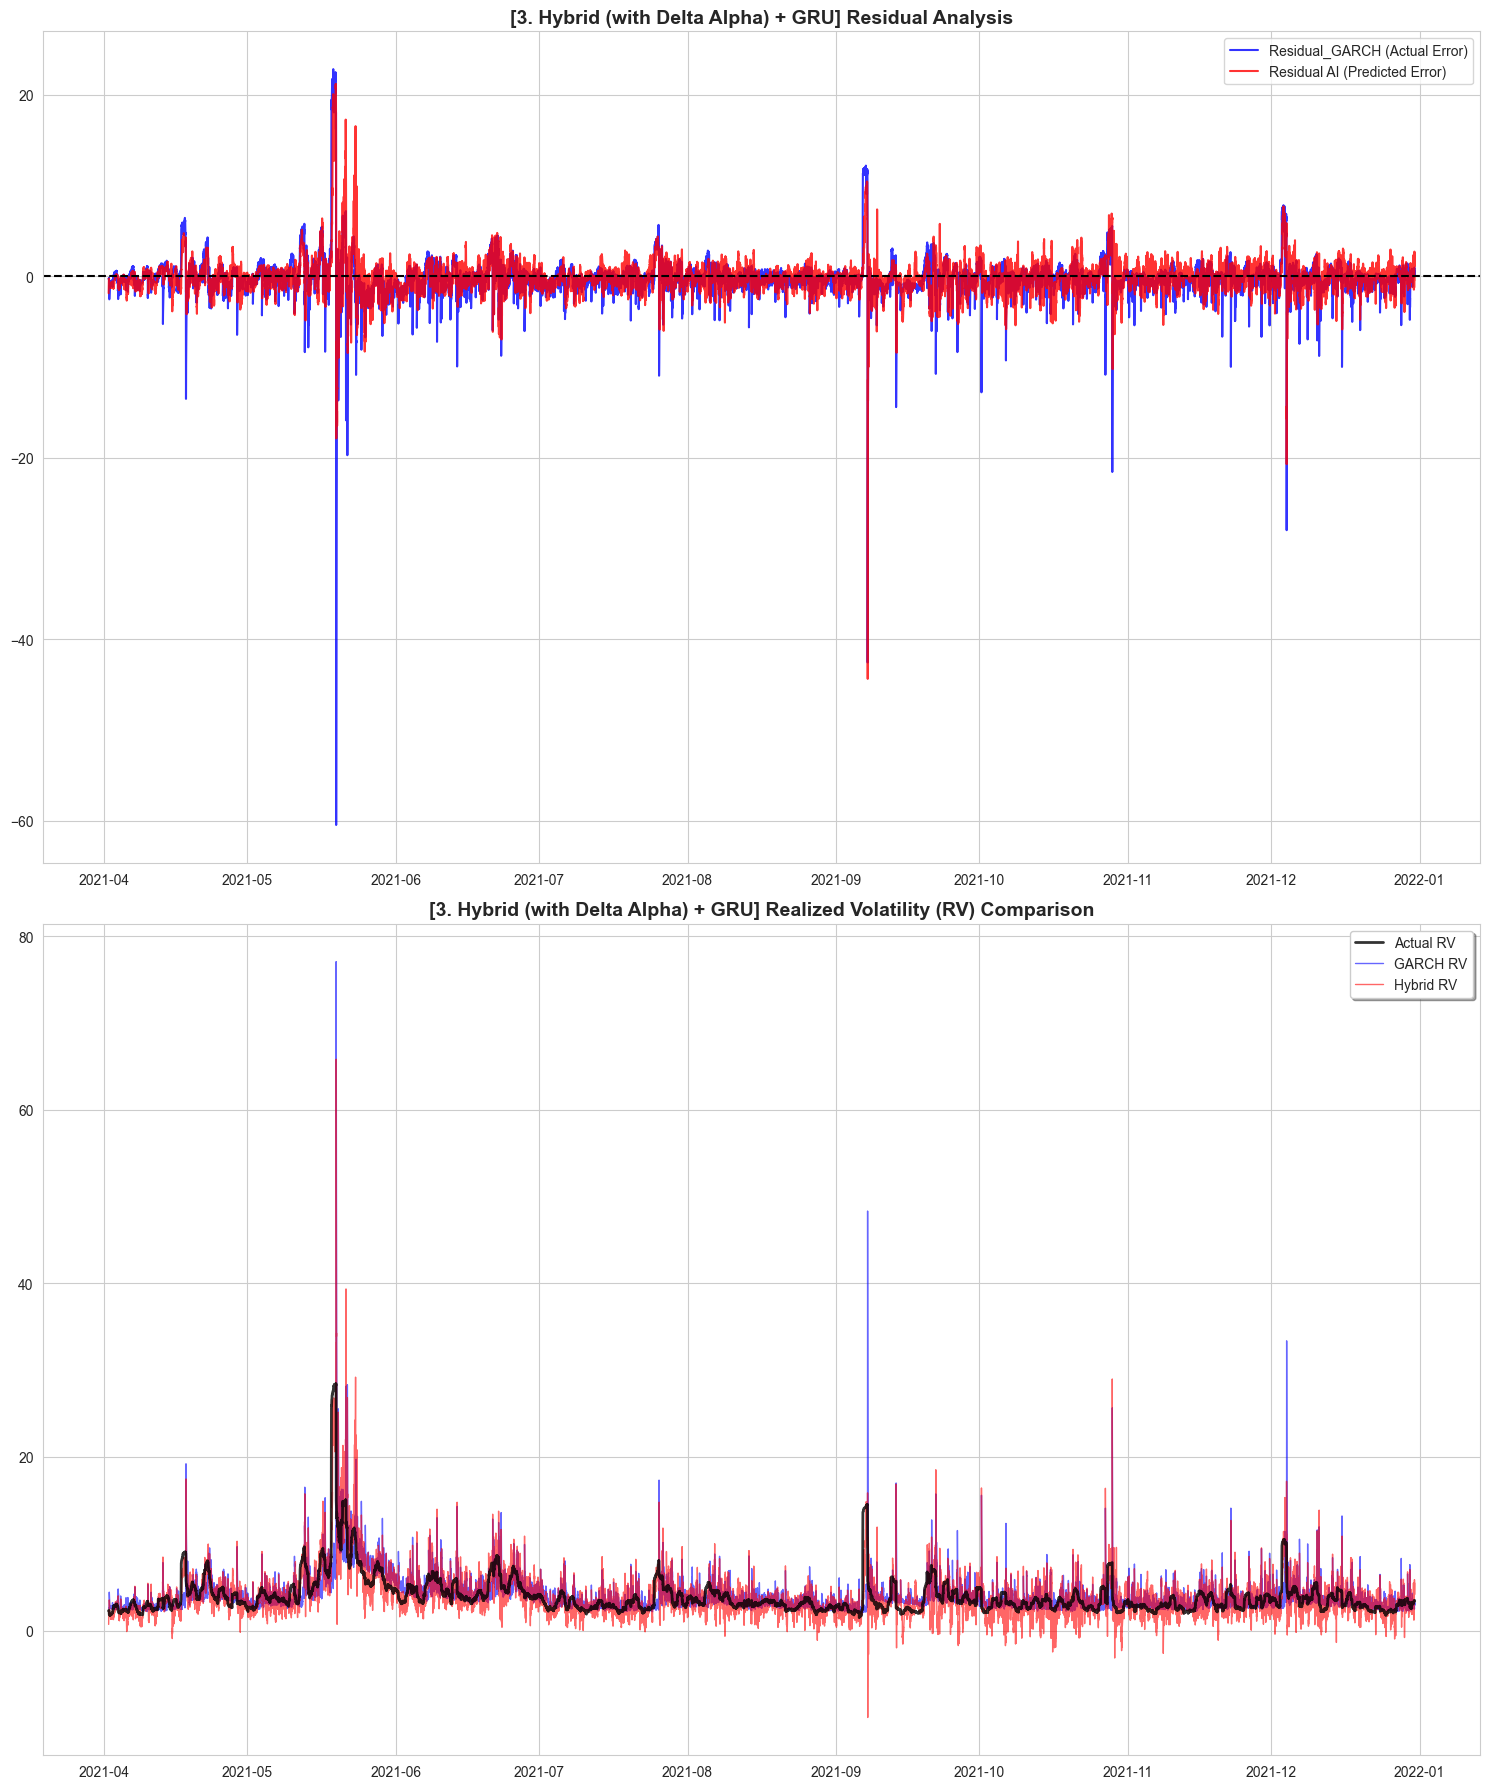


 >> Running AI Model: Bi-GRU

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [04:18<00:00, 152.30it/s]


RMSE Base: 2.3600 -> Hybrid: 1.5049 (36.23% Improved)


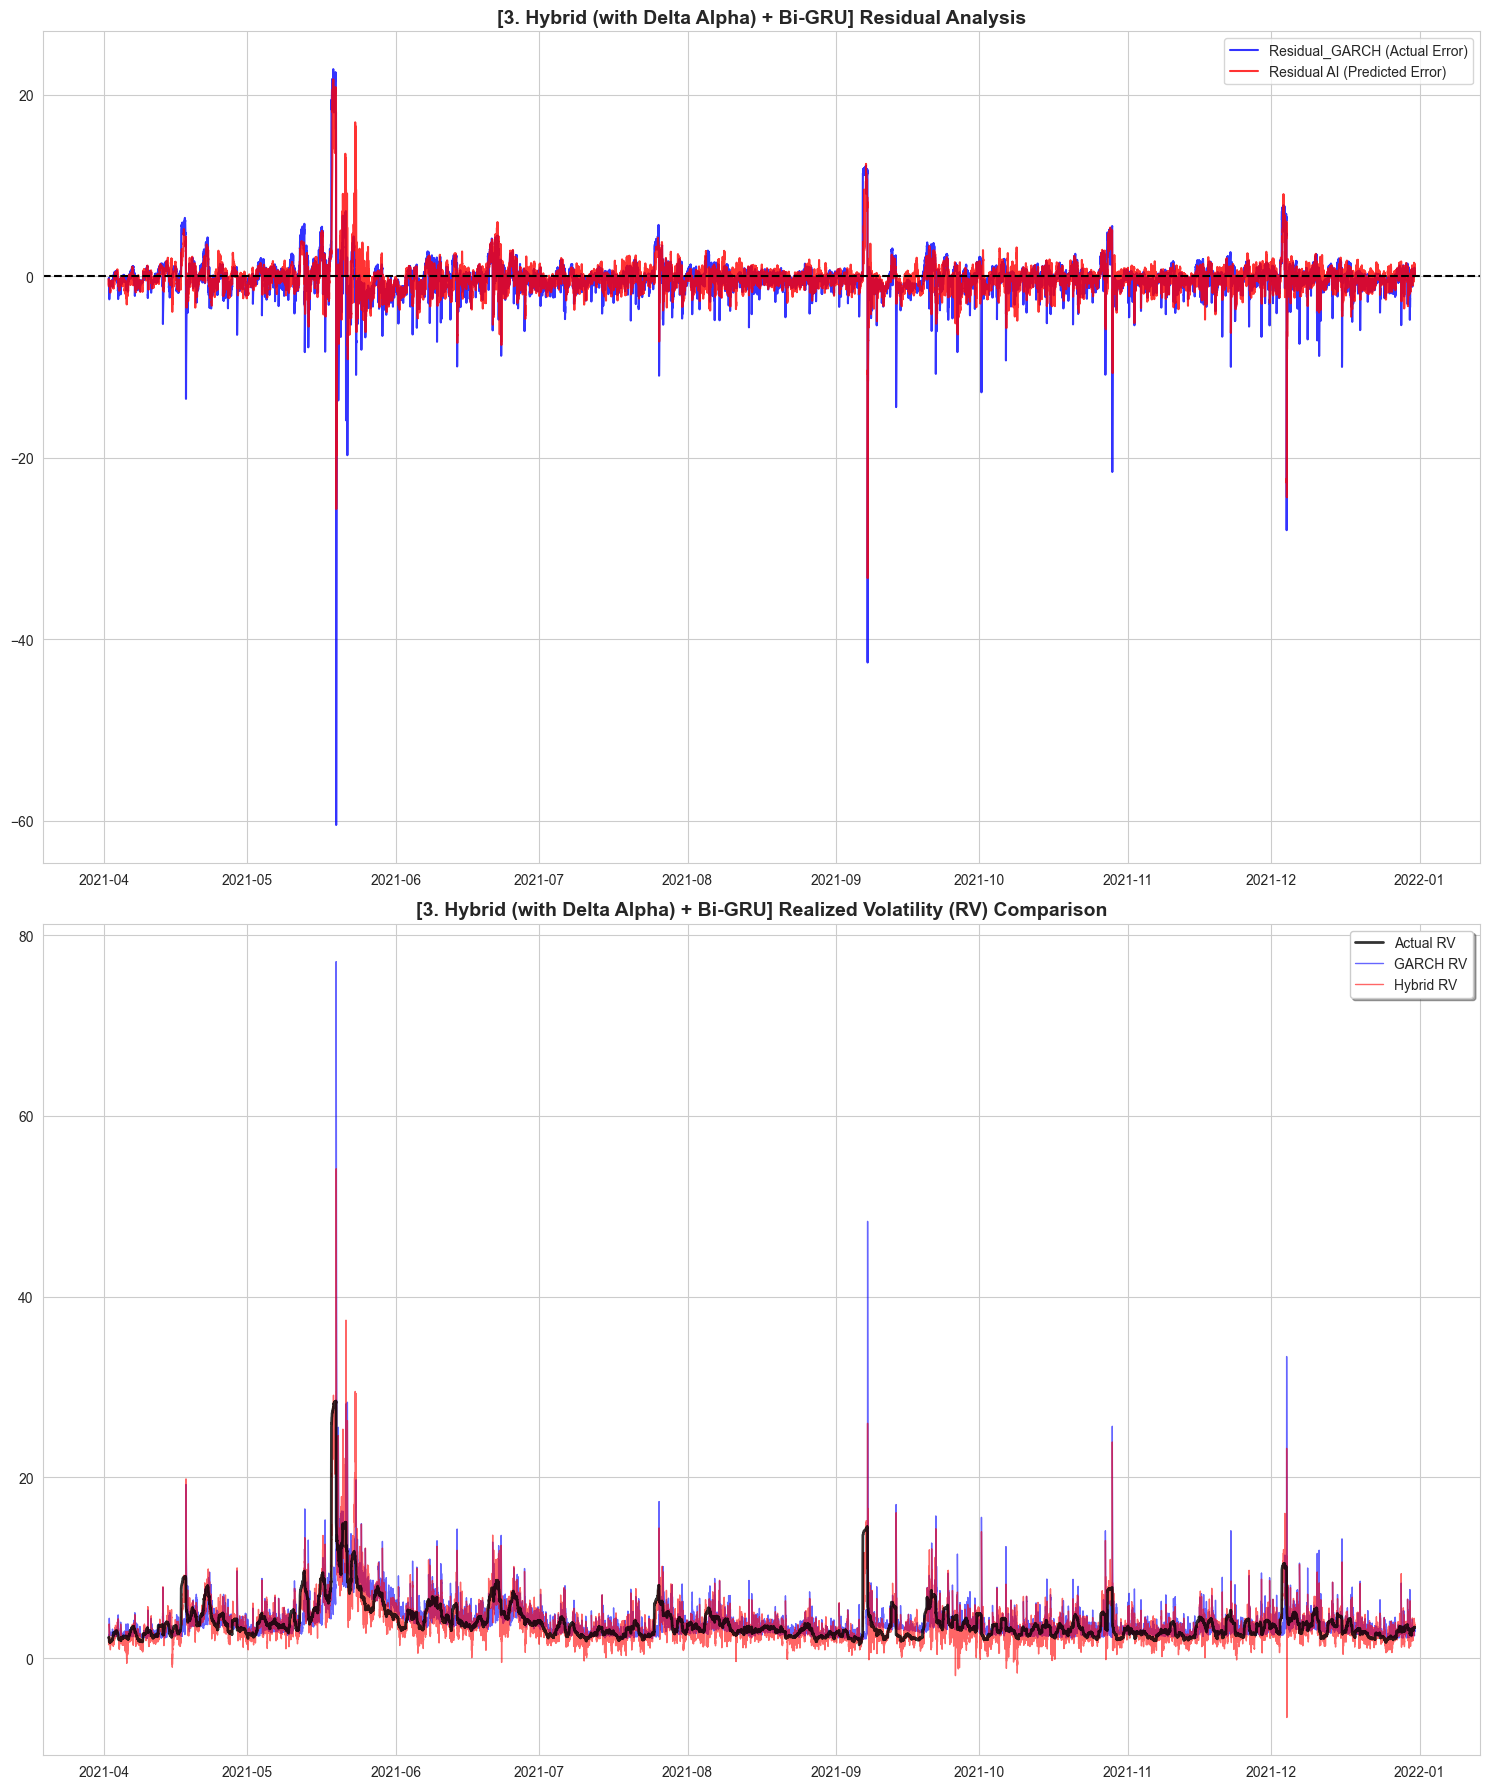


 >> Running AI Model: Ridge

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 30일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [08:57<00:00, 73.18it/s]


RMSE Base: 2.3600 -> Hybrid: 3.4836 (-47.61% Improved)


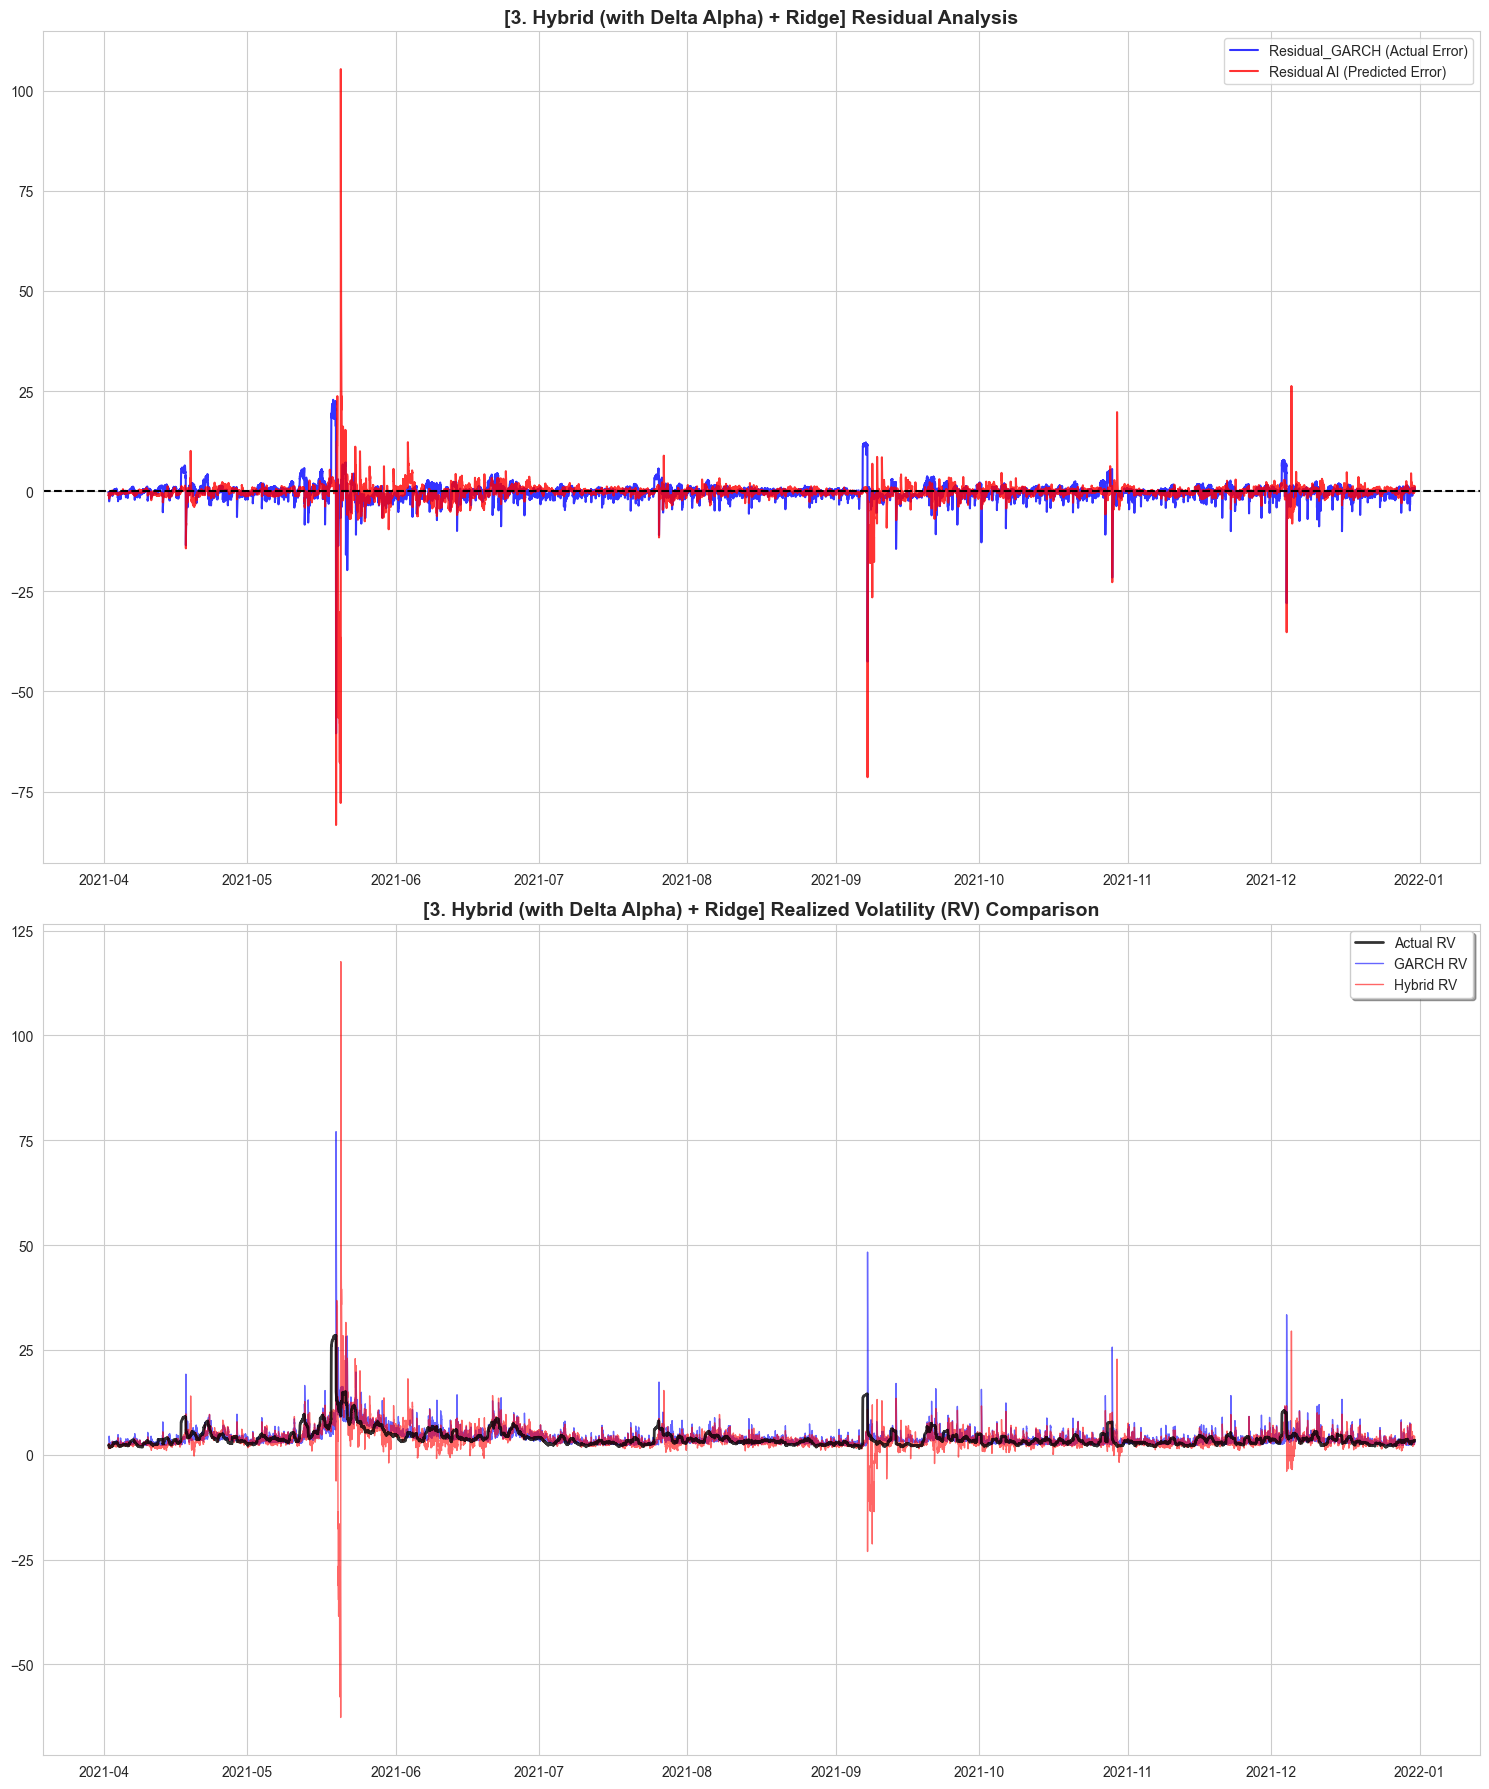


Final Leaderboard
                  GARCH_Scenario  AIModel  RMSE_Base  RMSE_Hybrid  \
0         1. Benchmark (No Exog)     LSTM   2.362674     1.746897   
1         1. Benchmark (No Exog)  Bi-LSTM   2.362674     1.647017   
2         1. Benchmark (No Exog)      GRU   2.362674     1.756137   
3         1. Benchmark (No Exog)   Bi-GRU   2.362674     1.514589   
4         1. Benchmark (No Exog)    Ridge   2.362674     3.488845   
5       2. Hybrid (with Delta H)     LSTM   2.359984     1.901453   
6       2. Hybrid (with Delta H)  Bi-LSTM   2.359984     1.636298   
7       2. Hybrid (with Delta H)      GRU   2.359984     1.829916   
8       2. Hybrid (with Delta H)   Bi-GRU   2.359984     1.479946   
9       2. Hybrid (with Delta H)    Ridge   2.359984     3.483213   
10  3. Hybrid (with Delta Alpha)     LSTM   2.359996     1.994885   
11  3. Hybrid (with Delta Alpha)  Bi-LSTM   2.359996     1.639158   
12  3. Hybrid (with Delta Alpha)      GRU   2.359996     1.788492   
13  3. Hybrid (

In [25]:
# AI 모델 예측 결과

def plot_model_result(eval_df, model_name):
    sns.set_style(style = "whitegrid")

    fig, axes = plt.subplots(2, 1, figsize = (15, 18))

    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
        
    # daily_df = eval_df[['Residual', pred_col]].resample('1D').mean()
    
    axes[0].plot(eval_df.index, eval_df['Residual'],
                 label = 'Residual_GARCH (Actual Error)', color = 'blue', alpha = 0.8)
    axes[0].plot(eval_df.index, eval_df[pred_col],
                 label = 'Residual AI (Predicted Error)', color = 'red', alpha = 0.8)
    axes[0].set_title(F"[{model_name}] Residual Analysis", fontsize = 14, fontweight = 'bold')
    axes[0].axhline(0, color = 'black', linestyle = '--')
    axes[0].legend(loc = 'upper right')
    
    actual_vol = eval_df['Future_Vol_24h']
    garch_vol = eval_df['GARCH_Daily']
    
    hybrid_vol = eval_df['GARCH_Daily'] + eval_df[pred_col]
    
    axes[1].plot(eval_df.index, actual_vol, label = 'Actual RV', color = 'black', alpha = 0.8, linewidth = 2, zorder = 2)
    axes[1].plot(eval_df.index, garch_vol, label = 'GARCH RV', color = 'blue', alpha = 0.6, linewidth = 1, zorder = 1)
    axes[1].plot(eval_df.index, hybrid_vol, label = 'Hybrid RV', color = 'red', alpha = 0.6, linewidth = 1, zorder = 1)
    
    axes[1].set_title(f"[{model_name}] Realized Volatility (RV) Comparison", fontsize = 14, fontweight = 'bold')
    axes[1].legend(loc = 'upper right', frameon = True, shadow = True)
    
    plt.tight_layout()
    plt.show()

scenarios = {
    "1. Benchmark (No Exog)": None,
    "2. Hybrid (with Delta H)": "delta_H",
    "3. Hybrid (with Delta Alpha)": "delta_alpha"
}

ai_models = ["LSTM", "Bi-LSTM", "GRU", "Bi-GRU", "Ridge"]

results_summary = []

print("="*80)
print("Compare 3 GARCH-MIDAS Model")
print("="*80)

for model_name, exog_col in scenarios.items():
    print(f"\nRunning Scenario: {model_name}")
    print('-'*60)
    
    try:
        df_base = monthly_garch_midas(df_10m ,mfdfa_2021, exog_col = exog_col)
    except Exception as e:
        print(f"Error: {e}")
        continue
    
    flat_data, features = prepare_flatten_features(df_base, mfdfa_2021, lags = 144)
    
    TRAIN_WINDOW = 4320
    
    
    for ai_name in ai_models:
        print(f"\n >> Running AI Model: {ai_name}")
        
        final_result, _ = run_rolling_simulation(
            flat_data, features,
            model_type = ai_name,
            train_window = TRAIN_WINDOW
        )
    
        eval_df = final_result.dropna()
        
        rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['GARCH_Daily']))
        rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol']))
        improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
        
        print(f"RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
        
        results_summary.append({
            "GARCH_Scenario": model_name,
            "AIModel": ai_name,
            "RMSE_Base": rmse_base,
            "RMSE_Hybrid": rmse_hybrid,
            "Improvement (%)": improvement
        })
        
        full_name = f"{model_name} + {ai_name}"
        
        plot_model_result(eval_df, full_name)
    
print("\n" + "="*80)
print("Final Leaderboard")
print(pd.DataFrame(results_summary))

In [ ]:
def run_daily_garch(df_daily, actual_rv_series, test_days):
    print("\n[Base Line] Running Daily GARCH(1, 1)")
    
    
    if 'return' in df_daily.columns:
        daily_ret = df_daily['return'].dropna()
    else:
        daily_ret = 100 * np.log(df_daily['close'] / df_daily['close'].shift(1)).dropna()
        
    #  인덱스가 날짜 형식이 아니면 변환
    if not isinstance(daily_ret.index, pd.DatetimeIndex):
        daily_ret.index = pd.to_datetime(daily_ret.index)
        
    # 타임존(Timezone) 강제 제거 
    if daily_ret.index.tz is not None:
        daily_ret.index = daily_ret.index.tz_localize(None)
        
    model = arch_model(daily_ret, vol = 'Garch', p = 1, q = 1, rescale = False)
    res = model.fit(disp = 'off')
    
    target_index = actual_rv_series.index[-test_days*144:].normalize().unique()
    
    forecasts = res.forecast(horizon = 1, start = target_index[0])
    
    pred_vol_daily = np.sqrt(forecasts.variance.dropna()['h.1'])
    
    actual_rv = actual_rv_series.resample('1D').last().dropna()
    
    common_idx = actual_rv.index.intersection(pred_vol_daily.index)
    
    mse = mean_squared_error(actual_rv.loc[common_idx], pred_vol_daily.loc[common_idx])
    rmse = np.sqrt(mse)
    
    print(f"-> Daily GARCH RMSE: {rmse:.4f}")
    
    return rmse

def run_intraday_garch(df_10m, actual_rv_series, test_days):
    print("\n[Base Line 2] Running Intraday GARCH(1, 1) - 10min Datas")
    
    intra_ret = df_10m['return'].dropna()
    
    model = arch_model(intra_ret, vol = 'Garch', p = 1, q = 1, rescale = False)
    res = model.fit(disp = 'off', show_warning = False)
    
    test_start_idx = -test_days * 144
    
    cond_vol_10m = res.conditional_volatility.iloc[test_start_idx:]
    
    pred_vol_24h = cond_vol_10m * 12
    
    actual_rv = actual_rv_series.iloc[test_start_idx:]
    
    common_idx = actual_rv.index.intersection(pred_vol_24h.index)
    
    rmse = np.sqrt(mean_squared_error(actual_rv.loc[common_idx], pred_vol_24h.loc[common_idx]))
    
    print(f" -> Intraday GARCH RMSE: {rmse:.4f}")
    return rmse

def run_full_experiment(df_10m, df_base, mfdfa_data):
    results = []
    
    ai_models = ["LSTM", "Bi-LSTM", "GRU", "Bi-GRU", "Ridge"]

    garch_scenarios = {
        "Benchmark": None,
        "Delta_H": "delta_H",
        "Delta Alpha": "delta_alpha"
    }
    
    lags = 144
    TRAIN_WINDOW = 4320
    scale_factor = 12
    
    print("\n[Data] Preparing Flatten Featrues")
    
    try:
        df_daily = pd.read_csv("data/BTCUSDT_1d_2021.csv")
        df_daily.columns = [c.lower().strip() for c in df_daily.columns]
        
        if 'datetime' in df_daily.columns:
            df_daily['timestamp'] = pd.to_datetime(df_daily['datetime'])
            df_daily = df_daily.set_index('timestamp').sort_index()
        elif 'date' in df_daily.columns:
            df_daily['date'] = pd.to_datetime(df_daily['date'])
            df_daily = df_daily.set_index('date').sort_index()
            
    except Exception as e:
        print(f"[Warning] Daily Data Load Failed: {e}")
        print(" -> df_10m을 리샘플링하여 대체합니다.")
        df_daily = df_10m.resample('1D').last().dropna() 
        
    flat_data, features_all = prepare_flatten_features(df_base, mfdfa_data, lags = lags)
    TEST_DAYS = (len(flat_data) - TRAIN_WINDOW) // 144
    actual_rv_series = flat_data['Future_Vol_24h']
    
    rmse_daily = run_daily_garch(df_daily, actual_rv_series, TEST_DAYS)
    results.append({
        "Scenario": "1. Baseline (Daily)",
        "Model": "GARCH (Daily Data)",
        "Input Features": "Daily Close",
        "RMSE": rmse_daily,
        "Note": "Low frequency"
    })
    
    rmse_intra = run_intraday_garch(df_10m, actual_rv_series, TEST_DAYS)
    results.append({
        "Scenario": "2. Baseline (Intraday)",
        "Model": "GARCH (10m Data)",
        "Input Features": "10m Close",
        "RMSE": rmse_intra,
        "Note": "High frequency (Scaled)"
    })

    
    for g_name, exog_col in garch_scenarios.items():
        print(f"\n-> Scenario: {g_name} Processing")
        
        try:
            df_base = monthly_garch_midas(df_10m, mfdfa_data, exog_col = exog_col)
        except Exception as e:
            print(f"Error in {g_name}: {e}")
            continue
        
        flat_data, features_all = prepare_flatten_features(df_base, mfdfa_data, lags = lags)
        garch_daily_pred = flat_data['Base_Vol'][-TEST_DAYS*144:] * scale_factor
        actual_rv = flat_data['Future_Vol_24h'][-TEST_DAYS*144:]
        
        rmse_gm = np.sqrt(mean_squared_error(actual_rv, garch_daily_pred))
        results.append({
            "Scenario": g_name,
            "Model": "GARCH-MIDAS",
            "Input Features": "10min Intraday",
            "RMSE": rmse_gm,
            "Note": "High frequency"
        })
        print(f"[{g_name} Base RMSE: {rmse_gm:.4f}")
        
        feature_no_mf = ['Past_RV', 'return']
        
        feature_full = features_all
        
        feature_sets = [
            ("No MF", feature_no_mf),
            ("Full (With MF)", feature_full)
        ]
        for ai_name in ai_models:
            for feat_type, feats in feature_sets:    
                final_df, _ = run_rolling_simulation(
                    flat_data, feats,
                    model_type = ai_name,
                    train_window = TRAIN_WINDOW, test_days = TEST_DAYS
                )
                
                eval_df = final_df.dropna()
                rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol']))
                
                results.append({
                    "Scenario": g_name,
                    "Model": f"Hybrid {ai_name}",
                    "Input Features": feat_type,
                    "RMSE": rmse_hybrid,
                    "Note": "AI Correction"
                })
                
                print(f"[{g_name} + {ai_name} ({feat_type}) RMSE: {rmse_hybrid:.4f}]")
                
    results_df = pd.DataFrame(results)
    
    results_df = results_df.sort_values(by='RMSE', ascending = True)
    
    return results_df

print("="*80)
print("Final Ablation Study & Comparison")
print("="*80)

final_leaderboard = run_full_experiment(df_10m, df_base, mfdfa_2021)

print(final_leaderboard.to_markdown(index=False))

Final Ablation Study & Comparison

[Data] Preparing Flatten Featrues
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1341.36it/s]


Final Data shape: (43632, 728)

[Base Line] Running Daily GARCH(1, 1)
-> Daily GARCH RMSE: 2.2175

-> Scenario: Benchmark Processing
[INFO] Base Model Running (Exog: None)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:02,  3.46it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070357
   - Beta  (GARCH) : 0.874935
   - m     (Const) : 0.336203  -> (m^2 used: 0.11303257)
   - Theta (RV_Wgt): 0.051714  -> (theta^2 used: 0.00267433)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376082
   - Min : 0.261503
   - Max : 0.848029
   - First 5 values: [0.47415546 0.69017008 0.65569359 0.64247627 0.62816439]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:00<00:03,  2.36it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.062103
   - Beta  (GARCH) : 0.892231
   - m     (Const) : 0.205532  -> (m^2 used: 0.04224327)
   - Theta (RV_Wgt): 0.064726  -> (theta^2 used: 0.00418941)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.306613
   - Min : 0.190824
   - Max : 1.606568
   - First 5 values: [0.30354634 0.299813   0.29090255 0.28378687 0.2831238 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:03,  1.89it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861684
   - m     (Const) : 0.123979  -> (m^2 used: 0.01537083)
   - Theta (RV_Wgt): 0.074426  -> (theta^2 used: 0.00553919)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543995
   - Min : 0.204963
   - Max : 6.421263
   - First 5 values: [0.30991579 0.31544883 0.30378401 0.2970965  0.28743502]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:02<00:03,  1.53it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096769
   - Beta  (GARCH) : 0.860045
   - m     (Const) : 0.185564  -> (m^2 used: 0.03443395)
   - Theta (RV_Wgt): 0.072410  -> (theta^2 used: 0.00524315)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.408303
   - Min : 0.236699
   - Max : 1.186660
   - First 5 values: [0.52610019 0.50789152 0.52992298 0.5081615  0.49579848]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:03<00:04,  1.21it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.091946
   - Beta  (GARCH) : 0.868026
   - m     (Const) : 0.202385  -> (m^2 used: 0.04095977)
   - Theta (RV_Wgt): 0.070854  -> (theta^2 used: 0.00502036)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.287259
   - Min : 0.171566
   - Max : 1.443002
   - First 5 values: [0.3766217  0.36068586 0.34677221 0.33366462 0.32210066]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:04<00:03,  1.03it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096552
   - Beta  (GARCH) : 0.856998
   - m     (Const) : 0.206718  -> (m^2 used: 0.04273230)
   - Theta (RV_Wgt): 0.068571  -> (theta^2 used: 0.00470200)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281450
   - Min : 0.178202
   - Max : 0.735336
   - First 5 values: [0.30824274 0.30020671 0.29190028 0.28064754 0.28564983]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:06<00:03,  1.15s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102260
   - Beta  (GARCH) : 0.839423
   - m     (Const) : 0.191167  -> (m^2 used: 0.03654491)
   - Theta (RV_Wgt): 0.068644  -> (theta^2 used: 0.00471201)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.315242
   - Min : 0.166204
   - Max : 4.021009
   - First 5 values: [0.23984376 0.25339244 0.2411167  0.24786732 0.24966366]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:07<00:02,  1.32s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115619
   - Beta  (GARCH) : 0.824650
   - m     (Const) : 0.200990  -> (m^2 used: 0.04039709)
   - Theta (RV_Wgt): 0.067519  -> (theta^2 used: 0.00455888)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.276555
   - Min : 0.185705
   - Max : 2.138450
   - First 5 values: [0.24055312 0.23378143 0.23521443 0.22974374 0.2455124 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:09<00:01,  1.45s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128878
   - Beta  (GARCH) : 0.784344
   - m     (Const) : 0.216142  -> (m^2 used: 0.04671723)
   - Theta (RV_Wgt): 0.063984  -> (theta^2 used: 0.00409389)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.270550
   - Min : 0.183098
   - Max : 1.174743
   - First 5 values: [0.2431086  0.28121842 0.28172224 0.26733717 0.26086417]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136249
   - Beta  (GARCH) : 0.772030
   - m     (Const) : 0.205650  -> (m^2 used: 0.04229174)
   - Theta (RV_Wgt): 0.065344  -> (theta^2 used: 0.00426990)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296673
   - Min : 0.183403
   - Max : 2.781356
   - First 5 values: [0.29088784 0.32569665 0.30845376 0.30897073 0.30594731]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1406.01it/s]


Final Data shape: (43632, 728)
[2/34] Benchmark Base RMSE: 2.3627

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:24<00:00, 272.32it/s]


[2/34 Benchmark + LSTM (No MF) RMSE: 2.6455]

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:51<00:00, 229.71it/s]


[3/34 Benchmark + LSTM (Full (With MF)) RMSE: 1.8277]

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [04:17<00:00, 152.46it/s]


[4/34 Benchmark + Bi-LSTM (No MF) RMSE: 2.7355]

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [05:02<00:00, 130.15it/s]


[5/34 Benchmark + Bi-LSTM (Full (With MF)) RMSE: 1.6245]

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:00<00:00, 326.90it/s]


[6/34 Benchmark + GRU (No MF) RMSE: 2.7322]

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:25<00:00, 270.27it/s]


[7/34 Benchmark + GRU (Full (With MF)) RMSE: 1.7645]

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [03:31<00:00, 185.68it/s]


[8/34 Benchmark + Bi-GRU (No MF) RMSE: 2.7269]

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [04:11<00:00, 156.01it/s]


[9/34 Benchmark + Bi-GRU (Full (With MF)) RMSE: 1.5033]

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [00:20<00:00, 1948.52it/s]


[10/34 Benchmark + Ridge (No MF) RMSE: 2.3380]

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [08:16<00:00, 79.18it/s]


[11/34 Benchmark + Ridge (Full (With MF)) RMSE: 3.4888]

-> Scenario: Delta_H Processing
[INFO] Base Model Running (Exog: delta_H)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.25it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070091
   - Beta  (GARCH) : 0.871729
   - m     (Const) : 0.198577  -> (m^2 used: 0.03943296)
   - Theta (RV_Wgt): 0.056993  -> (theta^2 used: 0.00324821)
   - W_Exog(exog_x): 0.523074  -> (w^2 used: 0.27360602)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.377737
   - Min : 0.251858
   - Max : 0.846031
   - First 5 values: [0.48179433 0.69485575 0.66023916 0.64681892 0.63239454]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061719
   - Beta  (GARCH) : 0.891641
   - m     (Const) : 0.108098  -> (m^2 used: 0.01168509)
   - Theta (RV_Wgt): 0.065459  -> (theta^2 used: 0.00428488)
   - W_Exog(exog_x): 0.362040  -> (w^2 used: 0.13107311)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.302600
   - Min : 0.180107
   - Max : 1.599681
   - First 5 values: [0.29957186 0.29581788 0.28684786 0.27968688 0.27903383]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:04,  1.56it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087343
   - Beta  (GARCH) : 0.861706
   - m     (Const) : 0.117793  -> (m^2 used: 0.01387510)
   - Theta (RV_Wgt): 0.074237  -> (theta^2 used: 0.00551107)
   - W_Exog(exog_x): 0.102133  -> (w^2 used: 0.01043110)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.544174
   - Min : 0.205845
   - Max : 6.419716
   - First 5 values: [0.31044161 0.31595478 0.30430841 0.29762971 0.28798523]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.03s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096845
   - Beta  (GARCH) : 0.858459
   - m     (Const) : 0.060421  -> (m^2 used: 0.00365069)
   - Theta (RV_Wgt): 0.069765  -> (theta^2 used: 0.00486716)
   - W_Exog(exog_x): 0.423497  -> (w^2 used: 0.17934956)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.417339
   - Min : 0.259765
   - Max : 1.191374
   - First 5 values: [0.53372062 0.51553709 0.53711044 0.51545559 0.50313979]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:07,  1.46s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092217
   - Beta  (GARCH) : 0.866041
   - m     (Const) : 0.103102  -> (m^2 used: 0.01063001)
   - Theta (RV_Wgt): 0.067214  -> (theta^2 used: 0.00451769)
   - W_Exog(exog_x): 0.416101  -> (w^2 used: 0.17313994)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285561
   - Min : 0.172185
   - Max : 1.444273
   - First 5 values: [0.37353792 0.35734488 0.34322337 0.32993746 0.31823309]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:08<00:07,  1.82s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097124
   - Beta  (GARCH) : 0.854127
   - m     (Const) : 0.101030  -> (m^2 used: 0.01020712)
   - Theta (RV_Wgt): 0.064773  -> (theta^2 used: 0.00419559)
   - W_Exog(exog_x): 0.431719  -> (w^2 used: 0.18638135)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.280920
   - Min : 0.181070
   - Max : 0.734934
   - First 5 values: [0.30638544 0.2981975  0.28976073 0.27835851 0.28346826]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:06,  2.09s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102867
   - Beta  (GARCH) : 0.836327
   - m     (Const) : 0.088582  -> (m^2 used: 0.00784679)
   - Theta (RV_Wgt): 0.065308  -> (theta^2 used: 0.00426513)
   - W_Exog(exog_x): 0.407222  -> (w^2 used: 0.16583001)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.326508
   - Min : 0.167515
   - Max : 4.028238
   - First 5 values: [0.24043493 0.25403885 0.24168602 0.24846983 0.25025957]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:12<00:03,  1.93s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115628
   - Beta  (GARCH) : 0.824545
   - m     (Const) : 0.195121  -> (m^2 used: 0.03807217)
   - Theta (RV_Wgt): 0.067223  -> (theta^2 used: 0.00451888)
   - W_Exog(exog_x): 0.113910  -> (w^2 used: 0.01297558)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277386
   - Min : 0.186576
   - Max : 2.138481
   - First 5 values: [0.2422734  0.23554952 0.23697176 0.23154184 0.24719739]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.30s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128903
   - Beta  (GARCH) : 0.784297
   - m     (Const) : 0.200278  -> (m^2 used: 0.04011116)
   - Theta (RV_Wgt): 0.063423  -> (theta^2 used: 0.00402242)
   - W_Exog(exog_x): 0.179014  -> (w^2 used: 0.03204607)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.271919
   - Min : 0.185358
   - Max : 1.175185
   - First 5 values: [0.24376167 0.28177332 0.28226136 0.26788998 0.26142017]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136233
   - Beta  (GARCH) : 0.772050
   - m     (Const) : 0.203528  -> (m^2 used: 0.04142379)
   - Theta (RV_Wgt): 0.065279  -> (theta^2 used: 0.00426132)
   - W_Exog(exog_x): 0.063402  -> (w^2 used: 0.00401984)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296755
   - Min : 0.183598
   - Max : 2.781206
   - First 5 values: [0.29089162 0.32570109 0.30846527 0.30898545 0.30596511]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1530.16it/s]


Final Data shape: (43632, 728)
[12/34] Delta_H Base RMSE: 2.3600

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:24<00:00, 272.35it/s]


[12/34 Delta_H + LSTM (No MF) RMSE: 2.6891]

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:51<00:00, 229.72it/s]


[13/34 Delta_H + LSTM (Full (With MF)) RMSE: 1.9231]

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [04:17<00:00, 152.54it/s]


[14/34 Delta_H + Bi-LSTM (No MF) RMSE: 2.8630]

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [05:01<00:00, 130.22it/s]


[15/34 Delta_H + Bi-LSTM (Full (With MF)) RMSE: 1.6364]

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [01:59<00:00, 329.75it/s]


[16/34 Delta_H + GRU (No MF) RMSE: 2.6229]

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:25<00:00, 269.99it/s]


[17/34 Delta_H + GRU (Full (With MF)) RMSE: 1.7175]

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [03:31<00:00, 185.69it/s]


[18/34 Delta_H + Bi-GRU (No MF) RMSE: 2.8457]

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [04:11<00:00, 156.06it/s]


[19/34 Delta_H + Bi-GRU (Full (With MF)) RMSE: 1.4895]

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [00:20<00:00, 1900.09it/s]


[20/34 Delta_H + Ridge (No MF) RMSE: 2.3371]

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [08:27<00:00, 77.48it/s]


[21/34 Delta_H + Ridge (Full (With MF)) RMSE: 3.4832]

-> Scenario: Delta Alpha Processing
[INFO] Base Model Running (Exog: delta_alpha)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.47it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070106
   - Beta  (GARCH) : 0.872798
   - m     (Const) : 0.256855  -> (m^2 used: 0.06597432)
   - Theta (RV_Wgt): 0.055086  -> (theta^2 used: 0.00303450)
   - W_Exog(exog_x): 0.304598  -> (w^2 used: 0.09277996)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376625
   - Min : 0.254813
   - Max : 0.846042
   - First 5 values: [0.47877908 0.69277914 0.65822367 0.64487822 0.63049825]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:04,  1.70it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061782
   - Beta  (GARCH) : 0.891771
   - m     (Const) : 0.140976  -> (m^2 used: 0.01987426)
   - Theta (RV_Wgt): 0.065164  -> (theta^2 used: 0.00424640)
   - W_Exog(exog_x): 0.228748  -> (w^2 used: 0.05232571)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.303501
   - Min : 0.182793
   - Max : 1.600903
   - First 5 values: [0.3004635  0.29671594 0.28776322 0.28061569 0.27996095]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:02<00:05,  1.27it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861689
   - m     (Const) : 0.123958  -> (m^2 used: 0.01536569)
   - Theta (RV_Wgt): 0.074428  -> (theta^2 used: 0.00553952)
   - W_Exog(exog_x): 0.000382  -> (w^2 used: 0.00000015)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543999
   - Min : 0.204958
   - Max : 6.421263
   - First 5 values: [0.30991454 0.31544766 0.30378296 0.29709548 0.287434  ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.02s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096893
   - Beta  (GARCH) : 0.858214
   - m     (Const) : 0.053827  -> (m^2 used: 0.00289736)
   - Theta (RV_Wgt): 0.069581  -> (theta^2 used: 0.00484153)
   - W_Exog(exog_x): 0.317074  -> (w^2 used: 0.10053579)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.416163
   - Min : 0.258064
   - Max : 1.191219
   - First 5 values: [0.53234143 0.51408126 0.53571251 0.51397258 0.50160634]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:06,  1.32s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092249
   - Beta  (GARCH) : 0.865775
   - m     (Const) : 0.087821  -> (m^2 used: 0.00771255)
   - Theta (RV_Wgt): 0.066967  -> (theta^2 used: 0.00448457)
   - W_Exog(exog_x): 0.321880  -> (w^2 used: 0.10360661)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285382
   - Min : 0.172174
   - Max : 1.444256
   - First 5 values: [0.37323709 0.3570137  0.34286826 0.32956255 0.31784327]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:07<00:06,  1.65s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097177
   - Beta  (GARCH) : 0.853864
   - m     (Const) : 0.089420  -> (m^2 used: 0.00799591)
   - Theta (RV_Wgt): 0.064573  -> (theta^2 used: 0.00416969)
   - W_Exog(exog_x): 0.330372  -> (w^2 used: 0.10914555)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281654
   - Min : 0.182009
   - Max : 0.735256
   - First 5 values: [0.30689694 0.29868622 0.29023287 0.27882272 0.28391236]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:05,  1.98s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102813
   - Beta  (GARCH) : 0.836312
   - m     (Const) : 0.075260  -> (m^2 used: 0.00566407)
   - Theta (RV_Wgt): 0.065191  -> (theta^2 used: 0.00424990)
   - W_Exog(exog_x): 0.311166  -> (w^2 used: 0.09682454)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.325669
   - Min : 0.167784
   - Max : 4.027171
   - First 5 values: [0.24054598 0.25414151 0.24180437 0.24858469 0.25037527]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:13<00:04,  2.21s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115626
   - Beta  (GARCH) : 0.824493
   - m     (Const) : 0.193525  -> (m^2 used: 0.03745199)
   - Theta (RV_Wgt): 0.067158  -> (theta^2 used: 0.00451013)
   - W_Exog(exog_x): 0.094579  -> (w^2 used: 0.00894513)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277453
   - Min : 0.186656
   - Max : 2.138425
   - First 5 values: [0.24239673 0.23567779 0.23710063 0.23167495 0.24732286]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.35s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128875
   - Beta  (GARCH) : 0.784329
   - m     (Const) : 0.192757  -> (m^2 used: 0.03715529)
   - Theta (RV_Wgt): 0.063186  -> (theta^2 used: 0.00399242)
   - W_Exog(exog_x): 0.160381  -> (w^2 used: 0.02572197)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.272954
   - Min : 0.187048
   - Max : 1.175324
   - First 5 values: [0.2443579  0.28227177 0.28275228 0.26840495 0.26194445]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136228
   - Beta  (GARCH) : 0.772053
   - m     (Const) : 0.203473  -> (m^2 used: 0.04140123)
   - Theta (RV_Wgt): 0.065286  -> (theta^2 used: 0.00426221)
   - W_Exog(exog_x): 0.047281  -> (w^2 used: 0.00223545)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296772
   - Min : 0.183630
   - Max : 2.781154
   - First 5 values: [0.29089949 0.32570717 0.30847283 0.30899325 0.30597332]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1492.35it/s]


Final Data shape: (43632, 728)
[22/34] Delta Alpha Base RMSE: 2.3600

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:24<00:00, 271.79it/s]


[22/34 Delta Alpha + LSTM (No MF) RMSE: 2.6897]

[INFO] LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


LSTM Rolling Update: 100%|██████████| 39312/39312 [02:50<00:00, 229.95it/s]


[23/34 Delta Alpha + LSTM (Full (With MF)) RMSE: 1.9864]

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [04:17<00:00, 152.44it/s]


[24/34 Delta Alpha + Bi-LSTM (No MF) RMSE: 2.7894]

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-LSTM Rolling Update: 100%|██████████| 39312/39312 [05:01<00:00, 130.19it/s]


[25/34 Delta Alpha + Bi-LSTM (Full (With MF)) RMSE: 1.6681]

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [01:59<00:00, 329.32it/s]


[26/34 Delta Alpha + GRU (No MF) RMSE: 2.6571]

[INFO] GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


GRU Rolling Update: 100%|██████████| 39312/39312 [02:25<00:00, 270.31it/s]


[27/34 Delta Alpha + GRU (Full (With MF)) RMSE: 1.7243]

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [03:31<00:00, 185.73it/s]


[28/34 Delta Alpha + Bi-GRU (No MF) RMSE: 2.6784]

[INFO] Bi-GRU Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


BI-GRU Rolling Update: 100%|██████████| 39312/39312 [04:12<00:00, 155.99it/s]


[29/34 Delta Alpha + Bi-GRU (Full (With MF)) RMSE: 1.4622]

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [00:20<00:00, 1908.49it/s]


[30/34 Delta Alpha + Ridge (No MF) RMSE: 2.3370]

[INFO] Ridge Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


RIDGE Rolling Update: 100%|██████████| 39312/39312 [08:26<00:00, 77.60it/s]


[31/34 Delta Alpha + Ridge (Full (With MF)) RMSE: 3.4836]
| Scenario            | Model              | Input Features   |    RMSE | Note           |
|:--------------------|:-------------------|:-----------------|--------:|:---------------|
| Delta Alpha         | Hybrid Bi-GRU      | Full (With MF)   | 1.46225 | AI Correction  |
| Delta_H             | Hybrid Bi-GRU      | Full (With MF)   | 1.48951 | AI Correction  |
| Benchmark           | Hybrid Bi-GRU      | Full (With MF)   | 1.50334 | AI Correction  |
| Benchmark           | Hybrid Bi-LSTM     | Full (With MF)   | 1.62453 | AI Correction  |
| Delta_H             | Hybrid Bi-LSTM     | Full (With MF)   | 1.63637 | AI Correction  |
| Delta Alpha         | Hybrid Bi-LSTM     | Full (With MF)   | 1.66811 | AI Correction  |
| Delta_H             | Hybrid GRU         | Full (With MF)   | 1.71749 | AI Correction  |
| Delta Alpha         | Hybrid GRU         | Full (With MF)   | 1.72434 | AI Correction  |
| Benchmark           | Hybrid G

Running GARCH-MIDAS to get base prediction

GARCH-MIDAS Predictions vs Actual RV
[INFO] Base Model Running (Exog: None)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:02,  3.45it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070357
   - Beta  (GARCH) : 0.874935
   - m     (Const) : 0.336203  -> (m^2 used: 0.11303257)
   - Theta (RV_Wgt): 0.051714  -> (theta^2 used: 0.00267433)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376082
   - Min : 0.261503
   - Max : 0.848029
   - First 5 values: [0.47415546 0.69017008 0.65569359 0.64247627 0.62816439]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:00<00:03,  2.39it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.062103
   - Beta  (GARCH) : 0.892231
   - m     (Const) : 0.205532  -> (m^2 used: 0.04224327)
   - Theta (RV_Wgt): 0.064726  -> (theta^2 used: 0.00418941)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.306613
   - Min : 0.190824
   - Max : 1.606568
   - First 5 values: [0.30354634 0.299813   0.29090255 0.28378687 0.2831238 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:03,  1.90it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861684
   - m     (Const) : 0.123979  -> (m^2 used: 0.01537083)
   - Theta (RV_Wgt): 0.074426  -> (theta^2 used: 0.00553919)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543995
   - Min : 0.204963
   - Max : 6.421263
   - First 5 values: [0.30991579 0.31544883 0.30378401 0.2970965  0.28743502]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:02<00:03,  1.51it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096769
   - Beta  (GARCH) : 0.860045
   - m     (Const) : 0.185564  -> (m^2 used: 0.03443395)
   - Theta (RV_Wgt): 0.072410  -> (theta^2 used: 0.00524315)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.408303
   - Min : 0.236699
   - Max : 1.186660
   - First 5 values: [0.52610019 0.50789152 0.52992298 0.5081615  0.49579848]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:03<00:04,  1.21it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.091946
   - Beta  (GARCH) : 0.868026
   - m     (Const) : 0.202385  -> (m^2 used: 0.04095977)
   - Theta (RV_Wgt): 0.070854  -> (theta^2 used: 0.00502036)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.287259
   - Min : 0.171566
   - Max : 1.443002
   - First 5 values: [0.3766217  0.36068586 0.34677221 0.33366462 0.32210066]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:04<00:03,  1.02it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096552
   - Beta  (GARCH) : 0.856998
   - m     (Const) : 0.206718  -> (m^2 used: 0.04273230)
   - Theta (RV_Wgt): 0.068571  -> (theta^2 used: 0.00470200)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281450
   - Min : 0.178202
   - Max : 0.735336
   - First 5 values: [0.30824274 0.30020671 0.29190028 0.28064754 0.28564983]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:06<00:03,  1.16s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102260
   - Beta  (GARCH) : 0.839423
   - m     (Const) : 0.191167  -> (m^2 used: 0.03654491)
   - Theta (RV_Wgt): 0.068644  -> (theta^2 used: 0.00471201)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.315242
   - Min : 0.166204
   - Max : 4.021009
   - First 5 values: [0.23984376 0.25339244 0.2411167  0.24786732 0.24966366]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:07<00:02,  1.33s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115619
   - Beta  (GARCH) : 0.824650
   - m     (Const) : 0.200990  -> (m^2 used: 0.04039709)
   - Theta (RV_Wgt): 0.067519  -> (theta^2 used: 0.00455888)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.276555
   - Min : 0.185705
   - Max : 2.138450
   - First 5 values: [0.24055312 0.23378143 0.23521443 0.22974374 0.2455124 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:09<00:01,  1.46s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128878
   - Beta  (GARCH) : 0.784344
   - m     (Const) : 0.216142  -> (m^2 used: 0.04671723)
   - Theta (RV_Wgt): 0.063984  -> (theta^2 used: 0.00409389)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.270550
   - Min : 0.183098
   - Max : 1.174743
   - First 5 values: [0.2431086  0.28121842 0.28172224 0.26733717 0.26086417]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136249
   - Beta  (GARCH) : 0.772030
   - m     (Const) : 0.205650  -> (m^2 used: 0.04229174)
   - Theta (RV_Wgt): 0.065344  -> (theta^2 used: 0.00426990)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296673
   - Min : 0.183403
   - Max : 2.781356
   - First 5 values: [0.29088784 0.32569665 0.30845376 0.30897073 0.30594731]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1377.82it/s]


Final Data shape: (43632, 728)
Stats Comparison:
-> Actual RV Mean: 3.9563, Std: 2.2369
-> GARCH Pred Mean: 4.0317, Std: 2.1528
-> Average Residual: -0.0754, Std: 2.2660
-> Min Residual: -60.4436


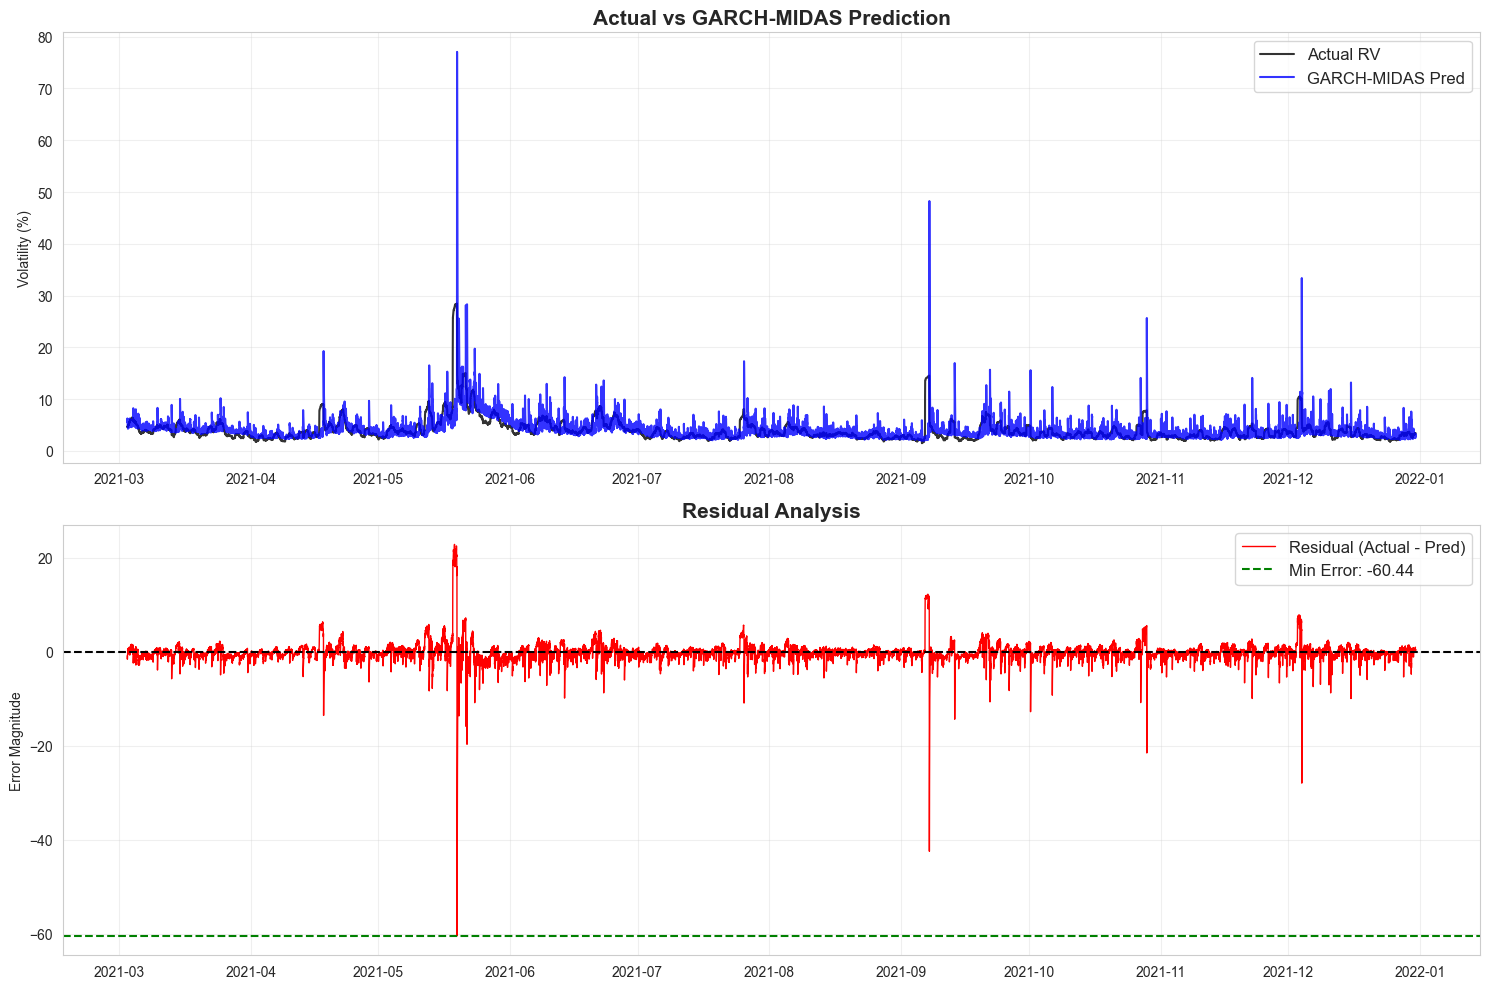

[INFO] Base Model Running (Exog: delta_H)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:04,  2.23it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070091
   - Beta  (GARCH) : 0.871729
   - m     (Const) : 0.198577  -> (m^2 used: 0.03943296)
   - Theta (RV_Wgt): 0.056993  -> (theta^2 used: 0.00324821)
   - W_Exog(exog_x): 0.523074  -> (w^2 used: 0.27360602)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.377737
   - Min : 0.251858
   - Max : 0.846031
   - First 5 values: [0.48179433 0.69485575 0.66023916 0.64681892 0.63239454]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:05,  1.46it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061719
   - Beta  (GARCH) : 0.891641
   - m     (Const) : 0.108098  -> (m^2 used: 0.01168509)
   - Theta (RV_Wgt): 0.065459  -> (theta^2 used: 0.00428488)
   - W_Exog(exog_x): 0.362040  -> (w^2 used: 0.13107311)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.302600
   - Min : 0.180107
   - Max : 1.599681
   - First 5 values: [0.29957186 0.29581788 0.28684786 0.27968688 0.27903383]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087343
   - Beta  (GARCH) : 0.861706
   - m     (Const) : 0.117793  -> (m^2 used: 0.01387510)
   - Theta (RV_Wgt): 0.074237  -> (theta^2 used: 0.00551107)
   - W_Exog(exog_x): 0.102133  -> (w^2 used: 0.01043110)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.544174
   - Min : 0.205845
   - Max : 6.419716
   - First 5 values: [0.31044161 0.31595478 0.30430841 0.29762971 0.28798523]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.04s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096845
   - Beta  (GARCH) : 0.858459
   - m     (Const) : 0.060421  -> (m^2 used: 0.00365069)
   - Theta (RV_Wgt): 0.069765  -> (theta^2 used: 0.00486716)
   - W_Exog(exog_x): 0.423497  -> (w^2 used: 0.17934956)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.417339
   - Min : 0.259765
   - Max : 1.191374
   - First 5 values: [0.53372062 0.51553709 0.53711044 0.51545559 0.50313979]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:07,  1.48s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092217
   - Beta  (GARCH) : 0.866041
   - m     (Const) : 0.103102  -> (m^2 used: 0.01063001)
   - Theta (RV_Wgt): 0.067214  -> (theta^2 used: 0.00451769)
   - W_Exog(exog_x): 0.416101  -> (w^2 used: 0.17313994)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285561
   - Min : 0.172185
   - Max : 1.444273
   - First 5 values: [0.37353792 0.35734488 0.34322337 0.32993746 0.31823309]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:08<00:07,  1.84s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097124
   - Beta  (GARCH) : 0.854127
   - m     (Const) : 0.101030  -> (m^2 used: 0.01020712)
   - Theta (RV_Wgt): 0.064773  -> (theta^2 used: 0.00419559)
   - W_Exog(exog_x): 0.431719  -> (w^2 used: 0.18638135)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.280920
   - Min : 0.181070
   - Max : 0.734934
   - First 5 values: [0.30638544 0.2981975  0.28976073 0.27835851 0.28346826]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:06,  2.09s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102867
   - Beta  (GARCH) : 0.836327
   - m     (Const) : 0.088582  -> (m^2 used: 0.00784679)
   - Theta (RV_Wgt): 0.065308  -> (theta^2 used: 0.00426513)
   - W_Exog(exog_x): 0.407222  -> (w^2 used: 0.16583001)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.326508
   - Min : 0.167515
   - Max : 4.028238
   - First 5 values: [0.24043493 0.25403885 0.24168602 0.24846983 0.25025957]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:12<00:03,  1.93s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115628
   - Beta  (GARCH) : 0.824545
   - m     (Const) : 0.195121  -> (m^2 used: 0.03807217)
   - Theta (RV_Wgt): 0.067223  -> (theta^2 used: 0.00451888)
   - W_Exog(exog_x): 0.113910  -> (w^2 used: 0.01297558)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277386
   - Min : 0.186576
   - Max : 2.138481
   - First 5 values: [0.2422734  0.23554952 0.23697176 0.23154184 0.24719739]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.29s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128903
   - Beta  (GARCH) : 0.784297
   - m     (Const) : 0.200278  -> (m^2 used: 0.04011116)
   - Theta (RV_Wgt): 0.063423  -> (theta^2 used: 0.00402242)
   - W_Exog(exog_x): 0.179014  -> (w^2 used: 0.03204607)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.271919
   - Min : 0.185358
   - Max : 1.175185
   - First 5 values: [0.24376167 0.28177332 0.28226136 0.26788998 0.26142017]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136233
   - Beta  (GARCH) : 0.772050
   - m     (Const) : 0.203528  -> (m^2 used: 0.04142379)
   - Theta (RV_Wgt): 0.065279  -> (theta^2 used: 0.00426132)
   - W_Exog(exog_x): 0.063402  -> (w^2 used: 0.00401984)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296755
   - Min : 0.183598
   - Max : 2.781206
   - First 5 values: [0.29089162 0.32570109 0.30846527 0.30898545 0.30596511]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1594.86it/s]


Final Data shape: (43632, 728)
Stats Comparison:
-> Actual RV Mean: 3.9563, Std: 2.2369
-> GARCH Pred Mean: 4.0526, Std: 2.1521
-> Average Residual: -0.0963, Std: 2.2625
-> Min Residual: -60.4251


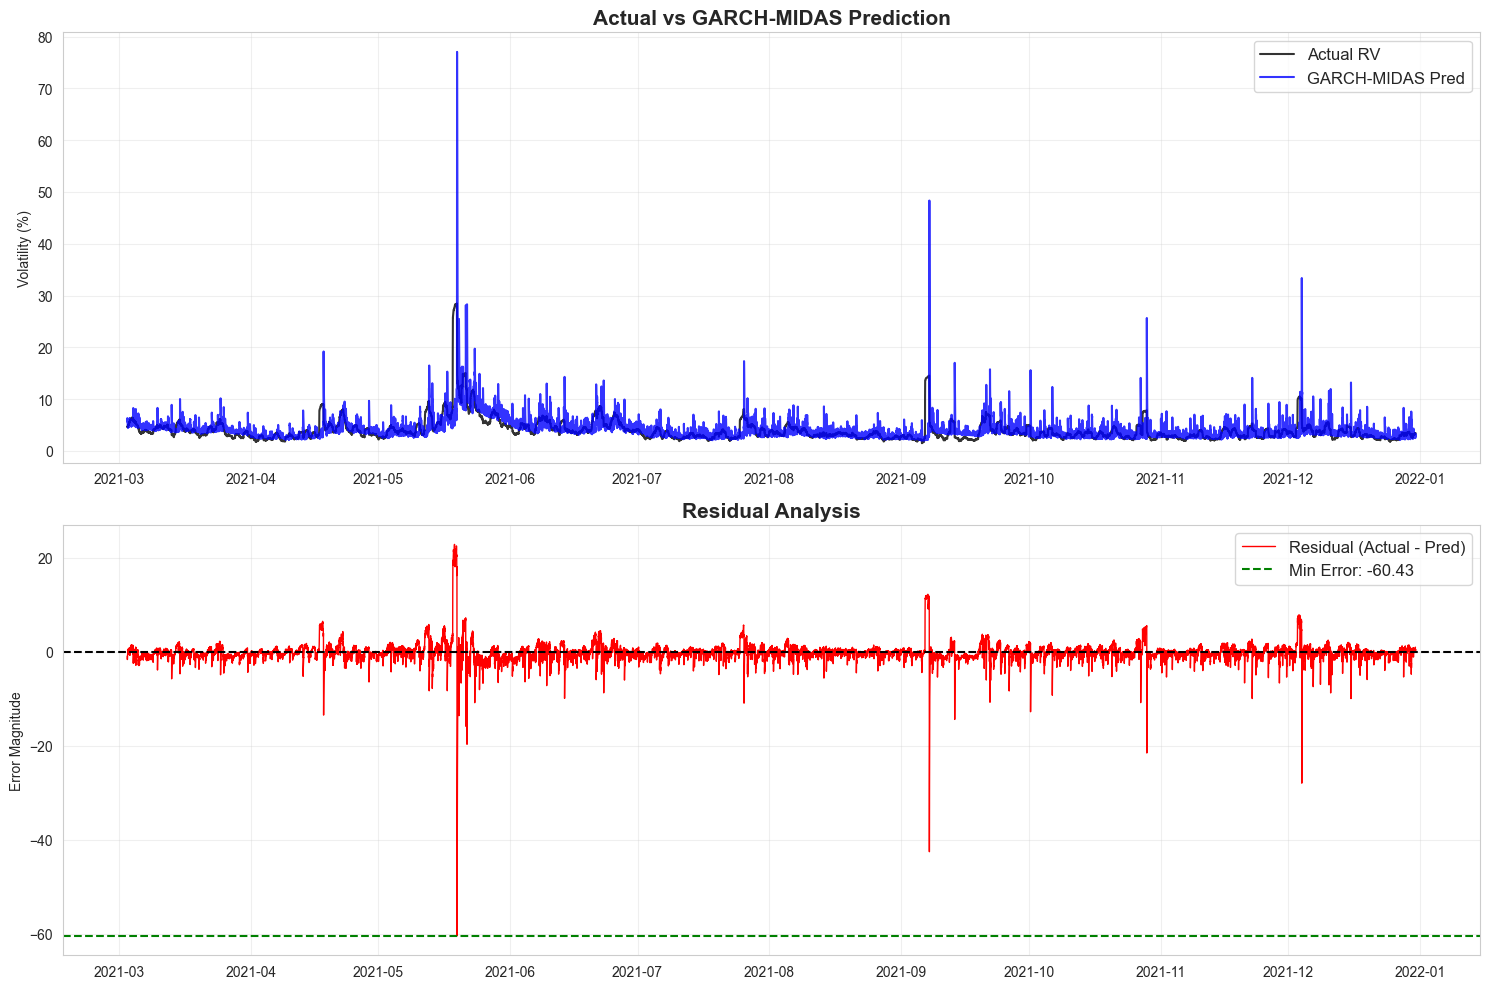

[INFO] Base Model Running (Exog: delta_alpha)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.43it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070106
   - Beta  (GARCH) : 0.872798
   - m     (Const) : 0.256855  -> (m^2 used: 0.06597432)
   - Theta (RV_Wgt): 0.055086  -> (theta^2 used: 0.00303450)
   - W_Exog(exog_x): 0.304598  -> (w^2 used: 0.09277996)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376625
   - Min : 0.254813
   - Max : 0.846042
   - First 5 values: [0.47877908 0.69277914 0.65822367 0.64487822 0.63049825]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:04,  1.69it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061782
   - Beta  (GARCH) : 0.891771
   - m     (Const) : 0.140976  -> (m^2 used: 0.01987426)
   - Theta (RV_Wgt): 0.065164  -> (theta^2 used: 0.00424640)
   - W_Exog(exog_x): 0.228748  -> (w^2 used: 0.05232571)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.303501
   - Min : 0.182793
   - Max : 1.600903
   - First 5 values: [0.3004635  0.29671594 0.28776322 0.28061569 0.27996095]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:02<00:05,  1.26it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861689
   - m     (Const) : 0.123958  -> (m^2 used: 0.01536569)
   - Theta (RV_Wgt): 0.074428  -> (theta^2 used: 0.00553952)
   - W_Exog(exog_x): 0.000382  -> (w^2 used: 0.00000015)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543999
   - Min : 0.204958
   - Max : 6.421263
   - First 5 values: [0.30991454 0.31544766 0.30378296 0.29709548 0.287434  ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.03s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096893
   - Beta  (GARCH) : 0.858214
   - m     (Const) : 0.053827  -> (m^2 used: 0.00289736)
   - Theta (RV_Wgt): 0.069581  -> (theta^2 used: 0.00484153)
   - W_Exog(exog_x): 0.317074  -> (w^2 used: 0.10053579)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.416163
   - Min : 0.258064
   - Max : 1.191219
   - First 5 values: [0.53234143 0.51408126 0.53571251 0.51397258 0.50160634]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:06,  1.34s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092249
   - Beta  (GARCH) : 0.865775
   - m     (Const) : 0.087821  -> (m^2 used: 0.00771255)
   - Theta (RV_Wgt): 0.066967  -> (theta^2 used: 0.00448457)
   - W_Exog(exog_x): 0.321880  -> (w^2 used: 0.10360661)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285382
   - Min : 0.172174
   - Max : 1.444256
   - First 5 values: [0.37323709 0.3570137  0.34286826 0.32956255 0.31784327]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:07<00:06,  1.67s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097177
   - Beta  (GARCH) : 0.853864
   - m     (Const) : 0.089420  -> (m^2 used: 0.00799591)
   - Theta (RV_Wgt): 0.064573  -> (theta^2 used: 0.00416969)
   - W_Exog(exog_x): 0.330372  -> (w^2 used: 0.10914555)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281654
   - Min : 0.182009
   - Max : 0.735256
   - First 5 values: [0.30689694 0.29868622 0.29023287 0.27882272 0.28391236]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:05,  2.00s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102813
   - Beta  (GARCH) : 0.836312
   - m     (Const) : 0.075260  -> (m^2 used: 0.00566407)
   - Theta (RV_Wgt): 0.065191  -> (theta^2 used: 0.00424990)
   - W_Exog(exog_x): 0.311166  -> (w^2 used: 0.09682454)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.325669
   - Min : 0.167784
   - Max : 4.027171
   - First 5 values: [0.24054598 0.25414151 0.24180437 0.24858469 0.25037527]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:13<00:04,  2.24s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115626
   - Beta  (GARCH) : 0.824493
   - m     (Const) : 0.193525  -> (m^2 used: 0.03745199)
   - Theta (RV_Wgt): 0.067158  -> (theta^2 used: 0.00451013)
   - W_Exog(exog_x): 0.094579  -> (w^2 used: 0.00894513)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277453
   - Min : 0.186656
   - Max : 2.138425
   - First 5 values: [0.24239673 0.23567779 0.23710063 0.23167495 0.24732286]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.38s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128875
   - Beta  (GARCH) : 0.784329
   - m     (Const) : 0.192757  -> (m^2 used: 0.03715529)
   - Theta (RV_Wgt): 0.063186  -> (theta^2 used: 0.00399242)
   - W_Exog(exog_x): 0.160381  -> (w^2 used: 0.02572197)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.272954
   - Min : 0.187048
   - Max : 1.175324
   - First 5 values: [0.2443579  0.28227177 0.28275228 0.26840495 0.26194445]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136228
   - Beta  (GARCH) : 0.772053
   - m     (Const) : 0.203473  -> (m^2 used: 0.04140123)
   - Theta (RV_Wgt): 0.065286  -> (theta^2 used: 0.00426221)
   - W_Exog(exog_x): 0.047281  -> (w^2 used: 0.00223545)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296772
   - Min : 0.183630
   - Max : 2.781154
   - First 5 values: [0.29089949 0.32570717 0.30847283 0.30899325 0.30597332]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1589.00it/s]


Final Data shape: (43632, 728)
Stats Comparison:
-> Actual RV Mean: 3.9563, Std: 2.2369
-> GARCH Pred Mean: 4.0520, Std: 2.1503
-> Average Residual: -0.0957, Std: 2.2624
-> Min Residual: -60.4436


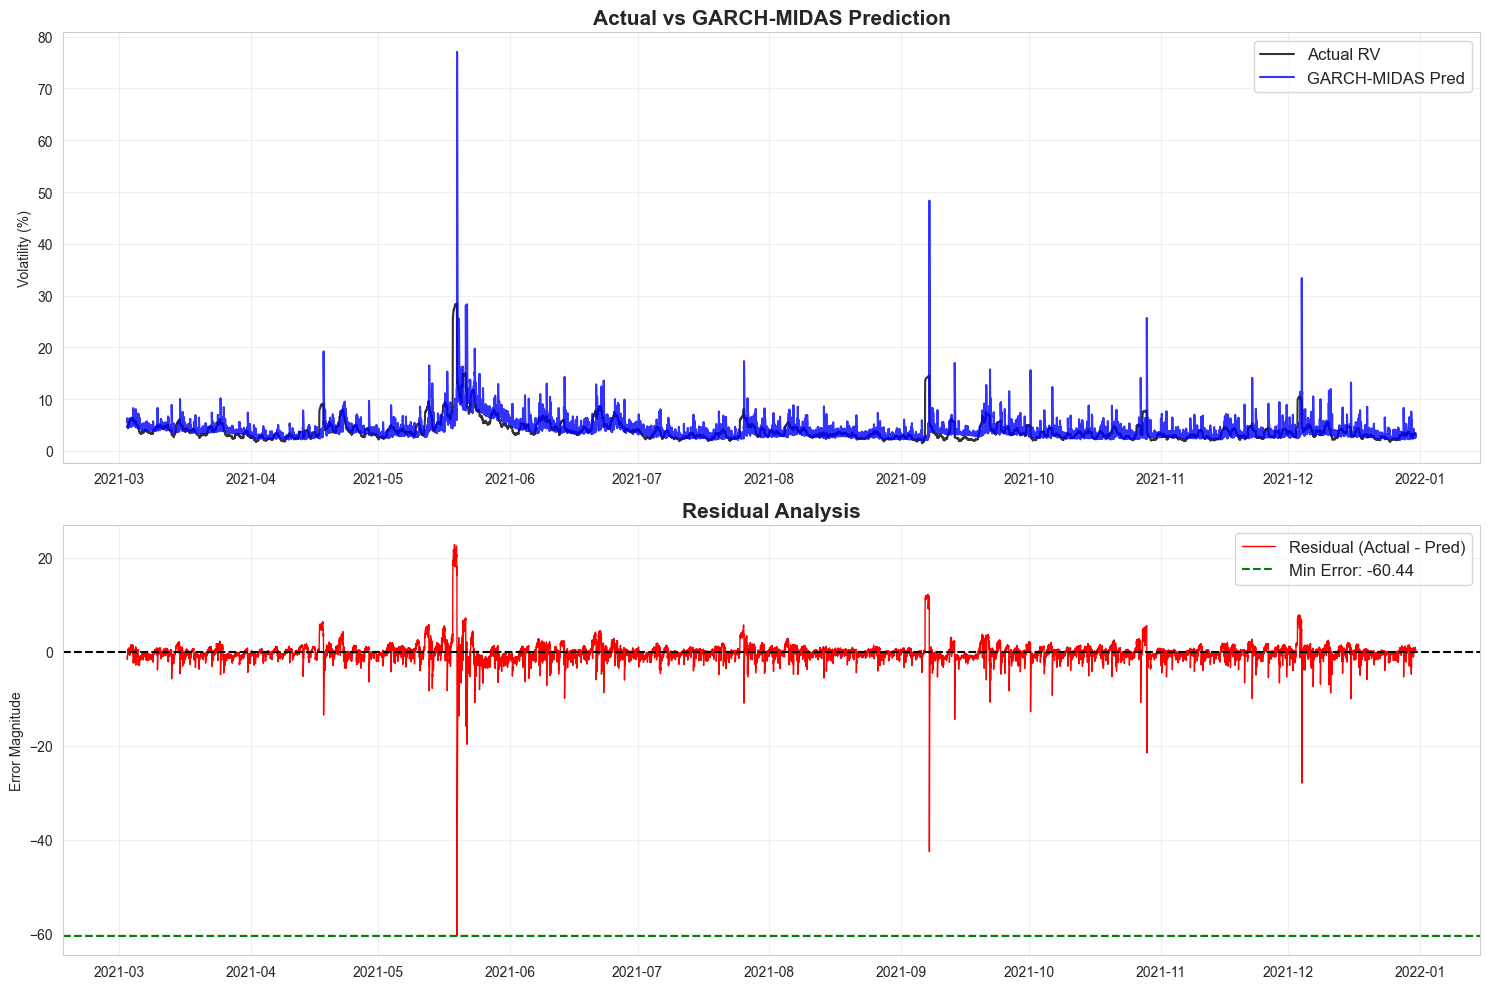

In [ ]:
def visualize_garch_midas_fit(df_10m, mfdfa_data, scale_factor = 12):
    print(f"\nGARCH-MIDAS Predictions vs Actual RV")
    print("="*80)
    
    scenarios = {
        "1. Benchmark (No Exog)": None,
        "2. delta H": "delta_H",
        "3. delta alpha": "delta_alpha"
    }
    
    
    for name, exog_col in scenarios.items():
        ax = axes[i]
        try:
            df_base = monthly_garch_midas(df_10m, mfdfa_data, exog_col = exog_col)
    
            flat_data, _ = prepare_flatten_features(df_base, mfdfa_data, lags = 144)
            
            pred_garch = flat_data['Base_Vol'] * scale_factor
            actual_rv = flat_data['Future_Vol_24h']
            residual = actual_rv - pred_garch
            
            print(f"Stats Comparison:")
            print(f"-> Actual RV Mean: {actual_rv.mean():.4f}, Std: {actual_rv.std():.4f}")
            print(f"-> GARCH Pred Mean: {pred_garch.mean():.4f}, Std: {pred_garch.std():.4f}")
            print(f"-> Average Residual: {residual.mean():.4f}, Std: {residual.std():.4f}")
            print(f"-> Min Residual: {residual.min():.4f}")
            
            plt.figure(figsize = (15, 10))
            sns.set_style("whitegrid")
            
            ax1 = plt.subplot(2, 1, 1)
            ax1.plot(flat_data.index, actual_rv, label = 'Actual RV', color = 'black', linewidth = 1.5, alpha = 0.8)
            ax1.plot(flat_data.index, pred_garch, label = 'GARCH-MIDAS Pred', color = 'blue', linewidth = 1.0, alpha = 0.5)
            ax1.set_title("Actual vs GARCH-MIDAS Prediction", fontsize = 15, fontweight = 'bold')
            ax1.set_ylabel("Volatility (%)")
            ax1.legend(loc = 'upper right', fontsize = 12)
            ax1.grid(True, alpha = 0.3)
            
            ax2 = plt.subplot(2, 1, 2)
            ax2.plot(flat_data.index, residual, label = 'Residual (Actual - Pred)', color = 'red', linewidth = 1)
            ax2.axhline(0, color = 'black', linestyle = '--')
            ax2.axhline(residual.min(), color = 'green', linestyle = '--', label = f'Min Error: {residual.min():.2f}')
            ax2.set_title("Residual Analysis", fontsize = 15, fontweight = 'bold')
            ax2.set_ylabel("Error Magnitude")
            ax2.legend(loc = 'upper right', fontsize = 12)
            ax2.grid(True, alpha = 0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f" [Error] {name}: {e}")
            axes[i, 0].text(0.5, 0.5, f"Error: {e}", ha = 'center', va = 'center', color = 'red')
            axes[i, 1].axis('off')

print("Running GARCH-MIDAS to get base prediction")

visualize_garch_midas_fit(df_10m, mfdfa_2021, scale_factor = 12)

### Parameter Tuning

In [ ]:
class FlattenLSTM_tuned(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.0):
        super(FlattenLSTM_tuned, self).__init__()
        eff_dropout = dropout if num_layers > 1 else 0.0
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True, dropout = eff_dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out.squeeze()
    
class FlattenBiLSTM_tuned(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.0):
        super(FlattenBiLSTM_tuned, self).__init__()
        eff_dropout = dropout if num_layers > 1 else 0.0
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True, dropout = eff_dropout, bidirectional = True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        _, (hn, _) = self.bilstm(x)
        hn_cat = torch.cat((hn[-2], hn[-1]), dim = 1)
        out = self.fc(hn_cat)
        return out.squeeze()
    
class FlattenGRU_tuned(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.0):
        super(FlattenGRU_tuned, self).__init__()
        eff_dropout = dropout if num_layers > 1 else 0.0
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True, dropout = eff_dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        _, hn = self.gru(x)
        out = self.fc(hn[-1])
        return out.squeeze()
    
class FlattenBiGRU_tuned(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.0):
        super(FlattenBiGRU_tuned, self).__init__()
        eff_dropout = dropout if num_layers > 1 else 0.0
        self.bigru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True, dropout = eff_dropout, bidirectional = True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        _, hn = self.bigru(x)
        hn_cat = torch.cat((hn[-2], hn[-1]), dim = 1)
        out = self.fc(hn_cat)
        return out.squeeze()
 
def garch_midas_tuned(train_df, test_df, daily_rv, df_x, midas_k = 30):
    
    full_df = pd.concat([train_df, test_df])
    
    train_end_idx = train_df.index[-1]
    
    daily_rv_scaled = daily_rv.copy()
    if daily_rv_scaled['rv'].mean() < 0.1:
        daily_rv_scaled['rv'] = daily_rv_scaled['rv'] * 10000

    combined_daily = pd.merge(daily_rv_scaled[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['exog_x'] = combined_daily[x_col_name].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    combined_daily.dropna(inplace = True)

    merged = full_df.join(combined_daily[['midas_rv', 'exog_x']], how = 'left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)
    
    if merged['return'].abs().mean() < 0.1:
        merged['return_scaled'] = merged['return'] * 100
    else:
        merged['return_scaled'] = merged['return']
        
    mask_train = merged.index <= train_end_idx
    
    train_ret = merged.loc[mask_train, 'return_scaled'].values
    train_midas = merged.loc[mask_train, 'midas_rv'].values
    train_exog = merged.loc[mask_train, 'exog_x'].values
    T_train = len(train_ret)

    
    def objective(params):
        alpha, beta, m, theta, beta_x = params
        
        if alpha + beta >= 0.999 or alpha < 0 or beta < 0:
            return 1e10

        tau = (m**2) + (theta**2 * train_midas) + (beta_x**2 * train_exog)
        tau = np.maximum(tau, 1e-12)
        
        g = np.ones(T_train)
        e2_over_tau = (train_ret**2) / tau
        omega = (1 - alpha - beta)
        
        g[0] = 1.0
        for t in range(1, T_train):
            g[t] = omega + alpha * e2_over_tau[t-1] + beta * g[t-1]
            
        h = tau * g
        llh = 0.5 * (np.log(2 * np.pi) + np.log(h) + (train_ret**2) / h)
        return np.sum(llh)
        
    initial_guess = [0.05, 0.90, 0.1, 0.3, 0.1]
    bounds = [(0, 1), (0, 1), (None, None), (None, None), (None, None)]
    
    try:
        res = minimize(objective, initial_guess, method = 'L-BFGS-B', bounds = bounds)
        best_params = res.x
        success = res.success
        msg = res.message
    except:
        best_params = initial_guess
        success = False
        msg = "Optimization Crash"
        
    alpha, beta, m ,theta, beta_x = best_params
    
    full_ret = merged['return_scaled'].values
    full_midas = merged['midas_rv'].values
    full_exog = merged['exog_x'].values
    T_full = len(full_ret)
    
    tau_full = (m**2) + (theta**2 * full_midas) + (beta_x**2 * full_exog)
    tau_full = np.maximum(tau_full, 1e-12)
    
    g_full = np.ones(T_full)
    e2_over_tau_full = (full_ret**2) / tau_full
    omega = (1 - alpha - beta)
    
    for t in range(1, T_full):
        g_full[t] = omega + alpha * e2_over_tau_full[t-1] + beta * g_full[t-1]
        
    merged['gm_vol'] = np.sqrt(tau_full * g_full)
    
    mask_test = merged.index > train_end_idx
    test_result = merged.loc[mask_test].copy()
    
    return test_result
       
def monthly_garch_midas_tuned(df_target, mfdfa_df, exog_col = None, midas_k = 30):
    """
    Apply midas_k value to monthly_garch_midas function to find optimal k
    """
    print(f"[INFO] Base Model Running (Exog: {exog_col if exog_col else 'None'})")
    print(f"   -> [GARCH-MIDAS] Running with midas_k = {midas_k}")
    
    monthly_results = []
    
    month_starts = df_target.resample('MS').first().index
    
    min_train_month = 2
    
    daily_rv_all = (df_target['return']**2).resample('1D').sum().to_frame('rv')
    
    mfdfa_df.index = pd.to_datetime(mfdfa_df.index).normalize()
    
    if exog_col is None:
        df_x_full = pd.DataFrame(0, index = mfdfa_df.index, columns = ['exog_x'])
    else:
        if exog_col not in mfdfa_df.columns:
            raise KeyError(f"Not Exist '{exog_col}' column in MF-DFA data")
        df_x_full = mfdfa_df[[exog_col]].copy()
        df_x_full.columns = ['exog_x']
        
    df_x_full = df_x_full.resample('1D').mean()
    
    print(f"   -> RV 데이터 기간: {daily_rv_all.index.min()} ~ {daily_rv_all.index.max()}")
    print(f"   -> MF-DFA 데이터 기간: {df_x_full.index.min()} ~ {df_x_full.index.max()}")
    
    # 교집합 확인
    common_idx = daily_rv_all.index.intersection(df_x_full.index)
    print(f"   -> 겹치는 날짜 수: {len(common_idx)}일")
    
    if len(common_idx) < 100:
        raise ValueError(f"데이터 날짜가 서로 안 맞습니다! 겹치는 날짜가 {len(common_idx)}개 뿐입니다.")
    
    df_x_full = df_x_full.reindex(daily_rv_all.index).fillna(method = 'ffill').fillna(0)

    pbar = tqdm(range(min_train_month, len(month_starts)), desc = "Monthly Re-fitting")
    
    for i in pbar:
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        train_slice = df_target[:current_month]
        
        if next_month:
            test_slice = df_target[current_month:next_month]
        else:
            test_slice = df_target[current_month:]
            
        try:
            pred_df = garch_midas_tuned(
                train_slice, test_slice, daily_rv_all, df_x_full, midas_k
            )
            monthly_results.append(pred_df)
        except Exception as e:
            print(f"\n Error at {current_month.strftime('%Y-%m')}: {e}")
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        print(f"Complete {len(final_gm_df)} Created")
        return final_gm_df
    else:
        raise ValueError("No result by Failing GARCH0-MDIAS Model Training")
    
def run_rolling_simulation_tuned(full_data, feature_cols, model_type = 'LSTM', train_window = 4320, params = None):
    """
    Run Rolling Simulation with Tuned Models
    """
    model_type = model_type.upper()
    
    if params is None: params = {}
    
    hidden_dim = params.get('hidden_dim', 64)
    num_layers = params.get('num_layers', 2)
    lr = params.get('learning_rate', 0.001)
    dropout = params.get('dropout', 0.0)
    alpha_val = params.get('alpha', 1.0)
    
    print(f"\n[Simulation Tuned] {model_type} | Config: {params}")
    
    X_full = full_data[feature_cols].values
    
    if 'GARCH_Daily' not in full_data.columns:
        full_data['GARCH_Daily'] = full_data['Base_Vol'] * 12
        full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['GARCH_Daily']
    
    y_full = full_data[['Residual']].values
    
    start_idx = train_window
    scaler_X = MinMaxScaler((-1, 1)).fit(X_full[:start_idx])
    scaler_y = MinMaxScaler((-1, 1)).fit(y_full[:start_idx])
    
    X_scaled = scaler_X.transform(X_full)
    y_scaled = scaler_y.transform(y_full)
    
    is_deep_learning = model_type in ['LSTM', 'BI-LSTM', 'GRU', 'BI-GRU']
    
    if is_deep_learning:
        X_tensor = torch.FloatTensor(X_scaled).to(DEVICE).unsqueeze(1)
        y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
        
        input_dim = len(feature_cols)
        
        if model_type == 'LSTM':
            model = FlattenLSTM_tuned(input_dim, hidden_dim, num_layers, dropout).to(DEVICE)
        elif model_type == 'BI-LSTM':
            model = FlattenBiLSTM_tuned(input_dim, hidden_dim, num_layers, dropout).to(DEVICE)
        elif model_type == 'GRU':
            model = FlattenGRU_tuned(input_dim, hidden_dim, num_layers, dropout).to(DEVICE)
        elif model_type == 'BI-GRU':
            model = FlattenBiGRU_tuned(input_dim, hidden_dim, num_layers, dropout).to(DEVICE)
            
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        loss_fn = nn.HuberLoss(delta = 1.0).to(DEVICE)
        
    predictions = []
    indices = []
    loss_history = []
    
    end_idx = len(full_data)
    pbar = tqdm(range(start_idx, end_idx), desc=f"{model_type} Rolling")
    for t in pbar:
        if is_deep_learning:
            model.train()
            X_batch = X_tensor[t - train_window : t]
            y_batch = y_tensor[t - train_window : t]
            
            optimizer.zero_grad()
            pred_train = model(X_batch)
            loss = loss_fn(pred_train, y_batch)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            
            model.eval()
            with torch.no_grad():
                X_input = X_tensor[t].unsqueeze(0)
                pred_val = model(X_input).item()
        else:
            ridge_model = Ridge(alpha = alpha_val)
            X_train = X_scaled[t - train_window : t]
            y_train = y_scaled[t - train_window : t]
            ridge_model.fit(X_train, y_train)
            
            X_curr = X_scaled[t].reshape(1, -1)
            pred_val = ridge_model.predict(X_curr).item()
        
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h', 'GARCH_Daily']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['GARCH_Daily'] + final_df['Predicted_Residual']
    
    return final_df, loss_history

def evaluate_model_static_tuned(model_name, params, X_tr, y_tr, X_val, y_val, input_dim):
    """
    Return RMSE After Training  Train/Val Set for Grid Search
    """
    
    model_name = model_name.upper()
    
    if model_name == 'RIDGE':
        model = Ridge(alpha = params['alpha'])
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        return np.sqrt(mean_squared_error(y_val, pred))
    
    else:
        X_tr_t = torch.FloatTensor(X_tr).unsqueeze(1).to(DEVICE)
        y_tr_t = torch.FloatTensor(y_tr).to(DEVICE)
        X_val_t = torch.FloatTensor(X_val).unsqueeze(1).to(DEVICE)
        
        hidden = params['hidden_dim']
        layers = params['num_layers']
        lr = params['learning_rate']
        drop = params['dropout']
        
        if model_name == 'LSTM': model = FlattenLSTM_tuned(input_dim, hidden, layers, drop).to(DEVICE)
        elif model_name == 'BI-LSTM': model = FlattenBiLSTM_tuned(input_dim ,hidden, layers, drop).to(DEVICE)
        elif model_name == 'GRU': model = FlattenGRU_tuned(input_dim, hidden, layers, drop).to(DEVICE)
        elif model_name == 'BI-GRU': model = FlattenBiGRU_tuned(input_dim, hidden, layers, drop).to(DEVICE)
        
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        loss_fn = nn.HuberLoss(delta = 1.0).to(DEVICE)
        
        epochs = 20
        
        model.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            pred_train = model(X_tr_t)
            loss = loss_fn(pred_train, y_tr_t)
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val_t).cpu().numpy()
        
        return np.sqrt(mean_squared_error(y_val, pred_val))
    
def run_full_experiment_tuned(df_10m, mfdfa_data):
    
    final_results = []
    
    midas_k_grid = [3, 7, 14, 30]
    
    ridge_params = {'alpha': [0.1, 1.0, 5.0, 10.0]}
    
    dl_params = {
        'hidden_dim': [32, 64, 128],
        'num_layers': [1, 2],
        'learning_rate': [0.01, 0.001],
        'dropout': [0.0, 0.2]
    }
    
    ai_models = ["Ridge", "LSTM", "Bi-LSTM", "GRU", "Bi-GRU"]
    
    scenarios = {
        "Benchmark": None,
        "Delta_H": "delta_H",
        "Delta_Alpha": "delta_alpha"
    }
    
    lags = 144
    TRAIN_WINDOW = 4320
    scale_factor = 12
    
    for sc_name, exog_col in scenarios.items():
        print(f"\n{'='*60}\nScenario: {sc_name}\n{'='*60}")
        
        best_k = 30
        best_g_rmse = float('inf')
        best_df_base = None
        
        print("Tuning MIDAS K")
        for k in midas_k_grid:
            try:
                temp_base = monthly_garch_midas_tuned(df_10m, mfdfa_data, exog_col = exog_col, midas_k = k)
                flat, _ = prepare_flatten_features(temp_base,mfdfa_data, lags = lags)
                
                eval_start_idx = lags
                val_df = flat.iloc[eval_start_idx : TRAIN_WINDOW]
                
                rmse = np.sqrt(mean_squared_error(val_df['Future_Vol_24h'], val_df['Base_Vol'] * scale_factor))
                print(f"  -K = {k} RMSE: {rmse:.4f}")
                
                if rmse < best_g_rmse:
                    best_g_rmse = rmse
                    best_k = k
                    best_df_base = temp_base
            except Exception as e:
                print(f"  -K={k} Failed: {e}")
        
        full_flat, _ = prepare_flatten_features(best_df_base, mfdfa_data, lags = lags)
        
        test_df_garch = full_flat.iloc[TRAIN_WINDOW:]
        
        real_garch_rmse = np.sqrt(mean_squared_error(
            test_df_garch['Future_Vol_24h'],
            test_df_garch['Base_Vol'] * scale_factor
        ))
        
        print(f"RMSE for GARCH (k = {best_k}): {real_garch_rmse:.4f}")
        
        final_results.append({
            "Scenario": sc_name, "Model": "GARCH (BASE)",
            "Params": f"K={best_k}", "RMSE": real_garch_rmse
        })
        
        flat_data, features_all = prepare_flatten_features(best_df_base, mfdfa_data, lags = lags)
        
        df_tune = flat_data.iloc[:TRAIN_WINDOW].copy()
        
        feat_no_mf = ['Past_RV', 'return']
        feature_sets = [("No MF", feat_no_mf), ("Full", features_all)]
        
        for ai_name in ai_models:
            for feat_type, feats in feature_sets:
                print(f"\n >> {ai_name} ({feat_type}) Tuning")
                
                grid = ParameterGrid(ridge_params if ai_name == 'Ridge' else dl_params)
                best_ai_rmse = float('inf')
                best_ai_params = {}
                
                X_all = df_tune[feats].values
                target = df_tune['Future_Vol_24h'] - (df_tune['Base_Vol'] * scale_factor)
                y_all = target.values.reshape(-1, 1)
                
                split = int(len(X_all) * 0.8)
                X_tr, y_tr = X_all[:split], y_all[:split]
                X_val, y_val = X_all[split:], y_all[split:]
                
                sc_x = MinMaxScaler((-1, 1)).fit(X_tr)
                sc_y = MinMaxScaler((-1, 1)).fit(y_tr)
                X_tr_s, y_tr_s = sc_x.transform(X_tr), sc_y.transform(y_tr)
                X_val_s, y_val_s = sc_x.transform(X_val), sc_y.transform(y_val)
                
                for params in grid:
                    try:
                        rmse_val = evaluate_model_static_tuned(
                            ai_name, params, X_tr_s, y_tr_s, X_val_s, y_val_s, len(feats)
                        )
                        if rmse_val < best_ai_rmse:
                            best_ai_rmse = rmse_val
                            best_ai_params = params
                    except: continue
                    
                print(f" - Best Params: {best_ai_params} (Val RMSE: {best_ai_rmse:.4f})")
                
                try:
                    final_df, _ = run_rolling_simulation_tuned(
                        flat_data, feats,
                        model_type = ai_name,
                        train_window = TRAIN_WINDOW,
                        params = best_ai_params
                    )
                    
                    eval_df = final_df.dropna()
                    final_rmse = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol']))
                    
                    final_results.append({
                        "Scenario": sc_name,
                        "Model": f"Hybrid {ai_name} ({feat_type})",
                        "Params": str(best_ai_params),
                        "RMSE": final_rmse
                    })
                except Exception as e:
                    print(f" Final Run Failed: {e}")
                    
    return pd.DataFrame(final_results).sort_values(by='RMSE')

final_leaderboard_tuned = run_full_experiment_tuned(df_10m, mfdfa_2021)

print("\n" + "="*80)
print(" Final Optimized Benchmark Leaderboard ")
print("="*80)

try:
    print(final_leaderboard_tuned.to_markdown(index=False))
except:
    print(final_leaderboard_tuned)


Scenario: Benchmark
Tuning MIDAS K
[INFO] Base Model Running (Exog: None)
   -> [GARCH-MIDAS] Running with midas_k = 3
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1319.62it/s]


Final Data shape: (43632, 728)
  -K = 3 RMSE: 1.2314
[INFO] Base Model Running (Exog: None)
   -> [GARCH-MIDAS] Running with midas_k = 7
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1396.61it/s]


Final Data shape: (43632, 728)
  -K = 7 RMSE: 1.1627
[INFO] Base Model Running (Exog: None)
   -> [GARCH-MIDAS] Running with midas_k = 14
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1377.44it/s]


Final Data shape: (43632, 728)
  -K = 14 RMSE: 1.1202
[INFO] Base Model Running (Exog: None)
   -> [GARCH-MIDAS] Running with midas_k = 30
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1404.40it/s]


Final Data shape: (43632, 728)
  -K = 30 RMSE: 1.0665
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1382.82it/s]


Final Data shape: (43632, 728)
RMSE for GARCH (k = 30): 2.3627
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1381.77it/s]


Final Data shape: (43632, 728)

 >> Ridge (No MF) Tuning
 - Best Params: {'alpha': 10.0} (Val RMSE: 0.2497)

[Simulation Tuned] RIDGE | Config: {'alpha': 10.0}


RIDGE Rolling: 100%|██████████| 39312/39312 [00:20<00:00, 1938.83it/s]



 >> Ridge (Full) Tuning
 - Best Params: {'alpha': 0.1} (Val RMSE: 0.1573)

[Simulation Tuned] RIDGE | Config: {'alpha': 0.1}


RIDGE Rolling: 100%|██████████| 39312/39312 [10:21<00:00, 63.21it/s]



 >> LSTM (No MF) Tuning
 - Best Params: {'dropout': 0.0, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2} (Val RMSE: 0.1751)

[Simulation Tuned] LSTM | Config: {'dropout': 0.0, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2}


LSTM Rolling: 100%|██████████| 39312/39312 [03:08<00:00, 208.92it/s]



 >> LSTM (Full) Tuning
 - Best Params: {'dropout': 0.0, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 2} (Val RMSE: 0.1795)

[Simulation Tuned] LSTM | Config: {'dropout': 0.0, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 2}


LSTM Rolling: 100%|██████████| 39312/39312 [03:27<00:00, 189.66it/s]



 >> Bi-LSTM (No MF) Tuning
 - Best Params: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1} (Val RMSE: 0.1728)

[Simulation Tuned] BI-LSTM | Config: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


BI-LSTM Rolling: 100%|██████████| 39312/39312 [09:16<00:00, 70.64it/s]



 >> Bi-LSTM (Full) Tuning
 - Best Params: {'dropout': 0.2, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 2} (Val RMSE: 0.1783)

[Simulation Tuned] BI-LSTM | Config: {'dropout': 0.2, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 2}


BI-LSTM Rolling: 100%|██████████| 39312/39312 [05:39<00:00, 115.72it/s]



 >> GRU (No MF) Tuning
 - Best Params: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1} (Val RMSE: 0.1716)

[Simulation Tuned] GRU | Config: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


GRU Rolling: 100%|██████████| 39312/39312 [03:52<00:00, 168.73it/s]



 >> GRU (Full) Tuning
 - Best Params: {'dropout': 0.2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1} (Val RMSE: 0.1769)

[Simulation Tuned] GRU | Config: {'dropout': 0.2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


GRU Rolling: 100%|██████████| 39312/39312 [04:18<00:00, 151.85it/s]



 >> Bi-GRU (No MF) Tuning
 - Best Params: {'dropout': 0.2, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 1} (Val RMSE: 0.1717)

[Simulation Tuned] BI-GRU | Config: {'dropout': 0.2, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 1}


BI-GRU Rolling: 100%|██████████| 39312/39312 [02:27<00:00, 265.70it/s]



 >> Bi-GRU (Full) Tuning
 - Best Params: {'dropout': 0.2, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2} (Val RMSE: 0.1749)

[Simulation Tuned] BI-GRU | Config: {'dropout': 0.2, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2}


BI-GRU Rolling: 100%|██████████| 39312/39312 [04:45<00:00, 137.82it/s]



Scenario: Delta_H
Tuning MIDAS K
[INFO] Base Model Running (Exog: delta_H)
   -> [GARCH-MIDAS] Running with midas_k = 3
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1493.69it/s]


Final Data shape: (43632, 728)
  -K = 3 RMSE: 1.2314
[INFO] Base Model Running (Exog: delta_H)
   -> [GARCH-MIDAS] Running with midas_k = 7
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1438.66it/s]


Final Data shape: (43632, 728)
  -K = 7 RMSE: 1.1627
[INFO] Base Model Running (Exog: delta_H)
   -> [GARCH-MIDAS] Running with midas_k = 14
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1149.82it/s]


Final Data shape: (43632, 728)
  -K = 14 RMSE: 1.1202
[INFO] Base Model Running (Exog: delta_H)
   -> [GARCH-MIDAS] Running with midas_k = 30
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1333.40it/s]


Final Data shape: (43632, 728)
  -K = 30 RMSE: 1.0636
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1250.50it/s]


Final Data shape: (43632, 728)
RMSE for GARCH (k = 30): 2.3600
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1564.37it/s]


Final Data shape: (43632, 728)

 >> Ridge (No MF) Tuning
 - Best Params: {'alpha': 10.0} (Val RMSE: 0.2357)

[Simulation Tuned] RIDGE | Config: {'alpha': 10.0}


RIDGE Rolling: 100%|██████████| 39312/39312 [00:19<00:00, 1967.78it/s]



 >> Ridge (Full) Tuning
 - Best Params: {'alpha': 1.0} (Val RMSE: 0.1645)

[Simulation Tuned] RIDGE | Config: {'alpha': 1.0}


RIDGE Rolling: 100%|██████████| 39312/39312 [09:06<00:00, 71.87it/s]



 >> LSTM (No MF) Tuning
 - Best Params: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2} (Val RMSE: 0.1754)

[Simulation Tuned] LSTM | Config: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}


LSTM Rolling: 100%|██████████| 39312/39312 [09:07<00:00, 71.82it/s]



 >> LSTM (Full) Tuning
 - Best Params: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 2} (Val RMSE: 0.1680)

[Simulation Tuned] LSTM | Config: {'dropout': 0.0, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 2}


LSTM Rolling:  63%|██████▎   | 24589/39312 [06:06<03:39, 67.18it/s]

In [ ]:
# import torch
# try:
#     import intel_extension_for_pytorch as ipex
#     print("✅ IPEX Import 성공!")
# except ImportError:
#     print("❌ IPEX Import 실패 (설치 확인 필요)")

# if hasattr(torch, 'xpu') and torch.xpu.is_available():
#     print(f"✅ Intel Arc GPU Detected: {torch.xpu.get_device_name(0)}")
# else:
#     print("⚠️ Intel GPU not found. (드라이버 문제이거나 재부팅 필요할 수 있음)")

OSError: [WinError 126] 지정된 모듈을 찾을 수 없습니다. Error loading "c:\Users\kjw02\anaconda3\Lib\site-packages\torch\lib\backend_with_compiler.dll" or one of its dependencies.